In [1]:
!git clone --depth 1 https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.53 MiB | 35.52 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 39.7 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-05-22 23:42:11--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.134, 13.200.41.136, 13.200.41.135, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.134|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:

In [2]:
!pip install mecab-python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 31.0 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Mecab
from tqdm.notebook import tqdm
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#1.baseline

In [2]:
df = pd.read_csv('ChatbotData.csv')

In [3]:
df.drop_duplicates(subset=['Q'], inplace=True)
df.drop_duplicates(subset=['A'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [65]:
enc_train, enc_test, dec_train, dec_test = train_test_split(
    df['Q'].to_list(),
    df['A'].to_list(),
    test_size=0.1,
    shuffle=True,
    random_state=42
)

In [66]:
df1= pd.DataFrame({'Q':enc_train,'A':dec_train})
df2= pd.DataFrame({'Q':enc_test,'A':dec_test})

In [69]:
df1.to_csv('train.csv',index=False)
df2.to_csv('valid.csv',index=False)

In [3]:
mecab=Mecab()

In [4]:
def preprocess(sentence):
  sentence = re.sub(r'[^a-z0-9가-힣\.!\?\s]', '', sentence)
  return mecab.morphs(sentence)

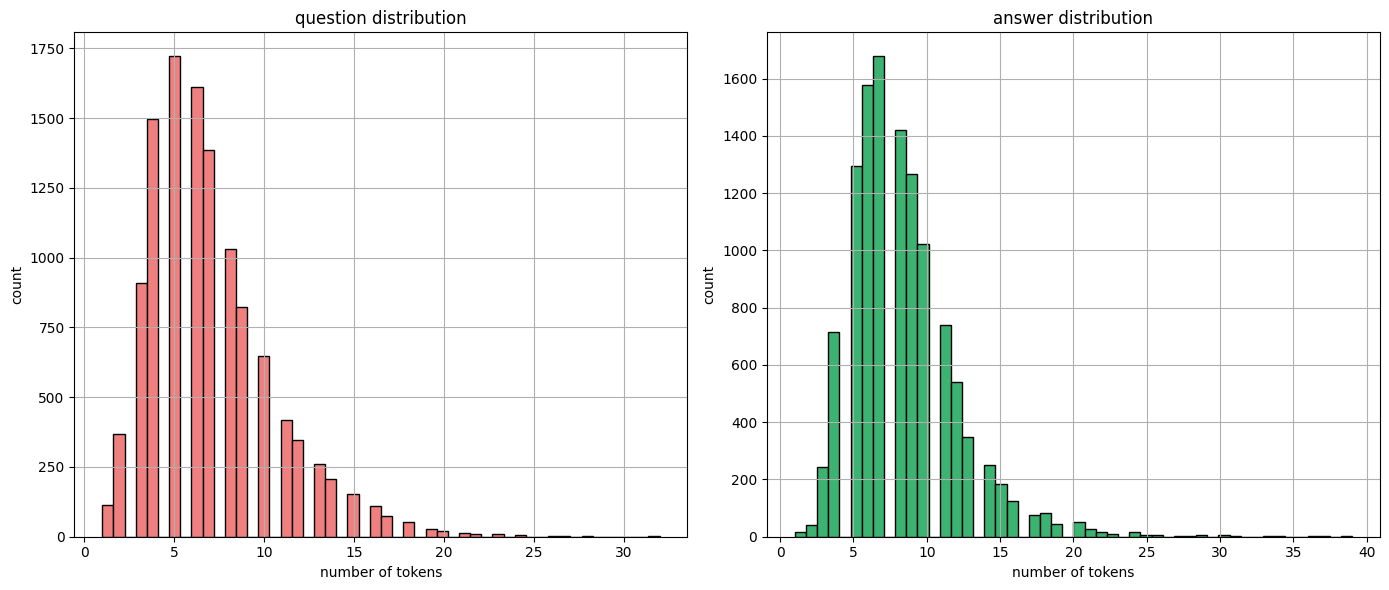

In [5]:
df['Q_']=df['Q'].apply(preprocess)
df['A_']=df['A'].apply(preprocess)
token_leng1 = df['Q_'].apply(lambda x: len(x))
token_leng2 = df['A_'].apply(lambda x: len(x))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(token_leng1, bins=50, color='lightcoral', edgecolor='black')
plt.title('question distribution')
plt.xlabel('number of tokens')
plt.ylabel('count')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(token_leng2, bins=50, color='mediumseagreen', edgecolor='black')
plt.title('answer distribution')
plt.xlabel('number of tokens')
plt.ylabel('count')
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
def build_corpus(df):
  df.dropna(inplace=True)
  df['Q_']=df['Q'].apply(preprocess)
  df['A_']=df['A'].apply(preprocess)
  df.drop_duplicates(subset=['Q_'], inplace=True)
  df.drop_duplicates(subset=['A_'], inplace=True)
  df.reset_index(drop=True, inplace=True)

  que_corpus , ans_corpus = [],[]
  for i in range(len(df)):
    if len(df['Q_'][i])<28 and len(df['A_'][i])<35:
      que_corpus.append(df['Q_'][i])
      ans_corpus.append(['<SOS>']+df['A_'][i]+['<EOS>'])
  return que_corpus, ans_corpus

In [6]:
que_corpus,ans_corpus = build_corpus(df)

In [10]:
def compute_vocab_coverage(corpus, topk_list=[1000, 2000, 5000, 8000, 10000, 20000]):
  tokenizer = Tokenizer(filters='', oov_token=None)
  tokenizer.fit_on_texts(corpus)

  word_counts = tokenizer.word_counts  # collections.OrderedDict
  sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

  total_tokens = sum([count for _, count in sorted_counts])

  print(f"총 토큰 수: {total_tokens}")
  print(f"전체 단어 수 (고유): {len(sorted_counts)}")

  cumulative = np.cumsum([count for _, count in sorted_counts])
  coverage_list = [cumulative[k-1] / total_tokens * 100 if k <= len(cumulative) else 100.0 for k in topk_list]

  for k, cov in zip(topk_list, coverage_list):
      print(f"Vocab Size = {k:5d} → Coverage: {cov:.2f}%")

  plt.figure(figsize=(8, 4))
  plt.plot(np.arange(1, len(cumulative)+1), cumulative / total_tokens * 100)
  plt.xlabel("Vocab Size (Top-N Words)")
  plt.ylabel("Coverage (%)")
  plt.title("Vocab Size vs. Token Coverage")
  plt.grid(True)
  plt.axhline(95, color='r', linestyle='--', label='95% Cutoff')
  plt.legend()
  plt.tight_layout()
  plt.show()

총 토큰 수: 57254
전체 단어 수 (고유): 4563
Vocab Size =  1000 → Coverage: 89.86%
Vocab Size =  2000 → Coverage: 94.95%
Vocab Size =  5000 → Coverage: 100.00%
Vocab Size =  8000 → Coverage: 100.00%
Vocab Size = 10000 → Coverage: 100.00%
Vocab Size = 20000 → Coverage: 100.00%


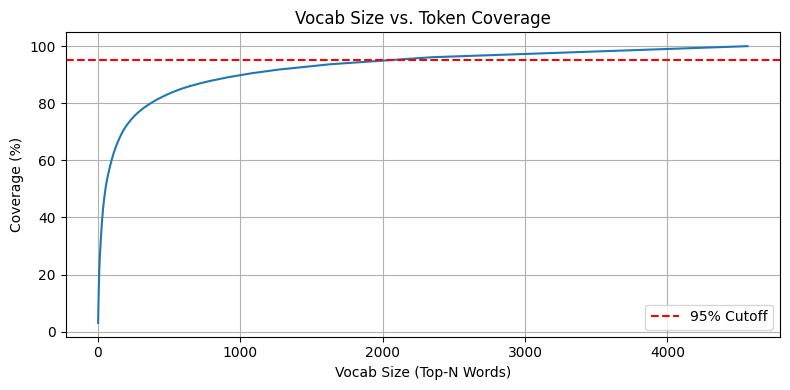

In [9]:
compute_vocab_coverage(que_corpus)

In [7]:
def tokenize(corpus1, corpus2, vocab_size=None, oov_token='<OOV>'):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='')
  tokenizer.fit_on_texts(corpus1+corpus2)

  tensor1 = tokenizer.texts_to_sequences(corpus1)
  tensor2 = tokenizer.texts_to_sequences(corpus2)

  tensor1 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding='post')
  tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor2, padding='post')

  return tensor1,tensor2, tokenizer

In [8]:
enc_corpus, dec_corpus, tokenizer=tokenize(que_corpus,ans_corpus)

In [9]:
enc_train, enc_test, dec_train, dec_test = train_test_split(
    enc_corpus,
    dec_corpus,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(len(enc_train)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [10]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual

        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                            for _ in range(n_layers)]

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [12]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [14]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [15]:
@tf.function
def eval_step(src, tgt, model):
  tgt_in = tgt[:, :-1]
  gold = tgt[:, 1:]

  enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

  predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)

  loss = loss_function(gold, predictions)

  return loss, enc_attns, dec_attns, dec_enc_attns

In [16]:
class EarlyStopping:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.best = None
    self.wait = 0
    self.stopped_epoch = 0
    self.stop_training = False

  def on_epoch_end(self, epoch, current):
    if self.best is None or current < self.best - self.min_delta:
      self.best = current
      self.wait = 0
      return True
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stop_training = True
        self.stopped_epoch = epoch
      return False

In [17]:
def plot_loss_graph(train_log, test_log):
  epochs = range(1, len(train_log) + 1)

  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_log, label='Train Loss')
  plt.plot(epochs, test_log, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train/Test Loss per Epoch')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [18]:
def main(transformer, optimizer, name,EPOCHS=10, early_stopping=EarlyStopping(patience=3, min_delta=0.001), train_dataset=train_dataset,valid_dataset=valid_dataset, save=True):
  train_log=[]
  valid_log=[]

  for epoch in range(EPOCHS):
    total_loss = 0

    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)

    for batch, (src, tgt) in enumerate(train_dataset):
      loss, _, _, _ = train_step(src, tgt, transformer, optimizer)
      total_loss += loss

      tqdm_bar.set_description(f"Epoch {epoch + 1}")
      tqdm_bar.set_postfix(loss=total_loss.numpy() / (batch + 1))
      tqdm_bar.update(1)

    tqdm_bar.close()
    train_epoch_loss = total_loss.numpy() / dataset_count
    train_log.append(train_epoch_loss)
    print(f"Epoch {epoch + 1} Train Loss: {train_epoch_loss:.4f}")

    val_loss_total = 0
    val_batches = tf.data.experimental.cardinality(valid_dataset).numpy()

    for batch, (src, tgt) in enumerate(valid_dataset):
      loss, _, _, _ = eval_step(src, tgt, transformer)
      val_loss_total += loss

    val_epoch_loss = val_loss_total.numpy() / val_batches
    valid_log.append(val_epoch_loss)
    print(f"Epoch {epoch + 1} Validation Loss: {val_epoch_loss:.4f}")

    is_best = early_stopping.on_epoch_end(epoch, val_epoch_loss)
    if save:
      if is_best:
        transformer.save_weights(name+"best_model.weights.h5")
        print(f"Best model saved at epoch {epoch+1}")

    if early_stopping.stop_training:
      print(f"Early stopping triggered at epoch {epoch+1}")
      break
  plot_loss_graph(train_log, valid_log)

  if save:
    transformer.load_weights(name+"best_model.weights.h5")

  return transformer, train_log, valid_log

---

In [19]:
import tensorflow.keras.backend as K
K.clear_session()

In [22]:
transformer1 = Transformer(
    n_layers=1,
    d_model=512,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=len(tokenizer.word_index)+1,
    tgt_vocab_size=len(tokenizer.word_index)+1,
    pos_len=80,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [20]:
transformer1 = Transformer(**transformer_args1)

In [21]:
d_model=128

In [22]:
learning_rate = LearningRateScheduler(d_model,warmup_steps=500)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98,
                                        epsilon=1e-9)

early_stopping = EarlyStopping(patience=3, min_delta=0.001)

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.8102
Epoch 1 Validation Loss: 4.4342
Best model saved at epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.8721
Epoch 2 Validation Loss: 3.7600
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.1167
Epoch 3 Validation Loss: 3.5802
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.3861
Epoch 4 Validation Loss: 3.6830


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.5980
Epoch 5 Validation Loss: 4.0870


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.0709
Epoch 6 Validation Loss: 4.5330


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.9277
Epoch 7 Validation Loss: 4.7435
Early stopping triggered at epoch 7


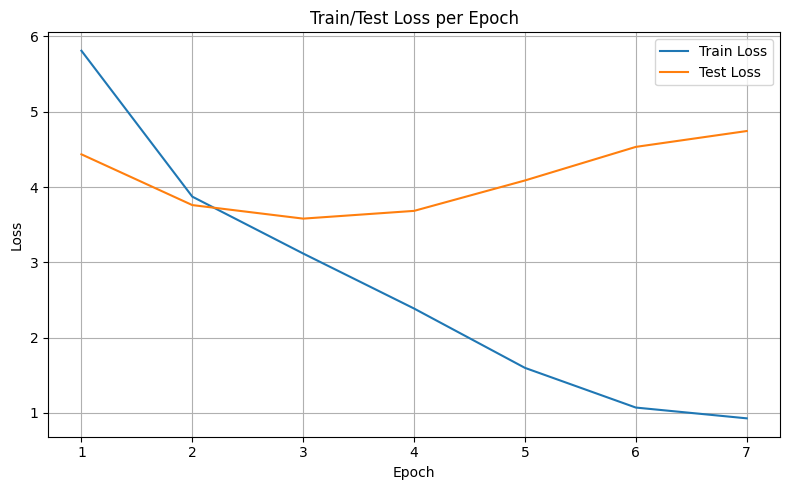

In [24]:
transformer1, train_log, valid_log = main(transformer1, optimizer, "transformer1_",EPOCHS=10, early_stopping=early_stopping, train_dataset=train_dataset,valid_dataset=valid_dataset)

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 5.7873
Epoch 1 Validation Loss: 4.3298
Best model saved at epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.7935
Epoch 2 Validation Loss: 3.7054
Best model saved at epoch 2


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.2141
Epoch 3 Validation Loss: 3.5951
Best model saved at epoch 3


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.7594
Epoch 4 Validation Loss: 3.6699


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.3374
Epoch 5 Validation Loss: 3.8034


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8420
Epoch 6 Validation Loss: 4.1288
Early stopping triggered at epoch 6


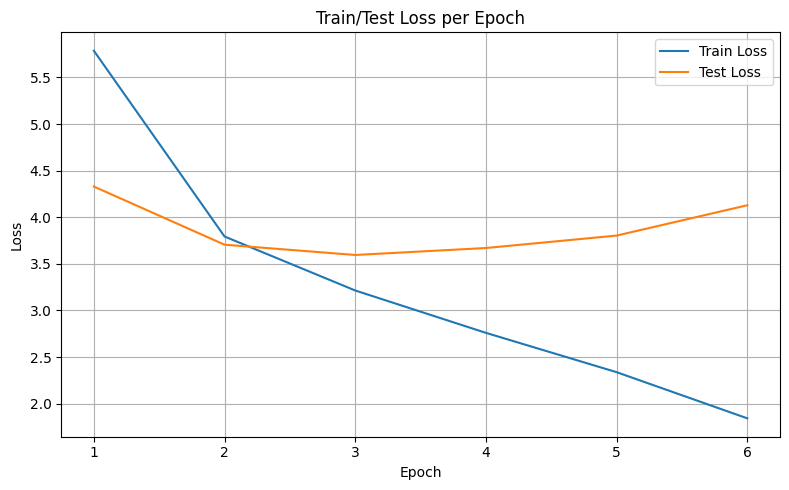

In [23]:
model5, train_log, valid_log = main(transformer1, optimizer, "base1_",EPOCHS=10, early_stopping=early_stopping, train_dataset=train_dataset,valid_dataset=valid_dataset)

#2.hyperparam

In [24]:
tf.config.run_functions_eagerly(True)

In [20]:
transformer_args = {
    "n_layers": 1,
    "d_model": 512,
    "n_heads": 8,
    "d_ff": 1024,
    "src_vocab_size": len(tokenizer.word_index) + 1,
    "tgt_vocab_size": len(tokenizer.word_index) + 1,
    "pos_len": 80,
    "dropout": 0.2,
    "shared_fc": True,
    "shared_emb": True
}

# Hyperparameters
# > n_layers: 1
# > d_model: 368
# > n_heads: 8
# > d_ff: 1024
# > dropout: 0.2

# Training Parameters
# > Warmup Steps: 1000
# > Batch Size: 64
# > Epoch At: 10

In [63]:
def tuner(transformer_args, name, save=False, warmup_steps=1000, epoch=10):
  transformer = Transformer(**transformer_args)
  d_model = transformer_args["d_model"]

  learning_rate = LearningRateScheduler(d_model,warmup_steps=1000)
  optimizer = tf.keras.optimizers.Adam(learning_rate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)
  early_stopping = EarlyStopping(patience=3, min_delta=0.001)

  transformer, train_log, valid_log = main(transformer, optimizer, name ,EPOCHS=epoch, early_stopping=early_stopping, train_dataset=train_dataset,valid_dataset=valid_dataset, save=save)
  return early_stopping.best

In [22]:
from itertools import product

search_space = {
    "n_layers": [1, 2, 3],
    "d_model": [128, 256, 368, 512, 1024],
    "n_heads": [4, 8],
    "d_ff": [512, 1024, 2048],
    "dropout": [0.1, 0.2, 0.3]
}

In [51]:
keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

Trial 1/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 512, 'dropout': 0.1}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3965
Epoch 1 Validation Loss: 4.8749


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3359
Epoch 2 Validation Loss: 4.0439


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6194
Epoch 3 Validation Loss: 3.7201


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1727
Epoch 4 Validation Loss: 3.6389


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7765
Epoch 5 Validation Loss: 3.6716


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3724
Epoch 6 Validation Loss: 3.8855


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9992
Epoch 7 Validation Loss: 4.0904
Early stopping triggered at epoch 7


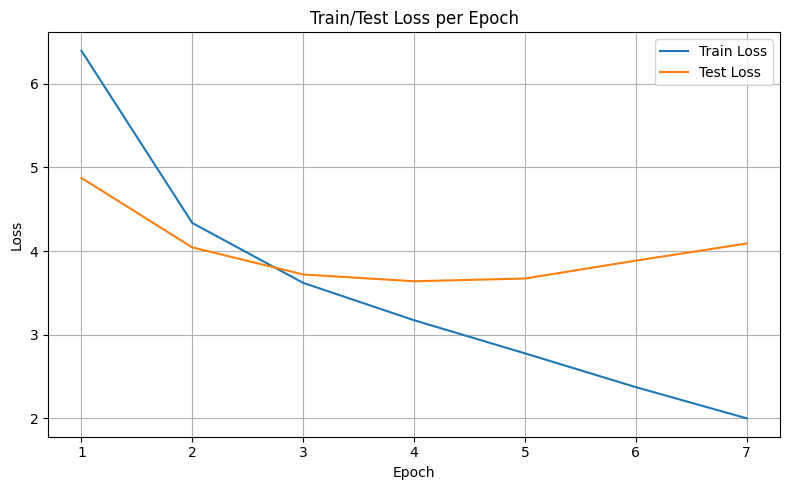

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3264
Epoch 1 Validation Loss: 4.8833


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3202
Epoch 2 Validation Loss: 4.0551


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6313
Epoch 3 Validation Loss: 3.7276


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2035
Epoch 4 Validation Loss: 3.6444


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8180
Epoch 5 Validation Loss: 3.6868


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4190
Epoch 6 Validation Loss: 3.8685


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0560
Epoch 7 Validation Loss: 4.0628
Early stopping triggered at epoch 7


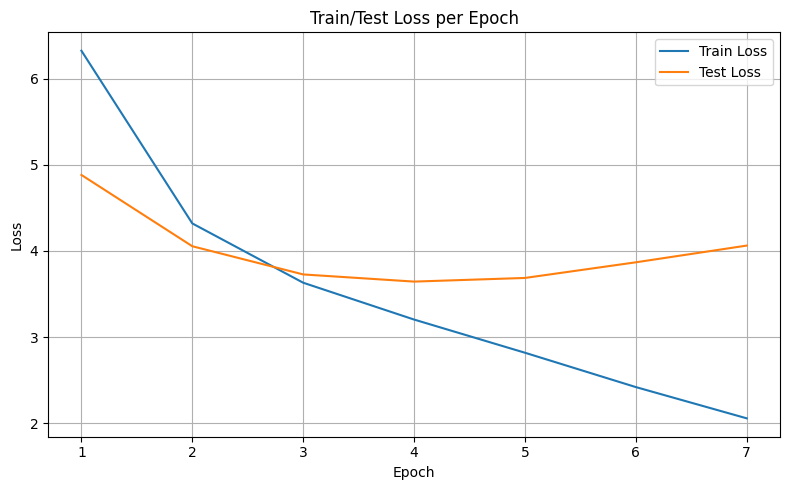

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3328
Epoch 1 Validation Loss: 4.8955


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3582
Epoch 2 Validation Loss: 4.0628


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6539
Epoch 3 Validation Loss: 3.7289


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2151
Epoch 4 Validation Loss: 3.6500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8183
Epoch 5 Validation Loss: 3.6924


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4135
Epoch 6 Validation Loss: 3.8121


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0443
Epoch 7 Validation Loss: 4.0185
Early stopping triggered at epoch 7


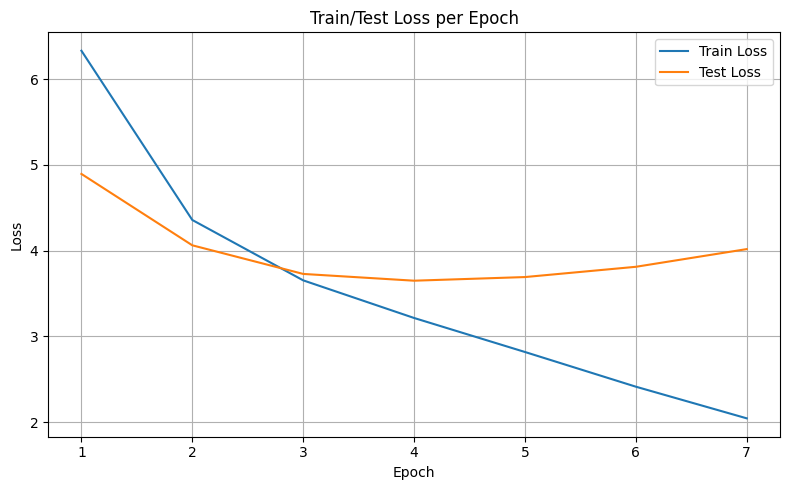

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3152
Epoch 1 Validation Loss: 4.8595


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3290
Epoch 2 Validation Loss: 4.0593


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6402
Epoch 3 Validation Loss: 3.7350


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2023
Epoch 4 Validation Loss: 3.6341


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7930
Epoch 5 Validation Loss: 3.6824


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3779
Epoch 6 Validation Loss: 3.8437


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9969
Epoch 7 Validation Loss: 4.1145
Early stopping triggered at epoch 7


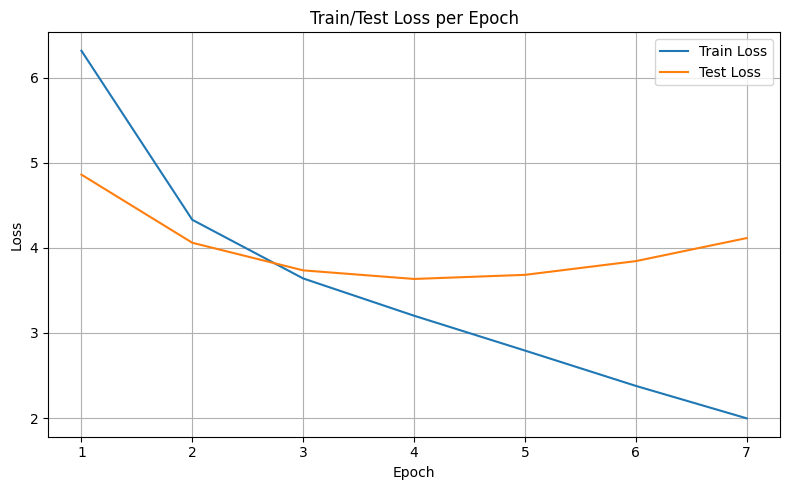

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2781
Epoch 1 Validation Loss: 4.8779


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3352
Epoch 2 Validation Loss: 4.0724


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6357
Epoch 3 Validation Loss: 3.7449


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1947
Epoch 4 Validation Loss: 3.6450


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7901
Epoch 5 Validation Loss: 3.6914


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3801
Epoch 6 Validation Loss: 3.8209


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0086
Epoch 7 Validation Loss: 4.0064
Early stopping triggered at epoch 7


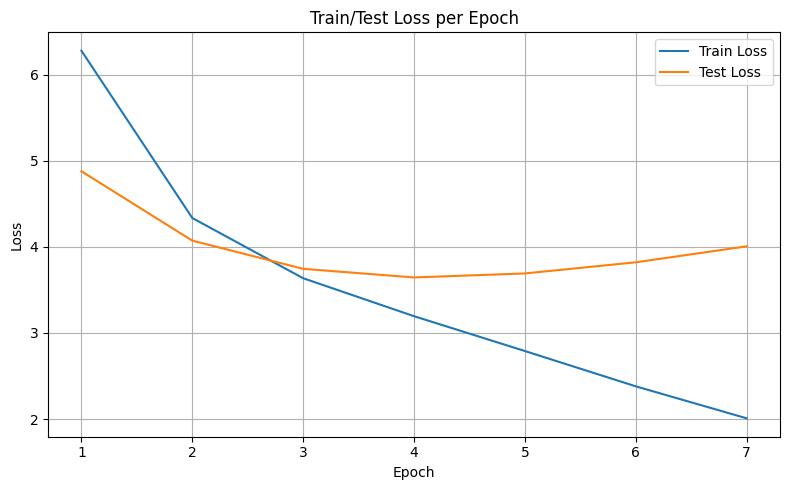

Trial 2/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 512, 'dropout': 0.2}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3526
Epoch 1 Validation Loss: 4.8985


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3501
Epoch 2 Validation Loss: 4.0456


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6296
Epoch 3 Validation Loss: 3.7502


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1960
Epoch 4 Validation Loss: 3.6527


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8029
Epoch 5 Validation Loss: 3.7069


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4071
Epoch 6 Validation Loss: 3.8793


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0472
Epoch 7 Validation Loss: 4.0709
Early stopping triggered at epoch 7


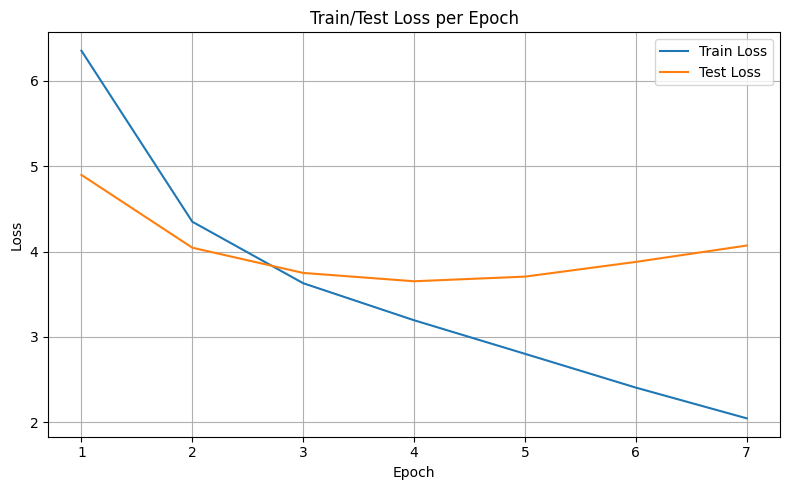

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3769
Epoch 1 Validation Loss: 4.9090


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3612
Epoch 2 Validation Loss: 4.0807


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6384
Epoch 3 Validation Loss: 3.7263


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1969
Epoch 4 Validation Loss: 3.6508


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7943
Epoch 5 Validation Loss: 3.7015


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3816
Epoch 6 Validation Loss: 3.8784


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9976
Epoch 7 Validation Loss: 4.1362
Early stopping triggered at epoch 7


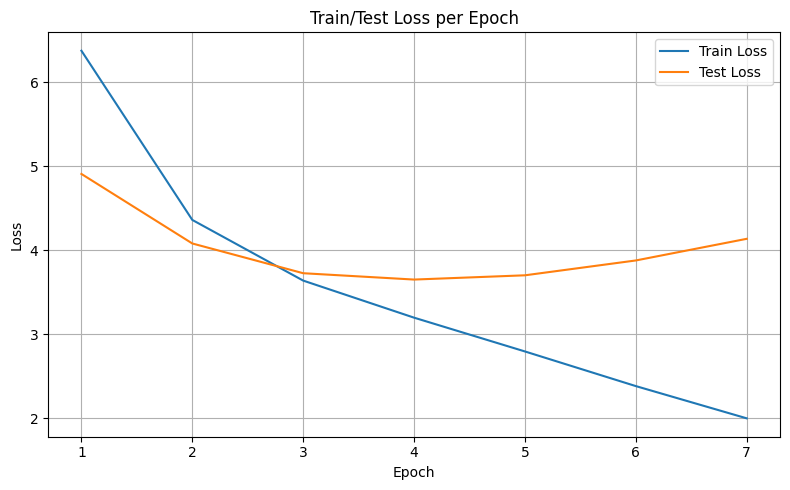

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3177
Epoch 1 Validation Loss: 4.8572


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3213
Epoch 2 Validation Loss: 4.0542


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6160
Epoch 3 Validation Loss: 3.7329


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2018
Epoch 4 Validation Loss: 3.6338


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8027
Epoch 5 Validation Loss: 3.7173


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3972
Epoch 6 Validation Loss: 3.8387


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0291
Epoch 7 Validation Loss: 4.0704
Early stopping triggered at epoch 7


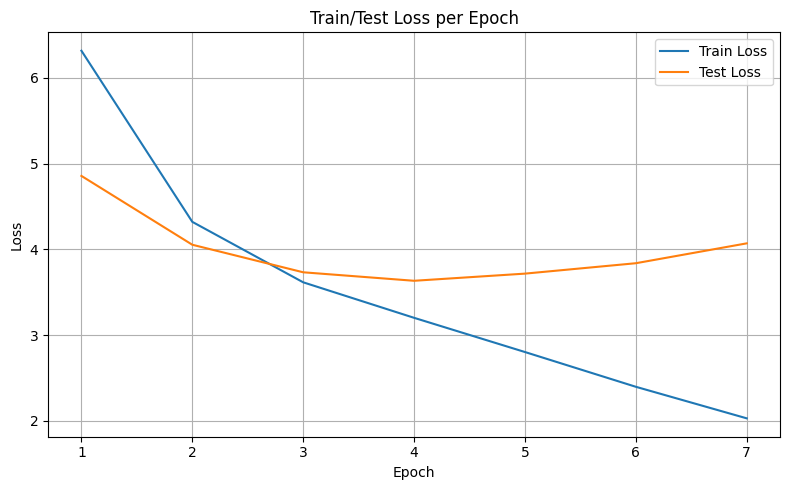

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3790
Epoch 1 Validation Loss: 4.9334


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3728
Epoch 2 Validation Loss: 4.0562


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6212
Epoch 3 Validation Loss: 3.7442


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1897
Epoch 4 Validation Loss: 3.6669


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8049
Epoch 5 Validation Loss: 3.6945


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4011
Epoch 6 Validation Loss: 3.8681


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0243
Epoch 7 Validation Loss: 4.1096
Early stopping triggered at epoch 7


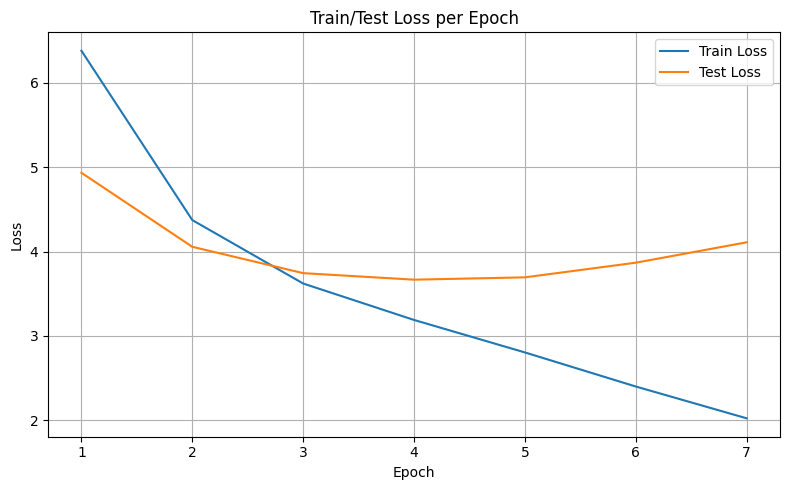

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3231
Epoch 1 Validation Loss: 4.8886


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3192
Epoch 2 Validation Loss: 4.0205


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5690
Epoch 3 Validation Loss: 3.6850


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1213
Epoch 4 Validation Loss: 3.6133


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7121
Epoch 5 Validation Loss: 3.7059


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3083
Epoch 6 Validation Loss: 3.8461


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9259
Epoch 7 Validation Loss: 4.1216
Early stopping triggered at epoch 7


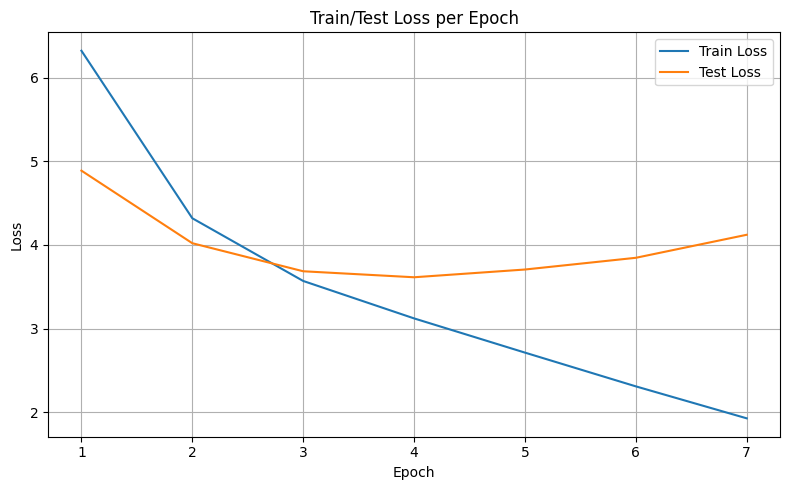

Trial 3/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 512, 'dropout': 0.3}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3409
Epoch 1 Validation Loss: 4.8833


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3383
Epoch 2 Validation Loss: 4.0656


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6575
Epoch 3 Validation Loss: 3.7639


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2509
Epoch 4 Validation Loss: 3.6705


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8629
Epoch 5 Validation Loss: 3.6815


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4614
Epoch 6 Validation Loss: 3.8456


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0731
Epoch 7 Validation Loss: 4.0638
Early stopping triggered at epoch 7


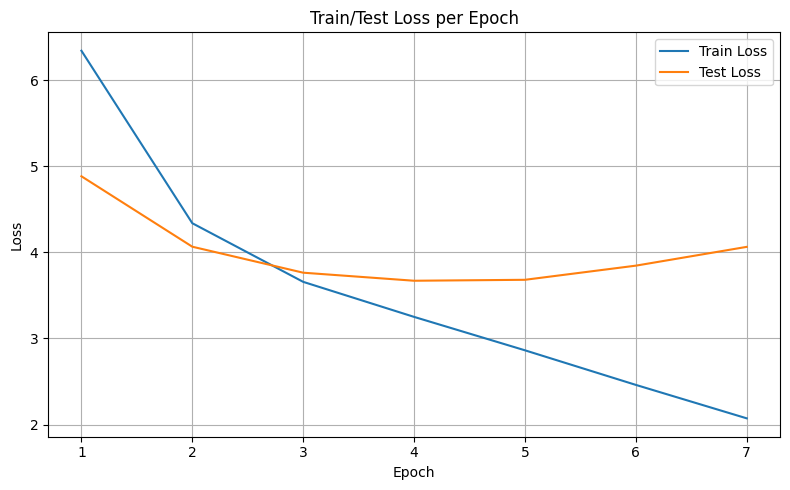

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2550
Epoch 1 Validation Loss: 4.8625


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3251
Epoch 2 Validation Loss: 4.0545


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6427
Epoch 3 Validation Loss: 3.7609


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2397
Epoch 4 Validation Loss: 3.6667


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8579
Epoch 5 Validation Loss: 3.7153


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4630
Epoch 6 Validation Loss: 3.8357


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0742
Epoch 7 Validation Loss: 4.0787
Early stopping triggered at epoch 7


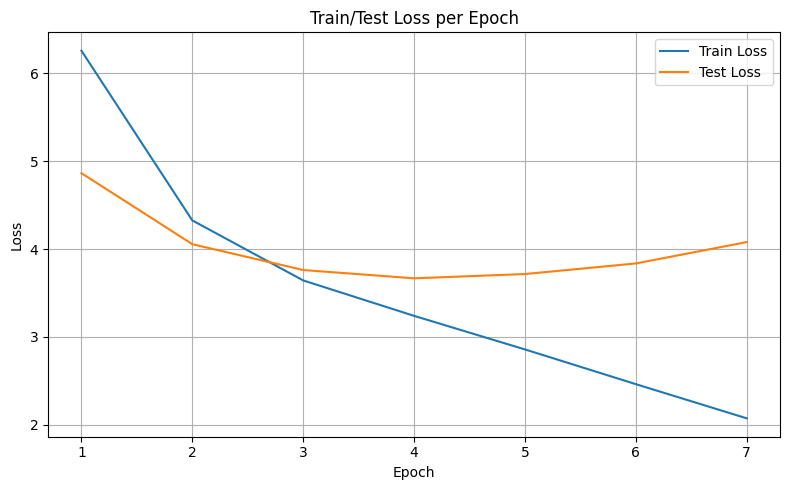

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2992
Epoch 1 Validation Loss: 4.8416


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3458
Epoch 2 Validation Loss: 4.0839


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6850
Epoch 3 Validation Loss: 3.8154


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2733
Epoch 4 Validation Loss: 3.7395


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8757
Epoch 5 Validation Loss: 3.7383


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4585
Epoch 6 Validation Loss: 3.9102


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0800
Epoch 7 Validation Loss: 4.1071


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 8 Train Loss: 1.7555
Epoch 8 Validation Loss: 4.3054
Early stopping triggered at epoch 8


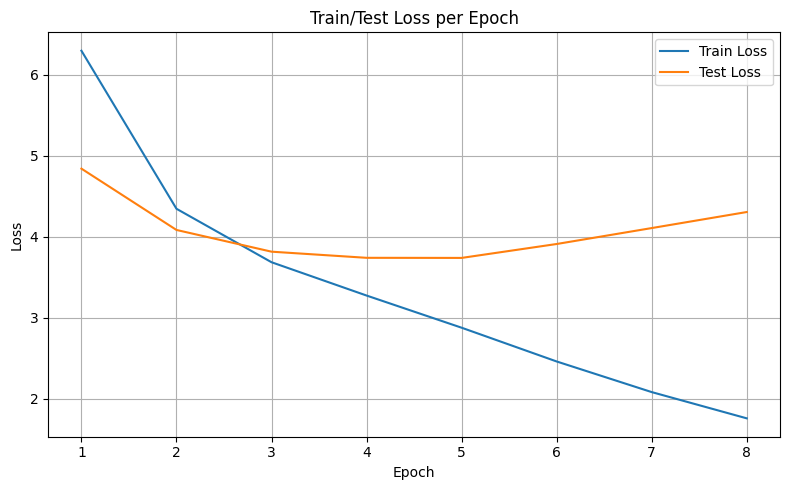

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3798
Epoch 1 Validation Loss: 4.8682


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3459
Epoch 2 Validation Loss: 4.0774


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6567
Epoch 3 Validation Loss: 3.7594


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2321
Epoch 4 Validation Loss: 3.6537


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8445
Epoch 5 Validation Loss: 3.7115


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4380
Epoch 6 Validation Loss: 3.8593


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0598
Epoch 7 Validation Loss: 4.0920
Early stopping triggered at epoch 7


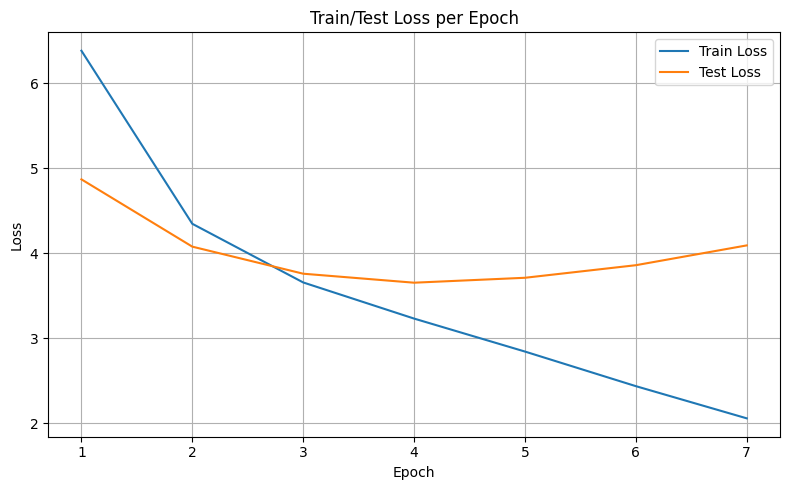

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3091
Epoch 1 Validation Loss: 4.8201


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2917
Epoch 2 Validation Loss: 4.0224


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6274
Epoch 3 Validation Loss: 3.7568


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2407
Epoch 4 Validation Loss: 3.6734


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8674
Epoch 5 Validation Loss: 3.6984


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4693
Epoch 6 Validation Loss: 3.8364


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0747
Epoch 7 Validation Loss: 4.0727
Early stopping triggered at epoch 7


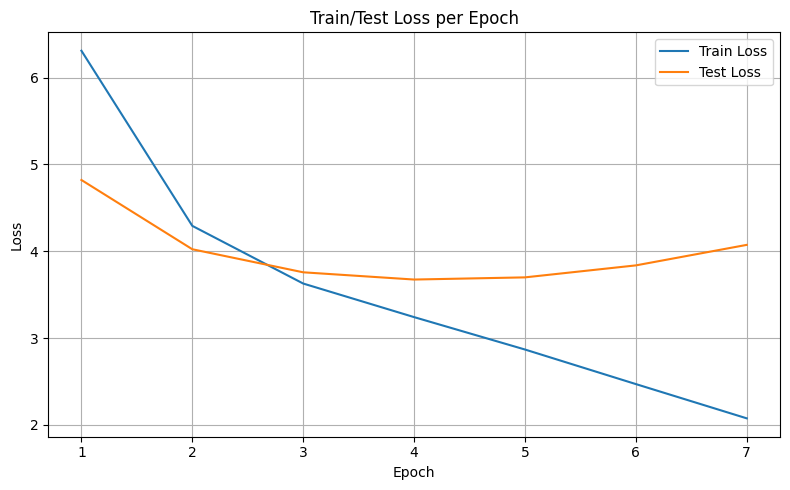

Trial 4/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 1024, 'dropout': 0.1}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2631
Epoch 1 Validation Loss: 4.8259


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2730
Epoch 2 Validation Loss: 3.9980


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5943
Epoch 3 Validation Loss: 3.7074


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1849
Epoch 4 Validation Loss: 3.6541


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7948
Epoch 5 Validation Loss: 3.6626


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3919
Epoch 6 Validation Loss: 3.8215


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0095
Epoch 7 Validation Loss: 4.0419
Early stopping triggered at epoch 7


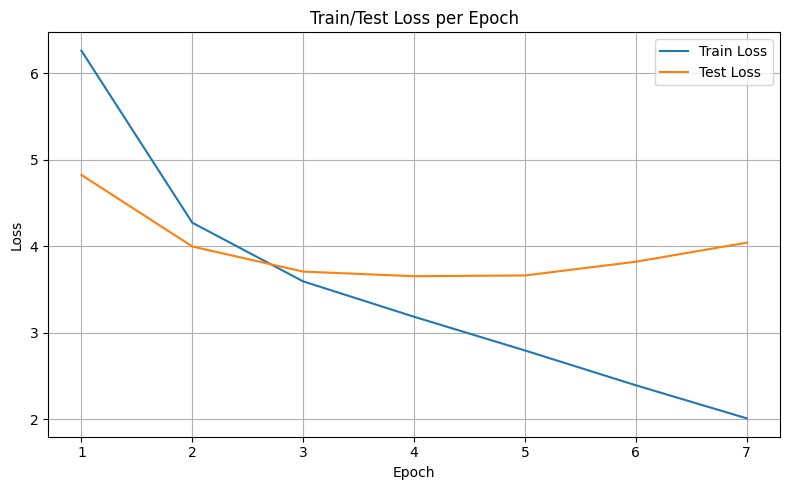

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2918
Epoch 1 Validation Loss: 4.8416


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3096
Epoch 2 Validation Loss: 4.0607


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6328
Epoch 3 Validation Loss: 3.7429


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2101
Epoch 4 Validation Loss: 3.6487


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8141
Epoch 5 Validation Loss: 3.7118


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4044
Epoch 6 Validation Loss: 3.8173


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0203
Epoch 7 Validation Loss: 4.0594
Early stopping triggered at epoch 7


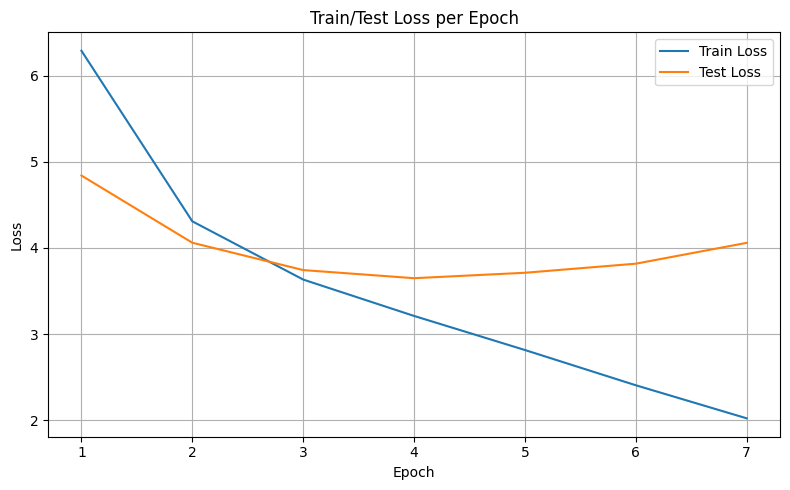

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3268
Epoch 1 Validation Loss: 4.8688


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3050
Epoch 2 Validation Loss: 4.0331


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6023
Epoch 3 Validation Loss: 3.7224


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1866
Epoch 4 Validation Loss: 3.6369


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8058
Epoch 5 Validation Loss: 3.6918


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4222
Epoch 6 Validation Loss: 3.8536


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0529
Epoch 7 Validation Loss: 4.0632
Early stopping triggered at epoch 7


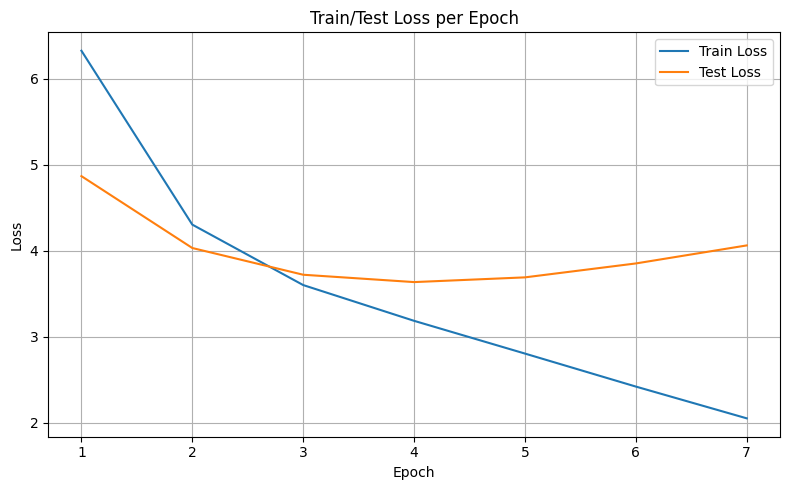

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1803
Epoch 1 Validation Loss: 4.8284


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2975
Epoch 2 Validation Loss: 4.0356


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6123
Epoch 3 Validation Loss: 3.7174


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1843
Epoch 4 Validation Loss: 3.6764


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7902
Epoch 5 Validation Loss: 3.7005


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3852
Epoch 6 Validation Loss: 3.8480


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0058
Epoch 7 Validation Loss: 4.0464
Early stopping triggered at epoch 7


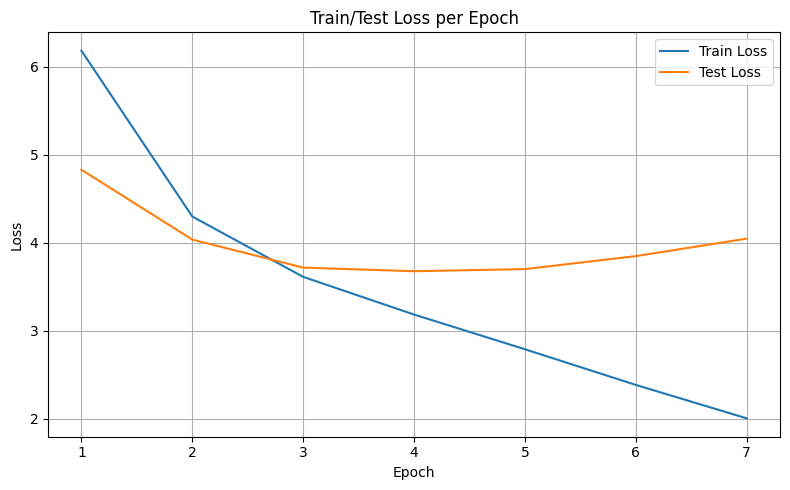

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2310
Epoch 1 Validation Loss: 4.7989


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2920
Epoch 2 Validation Loss: 4.0315


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6246
Epoch 3 Validation Loss: 3.7068


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2088
Epoch 4 Validation Loss: 3.6421


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8282
Epoch 5 Validation Loss: 3.7211


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4319
Epoch 6 Validation Loss: 3.7837


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0467
Epoch 7 Validation Loss: 4.0138
Early stopping triggered at epoch 7


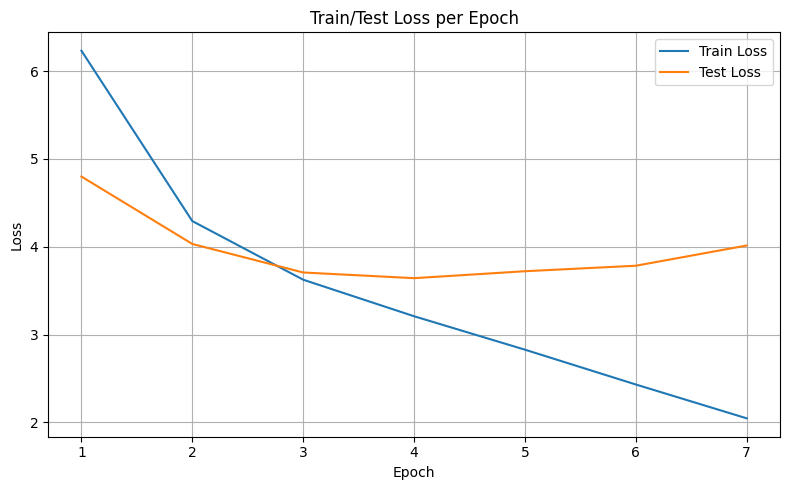

Trial 5/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2416
Epoch 1 Validation Loss: 4.7996


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2880
Epoch 2 Validation Loss: 4.0443


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6319
Epoch 3 Validation Loss: 3.7648


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2318
Epoch 4 Validation Loss: 3.6625


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8507
Epoch 5 Validation Loss: 3.7113


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4552
Epoch 6 Validation Loss: 3.8353


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0885
Epoch 7 Validation Loss: 4.0240
Early stopping triggered at epoch 7


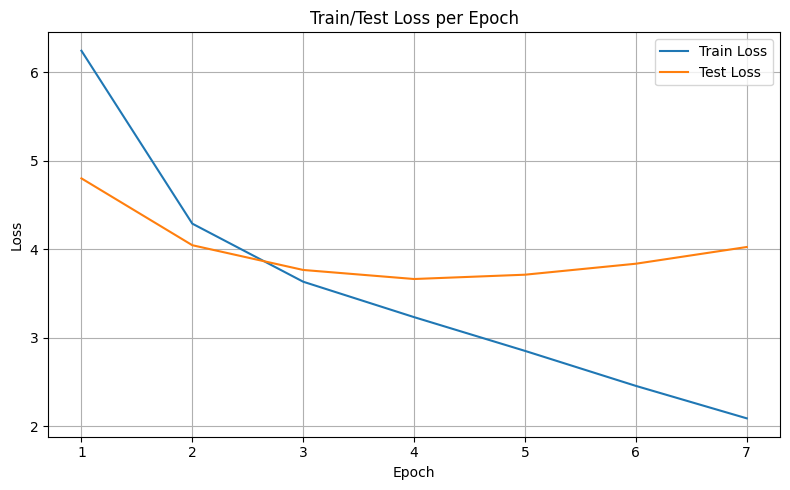

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2464
Epoch 1 Validation Loss: 4.8953


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2888
Epoch 2 Validation Loss: 4.0186


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6108
Epoch 3 Validation Loss: 3.7392


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2068
Epoch 4 Validation Loss: 3.6530


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8193
Epoch 5 Validation Loss: 3.6872


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3962
Epoch 6 Validation Loss: 3.8738


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0170
Epoch 7 Validation Loss: 4.0918
Early stopping triggered at epoch 7


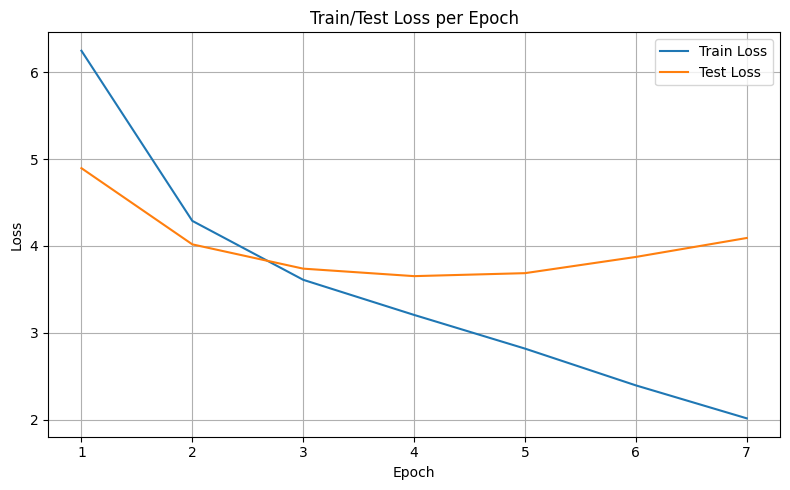

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2293
Epoch 1 Validation Loss: 4.8123


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2767
Epoch 2 Validation Loss: 3.9910


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5769
Epoch 3 Validation Loss: 3.6771


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1498
Epoch 4 Validation Loss: 3.6222


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7503
Epoch 5 Validation Loss: 3.7008


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3535
Epoch 6 Validation Loss: 3.7739


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9703
Epoch 7 Validation Loss: 4.1137
Early stopping triggered at epoch 7


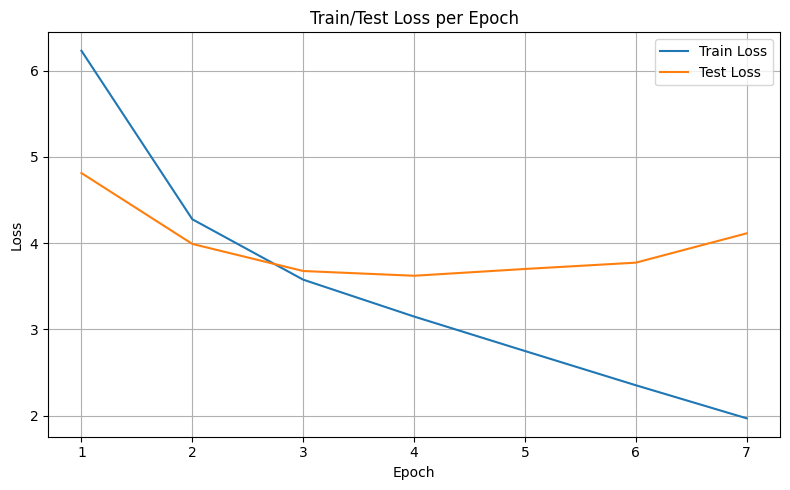

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2714
Epoch 1 Validation Loss: 4.8327


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3005
Epoch 2 Validation Loss: 4.0108


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6071
Epoch 3 Validation Loss: 3.7278


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1750
Epoch 4 Validation Loss: 3.6581


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7782
Epoch 5 Validation Loss: 3.6880


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3717
Epoch 6 Validation Loss: 3.8016


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9903
Epoch 7 Validation Loss: 4.0360
Early stopping triggered at epoch 7


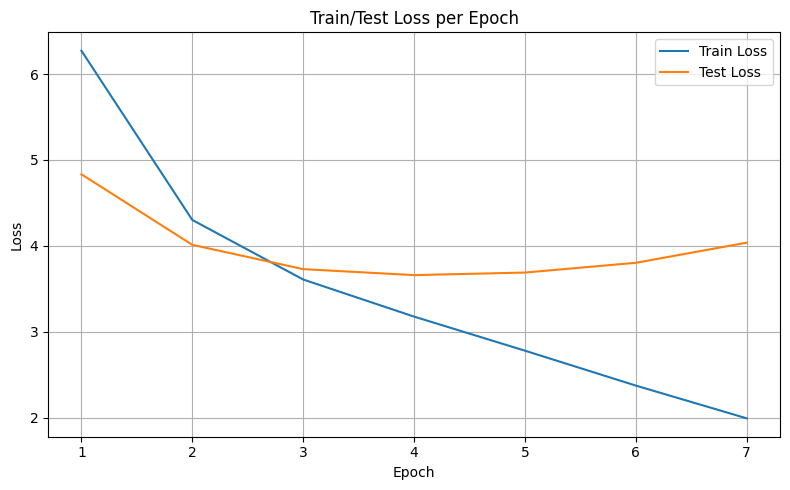

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2648
Epoch 1 Validation Loss: 4.8509


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2867
Epoch 2 Validation Loss: 4.0156


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5937
Epoch 3 Validation Loss: 3.7100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1836
Epoch 4 Validation Loss: 3.6461


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7996
Epoch 5 Validation Loss: 3.6913


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4046
Epoch 6 Validation Loss: 3.8400


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0299
Epoch 7 Validation Loss: 4.0570
Early stopping triggered at epoch 7


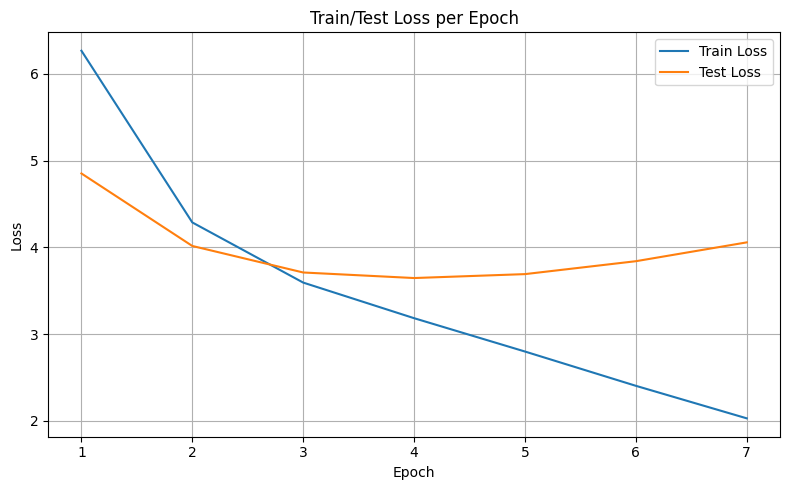

Trial 6/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 1024, 'dropout': 0.3}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2352
Epoch 1 Validation Loss: 4.8297


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2734
Epoch 2 Validation Loss: 4.0061


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6272
Epoch 3 Validation Loss: 3.7677


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2399
Epoch 4 Validation Loss: 3.6942


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8734
Epoch 5 Validation Loss: 3.7201


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4816
Epoch 6 Validation Loss: 3.8504


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0932
Epoch 7 Validation Loss: 4.0643
Early stopping triggered at epoch 7


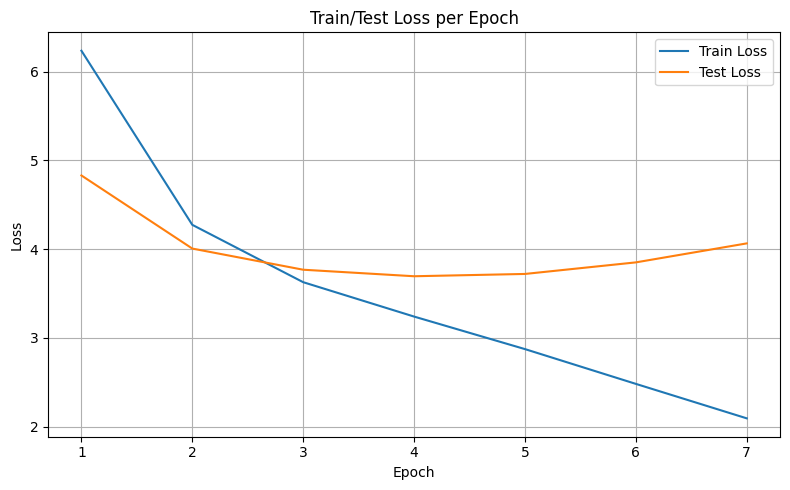

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2929
Epoch 1 Validation Loss: 4.8189


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2590
Epoch 2 Validation Loss: 4.0006


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6021
Epoch 3 Validation Loss: 3.7397


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2106
Epoch 4 Validation Loss: 3.6647


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8368
Epoch 5 Validation Loss: 3.7115


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4386
Epoch 6 Validation Loss: 3.8547


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0536
Epoch 7 Validation Loss: 4.0358
Early stopping triggered at epoch 7


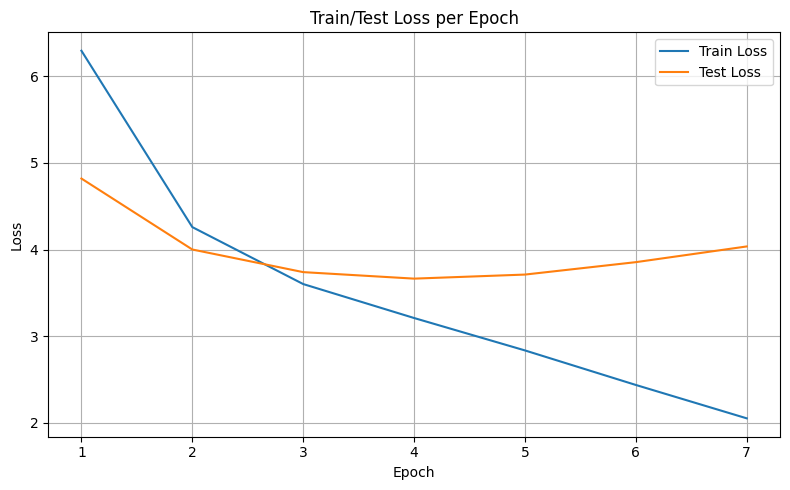

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3511
Epoch 1 Validation Loss: 4.8995


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3437
Epoch 2 Validation Loss: 4.0472


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6160
Epoch 3 Validation Loss: 3.7276


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2016
Epoch 4 Validation Loss: 3.6445


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8221
Epoch 5 Validation Loss: 3.6757


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4274
Epoch 6 Validation Loss: 3.8370


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0494
Epoch 7 Validation Loss: 4.0190
Early stopping triggered at epoch 7


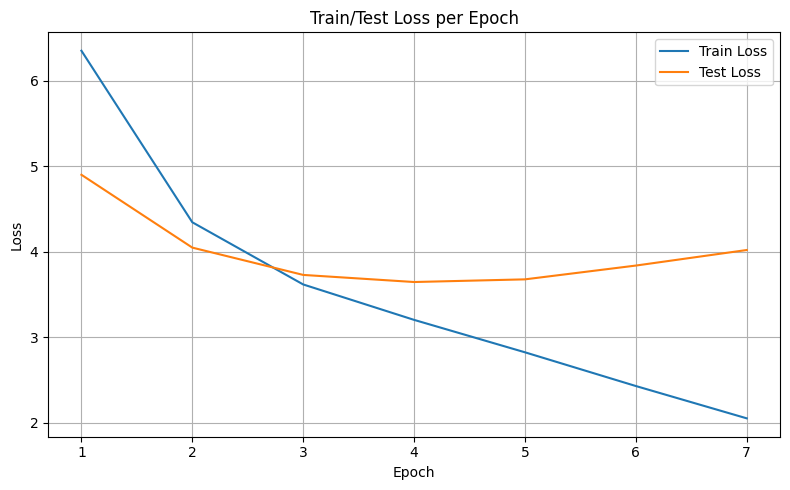

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2926
Epoch 1 Validation Loss: 4.8830


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3197
Epoch 2 Validation Loss: 4.0201


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6123
Epoch 3 Validation Loss: 3.7186


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1816
Epoch 4 Validation Loss: 3.6343


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7803
Epoch 5 Validation Loss: 3.6834


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3748
Epoch 6 Validation Loss: 3.8420


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9974
Epoch 7 Validation Loss: 4.1017
Early stopping triggered at epoch 7


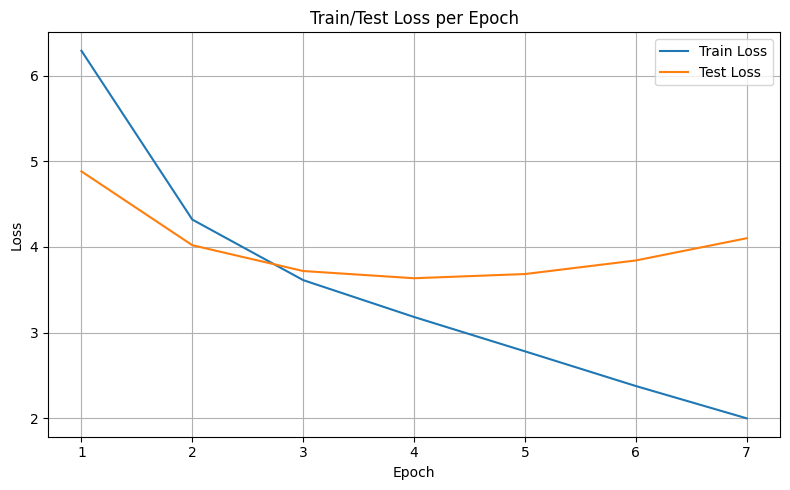

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2480
Epoch 1 Validation Loss: 4.8686


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3179
Epoch 2 Validation Loss: 4.0388


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6015
Epoch 3 Validation Loss: 3.7281


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1744
Epoch 4 Validation Loss: 3.6645


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7844
Epoch 5 Validation Loss: 3.6990


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3800
Epoch 6 Validation Loss: 3.8288


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0074
Epoch 7 Validation Loss: 4.0506
Early stopping triggered at epoch 7


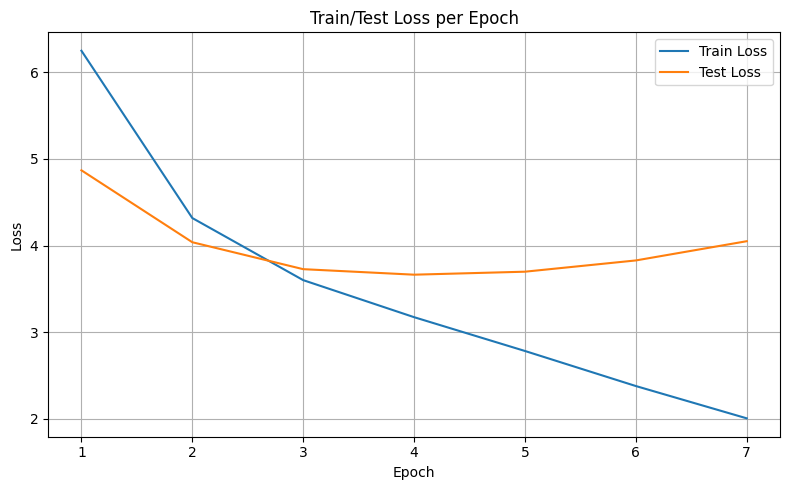

Trial 7/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 2048, 'dropout': 0.1}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1588
Epoch 1 Validation Loss: 4.7911


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2706
Epoch 2 Validation Loss: 4.0028


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5817
Epoch 3 Validation Loss: 3.7261


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1786
Epoch 4 Validation Loss: 3.6477


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7996
Epoch 5 Validation Loss: 3.7045


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4094
Epoch 6 Validation Loss: 3.8263


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0308
Epoch 7 Validation Loss: 4.0844
Early stopping triggered at epoch 7


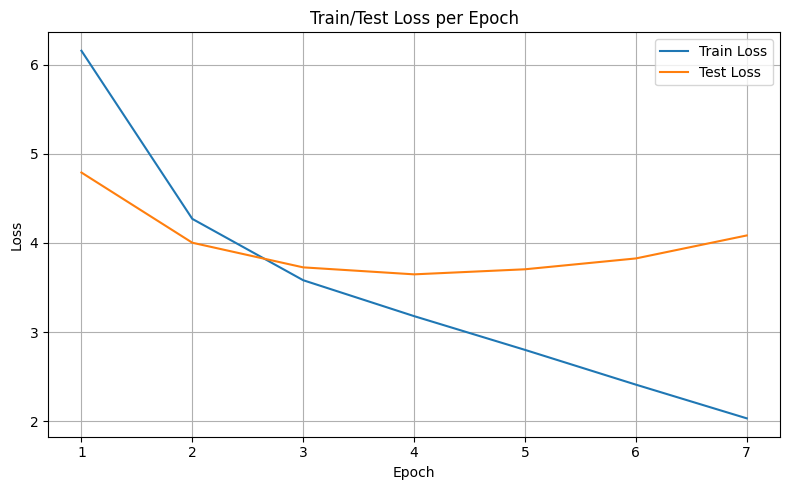

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2527
Epoch 1 Validation Loss: 4.8294


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2657
Epoch 2 Validation Loss: 4.0228


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6005
Epoch 3 Validation Loss: 3.7317


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1892
Epoch 4 Validation Loss: 3.6317


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8102
Epoch 5 Validation Loss: 3.7043


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4213
Epoch 6 Validation Loss: 3.8079


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0420
Epoch 7 Validation Loss: 4.0864
Early stopping triggered at epoch 7


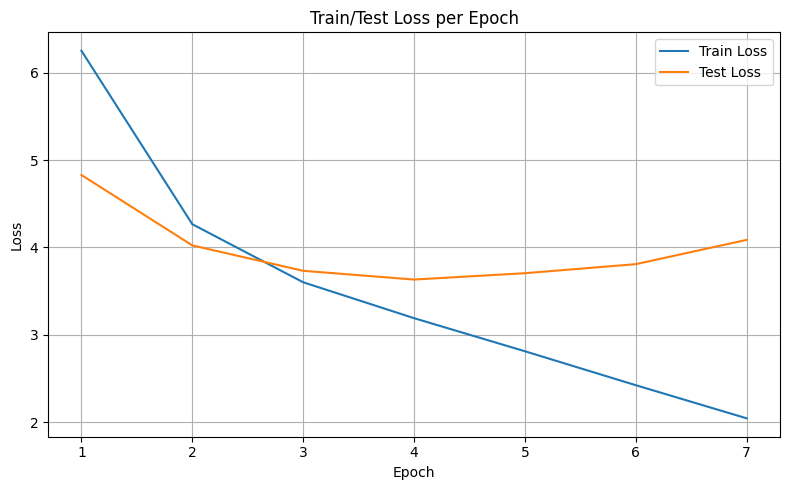

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2279
Epoch 1 Validation Loss: 4.7757


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2348
Epoch 2 Validation Loss: 4.0090


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5870
Epoch 3 Validation Loss: 3.7362


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1994
Epoch 4 Validation Loss: 3.6339


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8225
Epoch 5 Validation Loss: 3.6898


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4268
Epoch 6 Validation Loss: 3.8045


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0432
Epoch 7 Validation Loss: 3.9934
Early stopping triggered at epoch 7


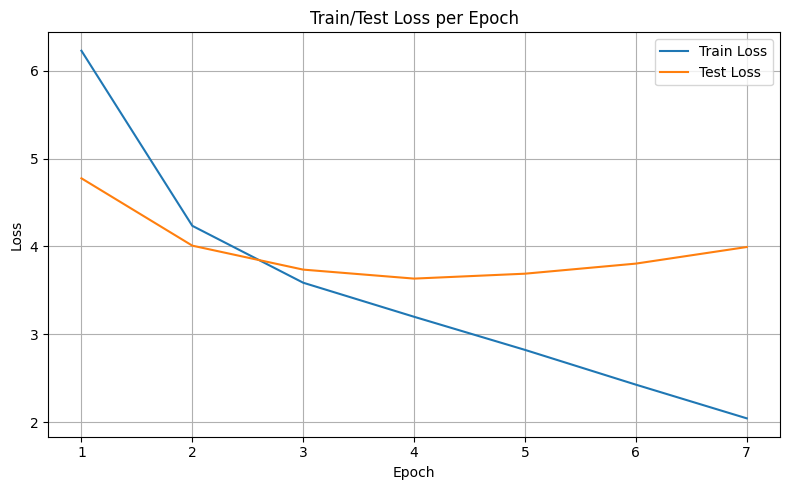

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2014
Epoch 1 Validation Loss: 4.7902


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2762
Epoch 2 Validation Loss: 4.0143


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5949
Epoch 3 Validation Loss: 3.7144


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1797
Epoch 4 Validation Loss: 3.6141


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7914
Epoch 5 Validation Loss: 3.7062


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4073
Epoch 6 Validation Loss: 3.7782


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0214
Epoch 7 Validation Loss: 4.0452
Early stopping triggered at epoch 7


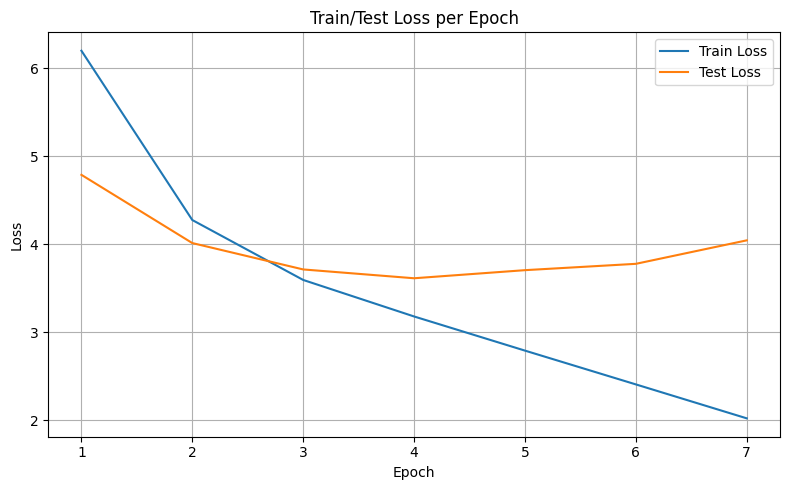

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2112
Epoch 1 Validation Loss: 4.8295


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2833
Epoch 2 Validation Loss: 4.0344


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6296
Epoch 3 Validation Loss: 3.7585


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2255
Epoch 4 Validation Loss: 3.6461


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8325
Epoch 5 Validation Loss: 3.6867


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4259
Epoch 6 Validation Loss: 3.8278


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0563
Epoch 7 Validation Loss: 4.0216
Early stopping triggered at epoch 7


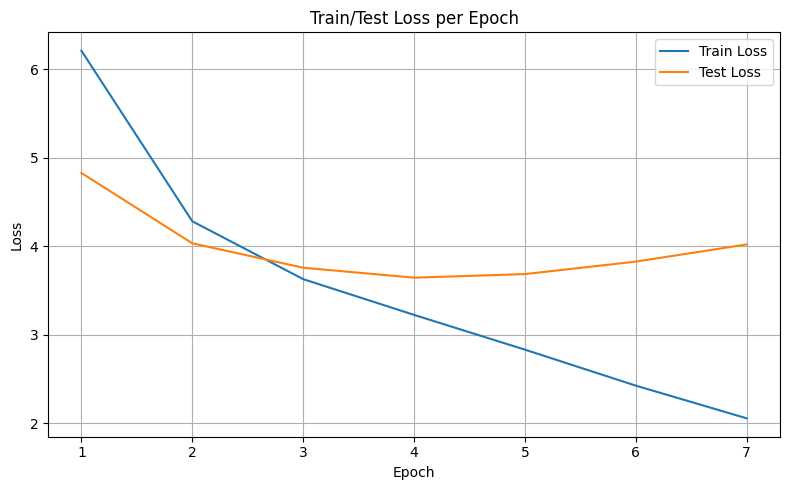

Trial 8/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 2048, 'dropout': 0.2}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2418
Epoch 1 Validation Loss: 4.8148


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2812
Epoch 2 Validation Loss: 4.0268


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6227
Epoch 3 Validation Loss: 3.7320


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2033
Epoch 4 Validation Loss: 3.6560


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8092
Epoch 5 Validation Loss: 3.7036


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4015
Epoch 6 Validation Loss: 3.8825


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0308
Epoch 7 Validation Loss: 4.0604
Early stopping triggered at epoch 7


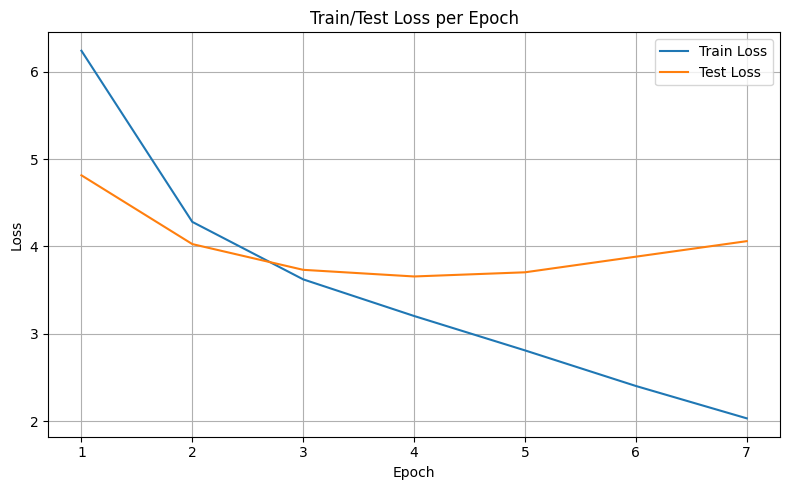

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2088
Epoch 1 Validation Loss: 4.7968


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2790
Epoch 2 Validation Loss: 4.0112


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6030
Epoch 3 Validation Loss: 3.7190


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1883
Epoch 4 Validation Loss: 3.6582


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8011
Epoch 5 Validation Loss: 3.6938


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4026
Epoch 6 Validation Loss: 3.8062


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0161
Epoch 7 Validation Loss: 4.0191
Early stopping triggered at epoch 7


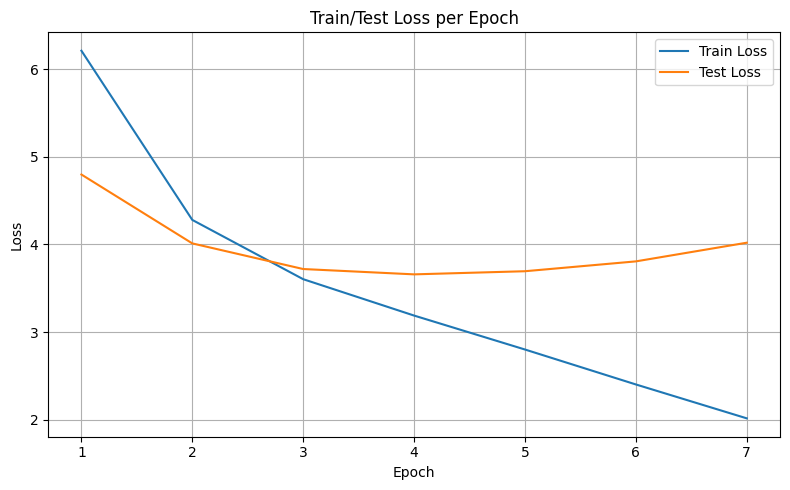

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2614
Epoch 1 Validation Loss: 4.8198


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3026
Epoch 2 Validation Loss: 4.0291


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6146
Epoch 3 Validation Loss: 3.7368


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1899
Epoch 4 Validation Loss: 3.6452


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8021
Epoch 5 Validation Loss: 3.6942


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4058
Epoch 6 Validation Loss: 3.8675


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0283
Epoch 7 Validation Loss: 4.0912
Early stopping triggered at epoch 7


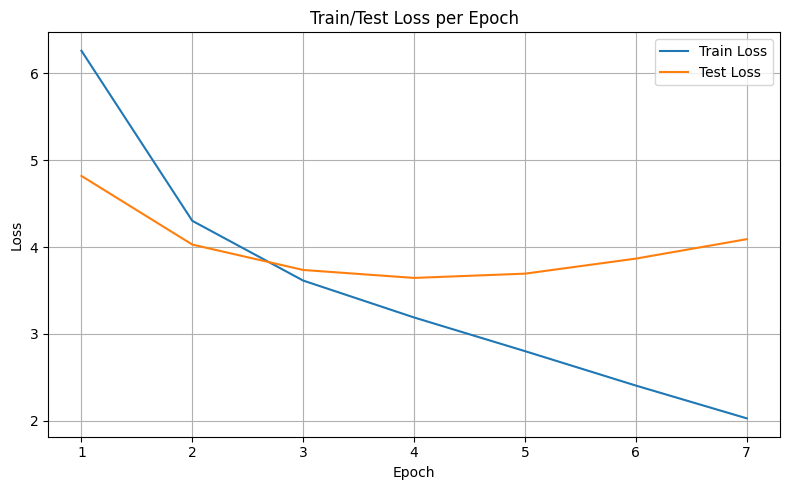

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2532
Epoch 1 Validation Loss: 4.8295


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2830
Epoch 2 Validation Loss: 4.0049


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5861
Epoch 3 Validation Loss: 3.7213


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1803
Epoch 4 Validation Loss: 3.6539


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8040
Epoch 5 Validation Loss: 3.6903


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3997
Epoch 6 Validation Loss: 3.8501


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0236
Epoch 7 Validation Loss: 4.0259
Early stopping triggered at epoch 7


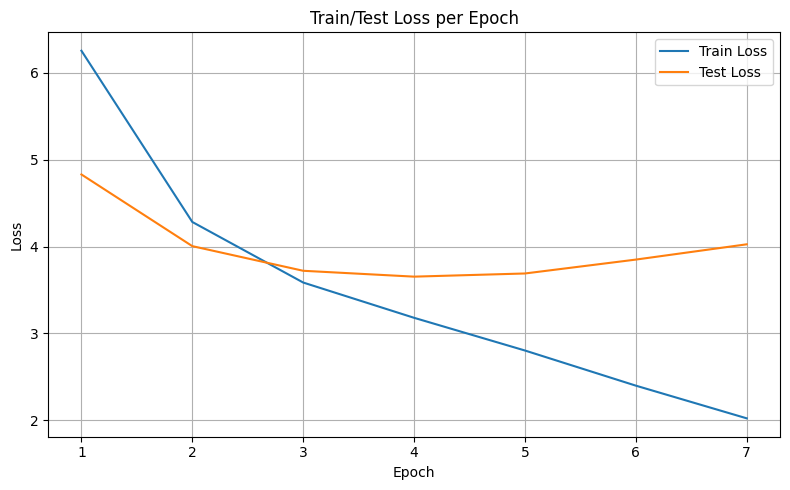

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2201
Epoch 1 Validation Loss: 4.7847


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2459
Epoch 2 Validation Loss: 3.9947


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5732
Epoch 3 Validation Loss: 3.7152


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1623
Epoch 4 Validation Loss: 3.6323


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7905
Epoch 5 Validation Loss: 3.7058


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4017
Epoch 6 Validation Loss: 3.8441


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0481
Epoch 7 Validation Loss: 4.0183
Early stopping triggered at epoch 7


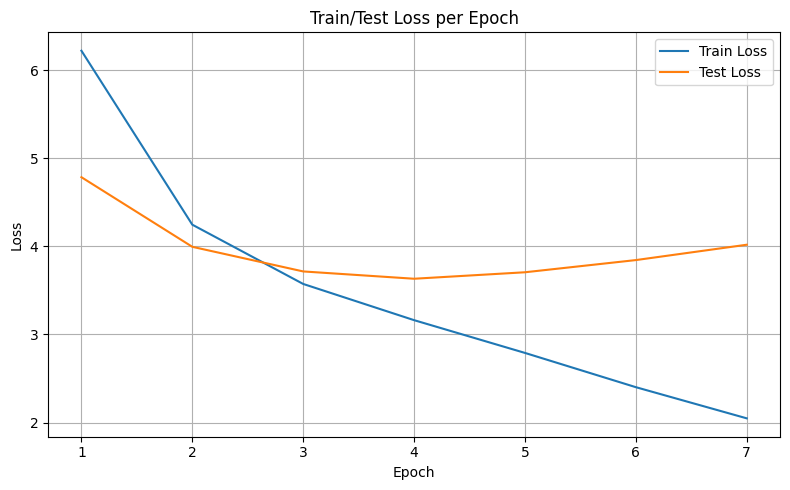

Trial 9/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 4, 'd_ff': 2048, 'dropout': 0.3}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1902
Epoch 1 Validation Loss: 4.7900


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2660
Epoch 2 Validation Loss: 3.9832


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5734
Epoch 3 Validation Loss: 3.6882


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1417
Epoch 4 Validation Loss: 3.6161


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7461
Epoch 5 Validation Loss: 3.7004


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3445
Epoch 6 Validation Loss: 3.8745


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9807
Epoch 7 Validation Loss: 4.0714
Early stopping triggered at epoch 7


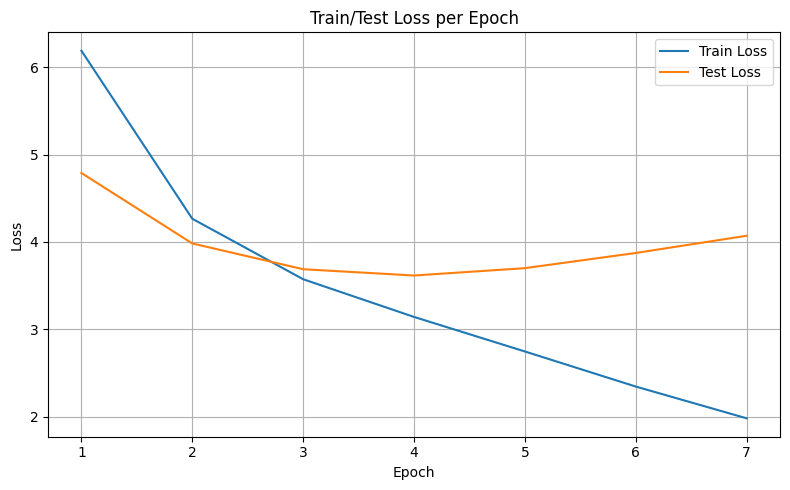

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2491
Epoch 1 Validation Loss: 4.8021


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2575
Epoch 2 Validation Loss: 4.0123


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6088
Epoch 3 Validation Loss: 3.7323


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2008
Epoch 4 Validation Loss: 3.6579


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8008
Epoch 5 Validation Loss: 3.7115


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4017
Epoch 6 Validation Loss: 3.7899


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0131
Epoch 7 Validation Loss: 4.0476
Early stopping triggered at epoch 7


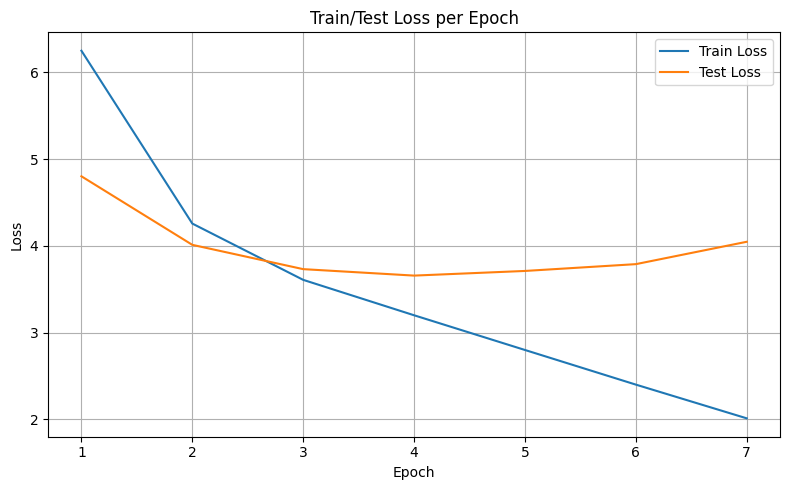

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2366
Epoch 1 Validation Loss: 4.8366


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2889
Epoch 2 Validation Loss: 4.0172


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5942
Epoch 3 Validation Loss: 3.6966


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1616
Epoch 4 Validation Loss: 3.6474


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7691
Epoch 5 Validation Loss: 3.6677


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3800
Epoch 6 Validation Loss: 3.7964


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0026
Epoch 7 Validation Loss: 4.0502
Early stopping triggered at epoch 7


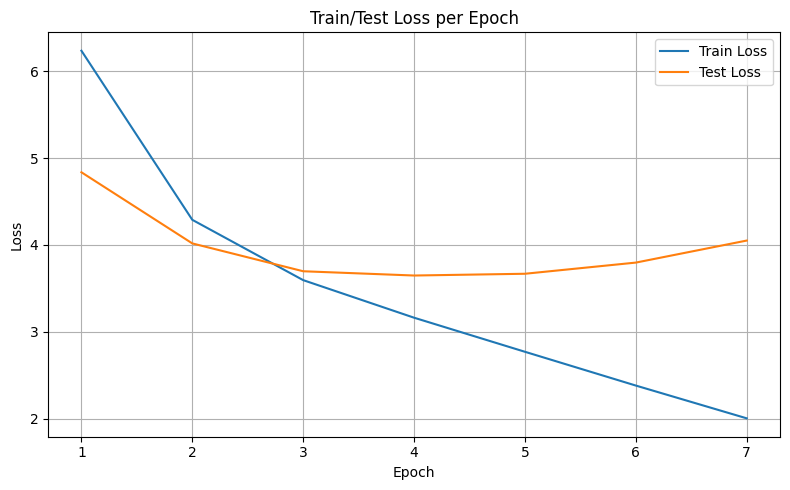

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2583
Epoch 1 Validation Loss: 4.8034


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2654
Epoch 2 Validation Loss: 4.0080


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5632
Epoch 3 Validation Loss: 3.6993


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1378
Epoch 4 Validation Loss: 3.6128


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7625
Epoch 5 Validation Loss: 3.6923


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3688
Epoch 6 Validation Loss: 3.8190


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0012
Epoch 7 Validation Loss: 4.0984
Early stopping triggered at epoch 7


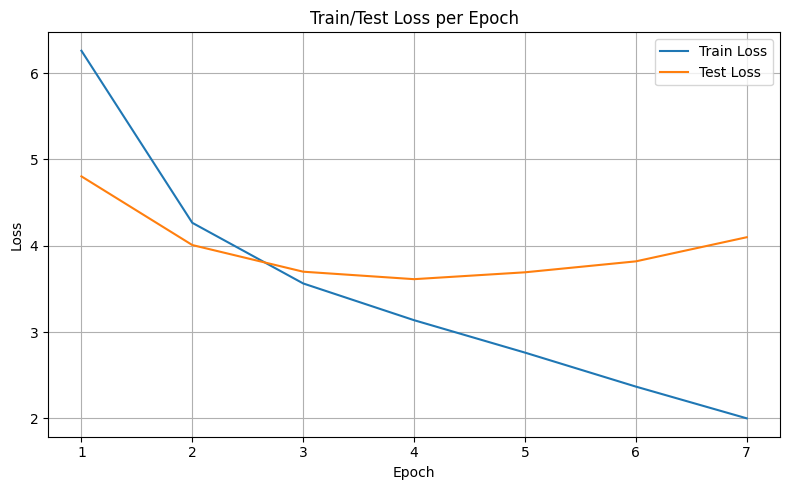

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2209
Epoch 1 Validation Loss: 4.7769


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2523
Epoch 2 Validation Loss: 4.0135


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6035
Epoch 3 Validation Loss: 3.7370


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.2003
Epoch 4 Validation Loss: 3.6629


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8150
Epoch 5 Validation Loss: 3.6742


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4211
Epoch 6 Validation Loss: 3.7917


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0553
Epoch 7 Validation Loss: 4.0129
Early stopping triggered at epoch 7


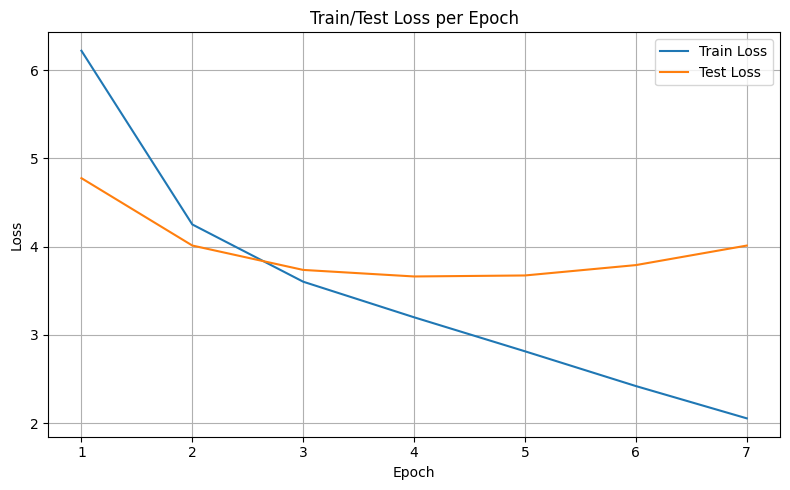

Trial 10/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 512, 'dropout': 0.1}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3698
Epoch 1 Validation Loss: 4.9082


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3147
Epoch 2 Validation Loss: 4.0163


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6001
Epoch 3 Validation Loss: 3.7167


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1935
Epoch 4 Validation Loss: 3.6478


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7967
Epoch 5 Validation Loss: 3.6968


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3711
Epoch 6 Validation Loss: 3.8506


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9787
Epoch 7 Validation Loss: 4.1120
Early stopping triggered at epoch 7


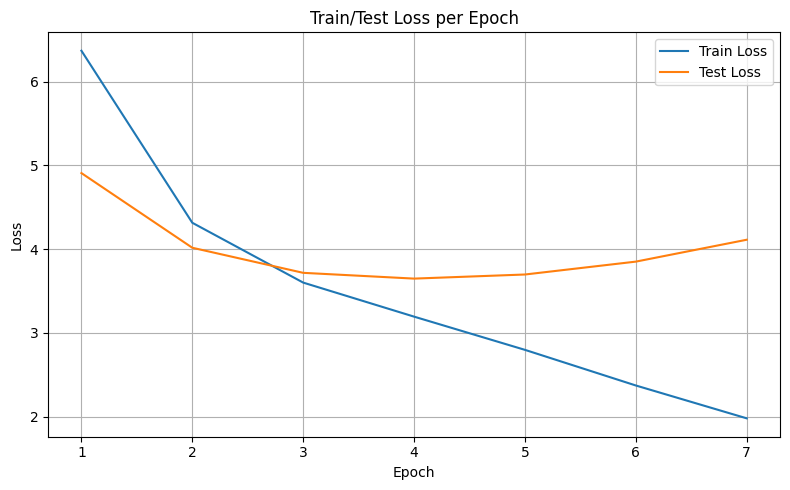

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3724
Epoch 1 Validation Loss: 4.9093


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3291
Epoch 2 Validation Loss: 4.0248


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5971
Epoch 3 Validation Loss: 3.7253


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1913
Epoch 4 Validation Loss: 3.6519


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7993
Epoch 5 Validation Loss: 3.7163


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3895
Epoch 6 Validation Loss: 3.8895


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9923
Epoch 7 Validation Loss: 4.1000
Early stopping triggered at epoch 7


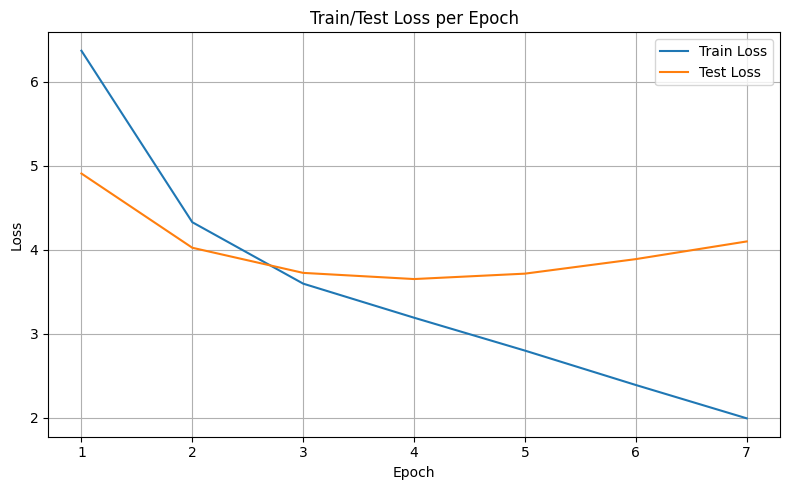

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3232
Epoch 1 Validation Loss: 4.8635


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2980
Epoch 2 Validation Loss: 3.9994


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6019
Epoch 3 Validation Loss: 3.7115


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1880
Epoch 4 Validation Loss: 3.6451


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7974
Epoch 5 Validation Loss: 3.7101


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3789
Epoch 6 Validation Loss: 3.8398


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9795
Epoch 7 Validation Loss: 4.1102
Early stopping triggered at epoch 7


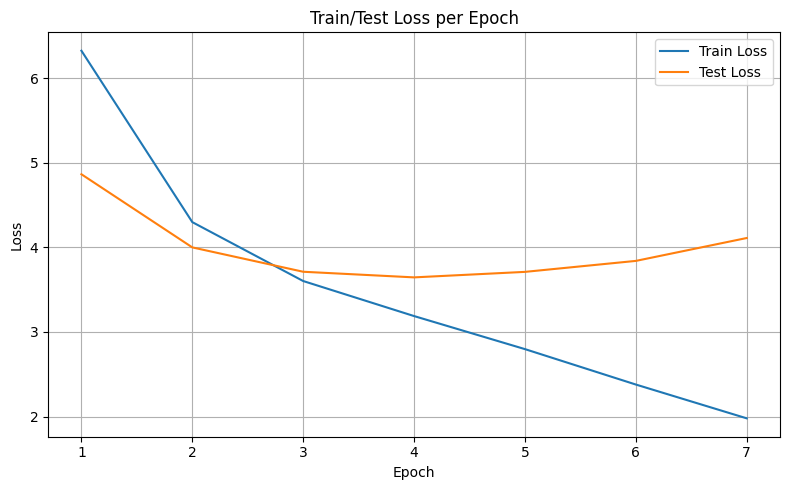

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3311
Epoch 1 Validation Loss: 4.9205


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3488
Epoch 2 Validation Loss: 4.0360


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6106
Epoch 3 Validation Loss: 3.7250


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1882
Epoch 4 Validation Loss: 3.6475


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8013
Epoch 5 Validation Loss: 3.7361


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3900
Epoch 6 Validation Loss: 3.8584


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9962
Epoch 7 Validation Loss: 4.1123
Early stopping triggered at epoch 7


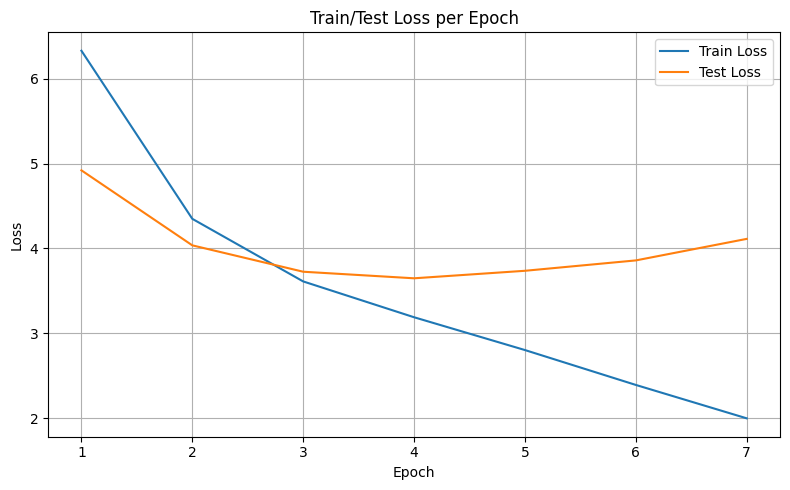

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.4066
Epoch 1 Validation Loss: 4.8949


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3145
Epoch 2 Validation Loss: 4.0011


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5700
Epoch 3 Validation Loss: 3.6968


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1480
Epoch 4 Validation Loss: 3.6415


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7471
Epoch 5 Validation Loss: 3.6966


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3322
Epoch 6 Validation Loss: 3.8655


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9477
Epoch 7 Validation Loss: 4.1148
Early stopping triggered at epoch 7


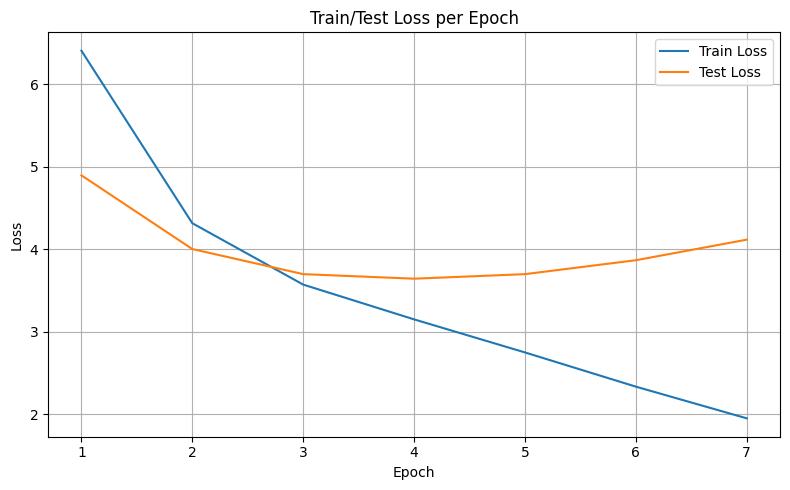

Trial 11/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 512, 'dropout': 0.2}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3208
Epoch 1 Validation Loss: 4.8218


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2804
Epoch 2 Validation Loss: 3.9939


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5682
Epoch 3 Validation Loss: 3.7103


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1726
Epoch 4 Validation Loss: 3.6628


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7945
Epoch 5 Validation Loss: 3.7325


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3812
Epoch 6 Validation Loss: 3.8762


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9934
Epoch 7 Validation Loss: 4.1014
Early stopping triggered at epoch 7


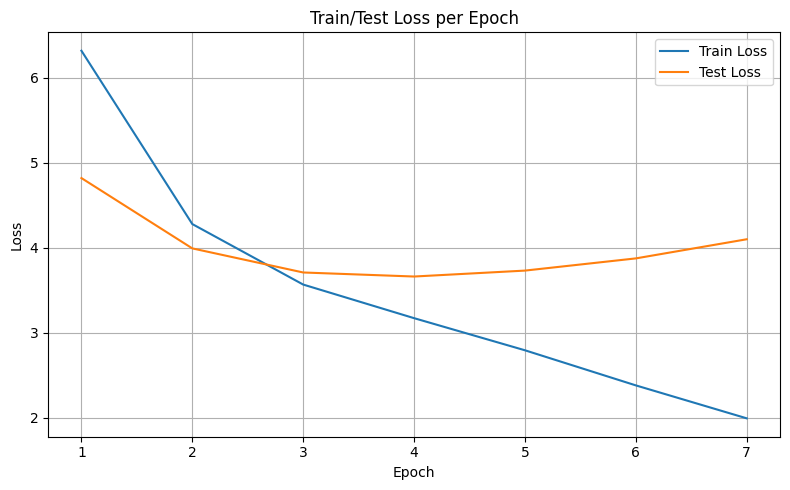

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3987
Epoch 1 Validation Loss: 4.8776


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2944
Epoch 2 Validation Loss: 4.0058


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5874
Epoch 3 Validation Loss: 3.7179


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1750
Epoch 4 Validation Loss: 3.6543


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7773
Epoch 5 Validation Loss: 3.7195


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3574
Epoch 6 Validation Loss: 3.8841


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9621
Epoch 7 Validation Loss: 4.0948
Early stopping triggered at epoch 7


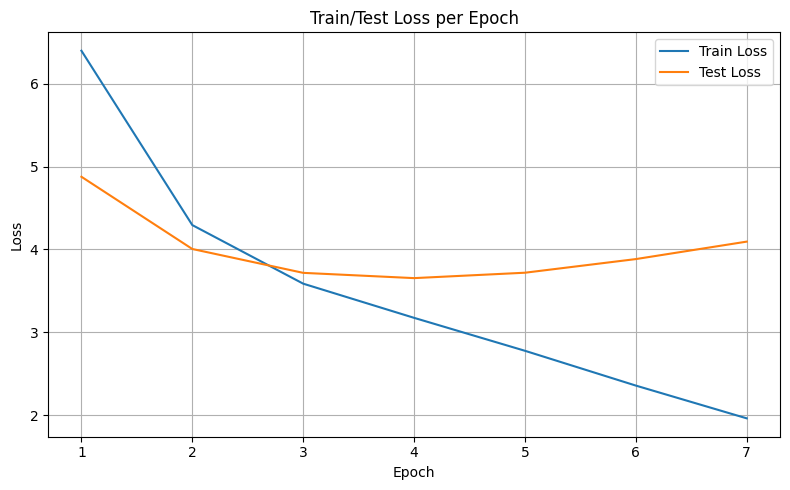

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.4053
Epoch 1 Validation Loss: 4.8618


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3109
Epoch 2 Validation Loss: 4.0290


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5949
Epoch 3 Validation Loss: 3.7086


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1791
Epoch 4 Validation Loss: 3.6612


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7823
Epoch 5 Validation Loss: 3.7080


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3648
Epoch 6 Validation Loss: 3.8393


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9602
Epoch 7 Validation Loss: 4.0574
Early stopping triggered at epoch 7


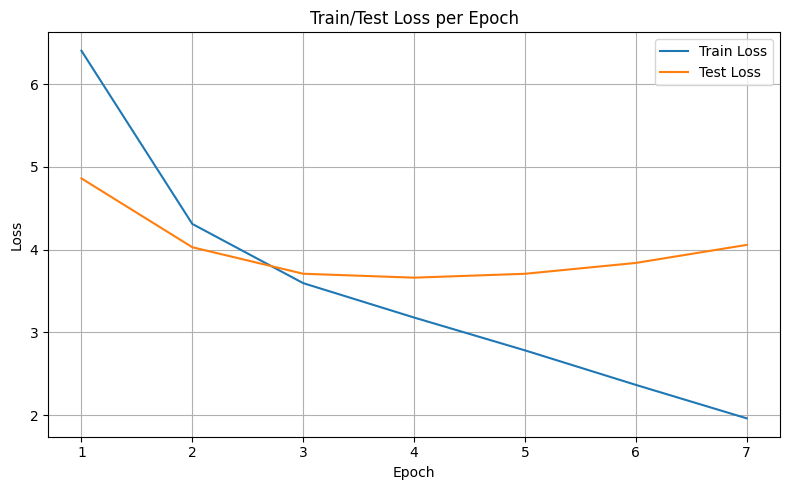

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2861
Epoch 1 Validation Loss: 4.8417


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2930
Epoch 2 Validation Loss: 3.9943


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5834
Epoch 3 Validation Loss: 3.7245


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1567
Epoch 4 Validation Loss: 3.6457


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7508
Epoch 5 Validation Loss: 3.7259


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3308
Epoch 6 Validation Loss: 3.8899


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9476
Epoch 7 Validation Loss: 4.1141
Early stopping triggered at epoch 7


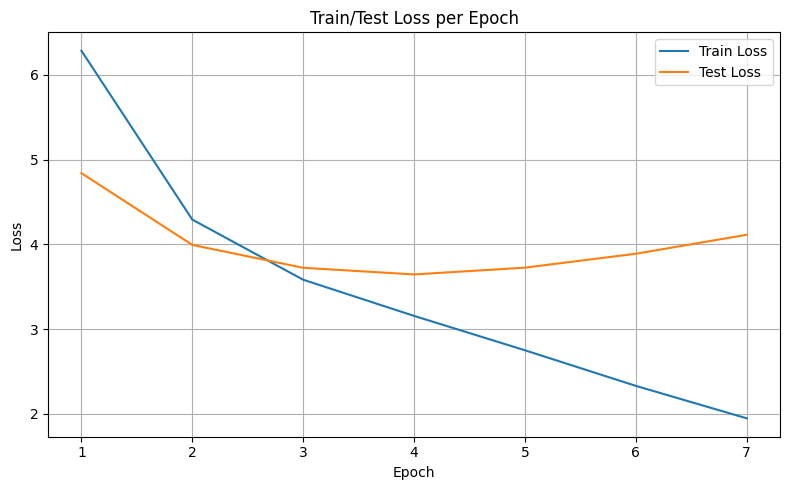

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3882
Epoch 1 Validation Loss: 4.8980


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3152
Epoch 2 Validation Loss: 3.9993


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5814
Epoch 3 Validation Loss: 3.6800


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1676
Epoch 4 Validation Loss: 3.6129


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7674
Epoch 5 Validation Loss: 3.6724


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3444
Epoch 6 Validation Loss: 3.8637


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9519
Epoch 7 Validation Loss: 4.1050
Early stopping triggered at epoch 7


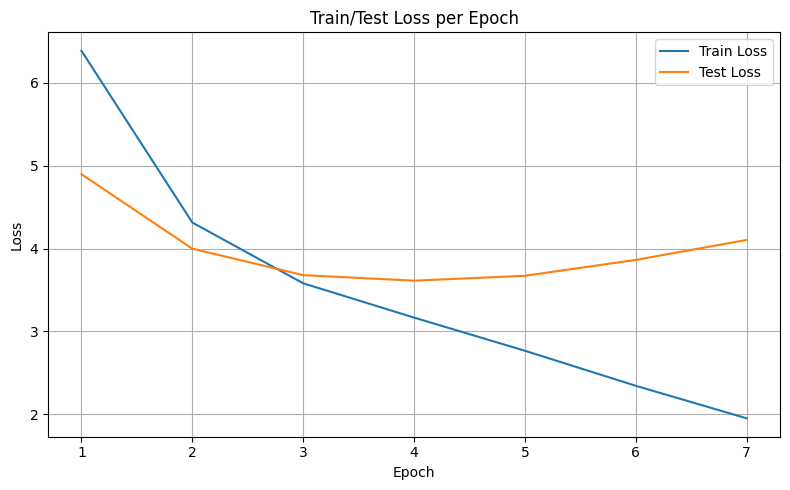

Trial 12/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 512, 'dropout': 0.3}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2746
Epoch 1 Validation Loss: 4.8675


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3219
Epoch 2 Validation Loss: 4.0143


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5979
Epoch 3 Validation Loss: 3.7080


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1705
Epoch 4 Validation Loss: 3.6242


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7690
Epoch 5 Validation Loss: 3.6991


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3511
Epoch 6 Validation Loss: 3.8669


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9524
Epoch 7 Validation Loss: 4.1023
Early stopping triggered at epoch 7


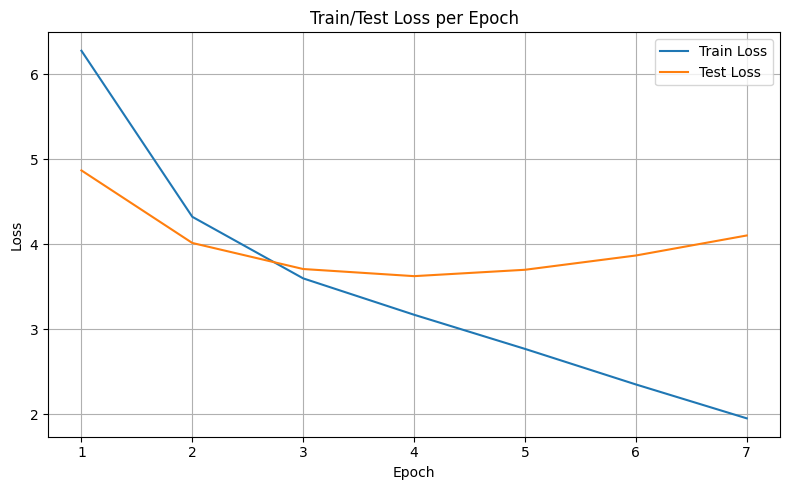

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2852
Epoch 1 Validation Loss: 4.8526


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3094
Epoch 2 Validation Loss: 4.0183


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6024
Epoch 3 Validation Loss: 3.7348


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1961
Epoch 4 Validation Loss: 3.6714


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8254
Epoch 5 Validation Loss: 3.7424


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4189
Epoch 6 Validation Loss: 3.9103


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0355
Epoch 7 Validation Loss: 4.1186
Early stopping triggered at epoch 7


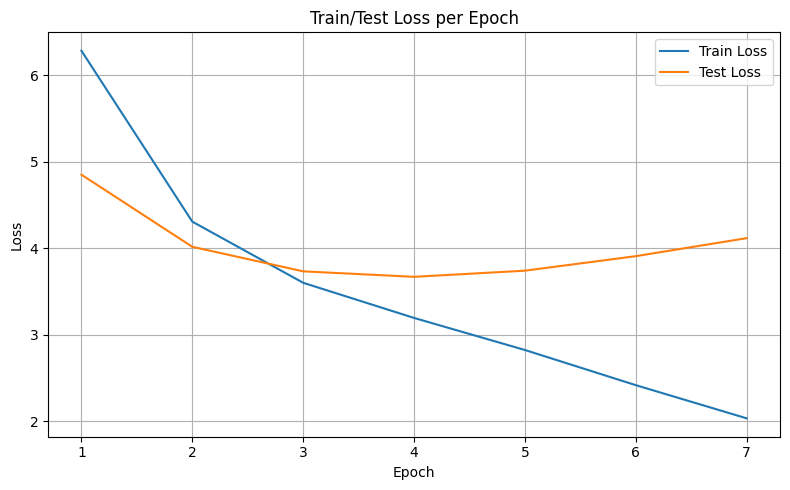

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2965
Epoch 1 Validation Loss: 4.8807


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2967
Epoch 2 Validation Loss: 4.0038


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5687
Epoch 3 Validation Loss: 3.7104


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1722
Epoch 4 Validation Loss: 3.6674


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7940
Epoch 5 Validation Loss: 3.7434


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3915
Epoch 6 Validation Loss: 3.8993


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0073
Epoch 7 Validation Loss: 4.1452
Early stopping triggered at epoch 7


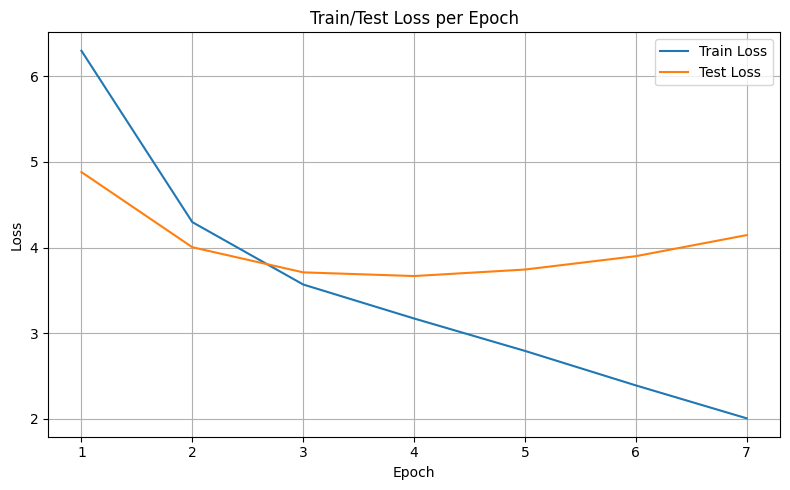

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3039
Epoch 1 Validation Loss: 4.9189


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3515
Epoch 2 Validation Loss: 4.0233


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6024
Epoch 3 Validation Loss: 3.7167


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1773
Epoch 4 Validation Loss: 3.6322


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7812
Epoch 5 Validation Loss: 3.6775


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3590
Epoch 6 Validation Loss: 3.8918


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9671
Epoch 7 Validation Loss: 4.0972
Early stopping triggered at epoch 7


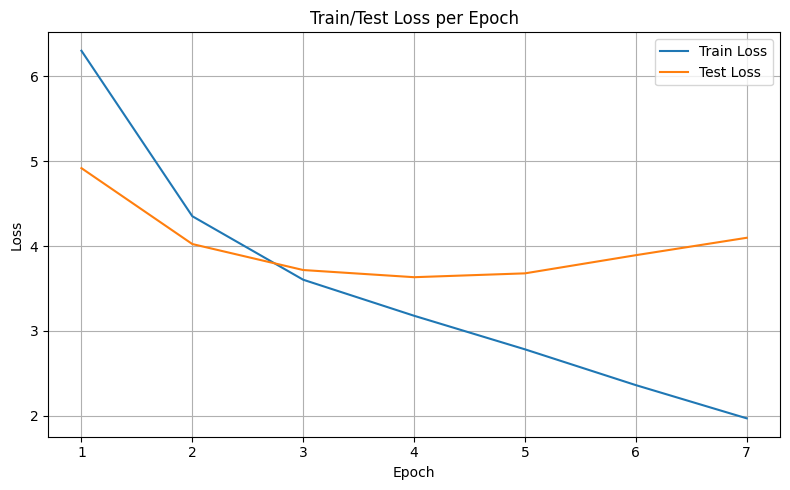

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2821
Epoch 1 Validation Loss: 4.8756


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2906
Epoch 2 Validation Loss: 4.0235


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5973
Epoch 3 Validation Loss: 3.7130


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1830
Epoch 4 Validation Loss: 3.6403


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7873
Epoch 5 Validation Loss: 3.7255


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3766
Epoch 6 Validation Loss: 3.8569


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9870
Epoch 7 Validation Loss: 4.0954
Early stopping triggered at epoch 7


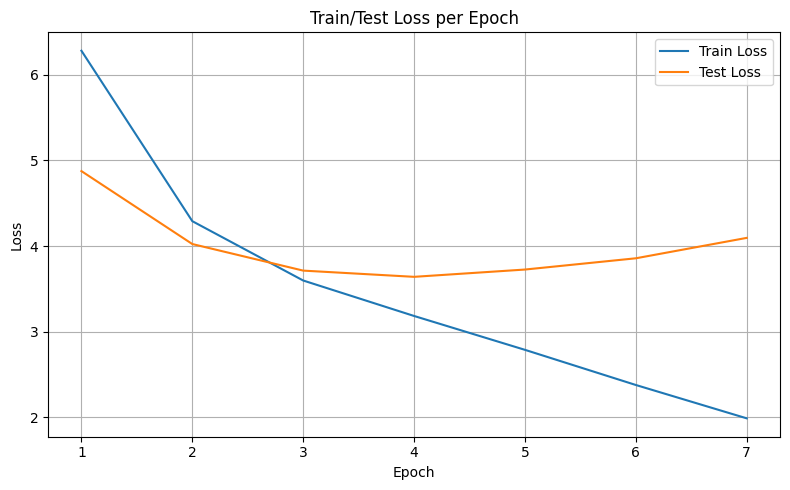

Trial 13/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.1}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3118
Epoch 1 Validation Loss: 4.8483


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2883
Epoch 2 Validation Loss: 3.9978


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5742
Epoch 3 Validation Loss: 3.6827


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1414
Epoch 4 Validation Loss: 3.6284


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7411
Epoch 5 Validation Loss: 3.6935


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3307
Epoch 6 Validation Loss: 3.8623


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9324
Epoch 7 Validation Loss: 4.1186
Early stopping triggered at epoch 7


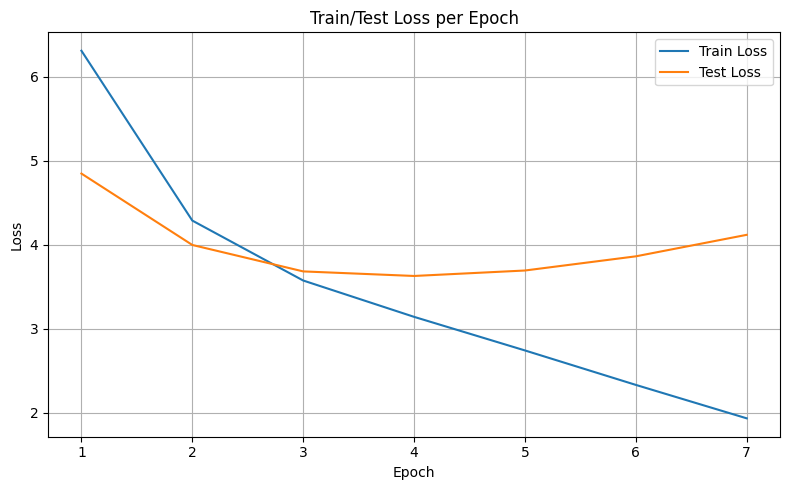

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2537
Epoch 1 Validation Loss: 4.8542


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3041
Epoch 2 Validation Loss: 4.0048


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5835
Epoch 3 Validation Loss: 3.6985


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1529
Epoch 4 Validation Loss: 3.6245


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7511
Epoch 5 Validation Loss: 3.7042


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3387
Epoch 6 Validation Loss: 3.8709


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9467
Epoch 7 Validation Loss: 4.1247
Early stopping triggered at epoch 7


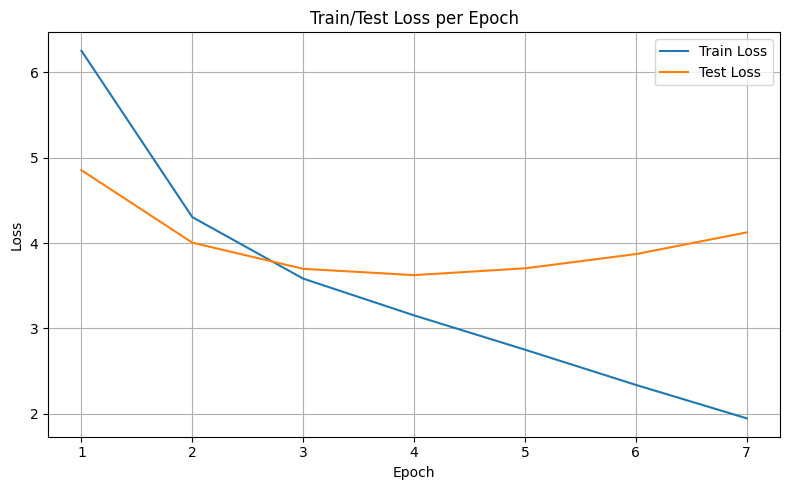

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3060
Epoch 1 Validation Loss: 4.8705


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2781
Epoch 2 Validation Loss: 3.9921


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5775
Epoch 3 Validation Loss: 3.7075


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1822
Epoch 4 Validation Loss: 3.6447


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7995
Epoch 5 Validation Loss: 3.6597


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4022
Epoch 6 Validation Loss: 3.8876


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0101
Epoch 7 Validation Loss: 4.1064
Early stopping triggered at epoch 7


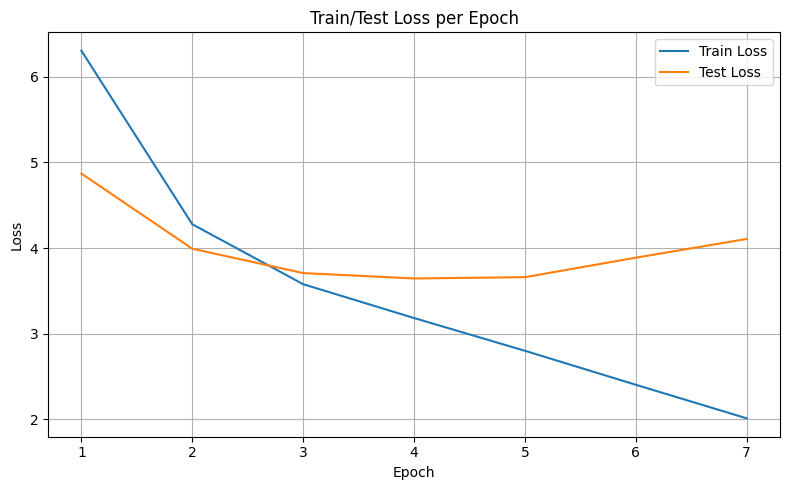

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2551
Epoch 1 Validation Loss: 4.8679


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2806
Epoch 2 Validation Loss: 3.9745


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5625
Epoch 3 Validation Loss: 3.7018


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1531
Epoch 4 Validation Loss: 3.6342


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7639
Epoch 5 Validation Loss: 3.6755


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3479
Epoch 6 Validation Loss: 3.8511


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9525
Epoch 7 Validation Loss: 4.0468
Early stopping triggered at epoch 7


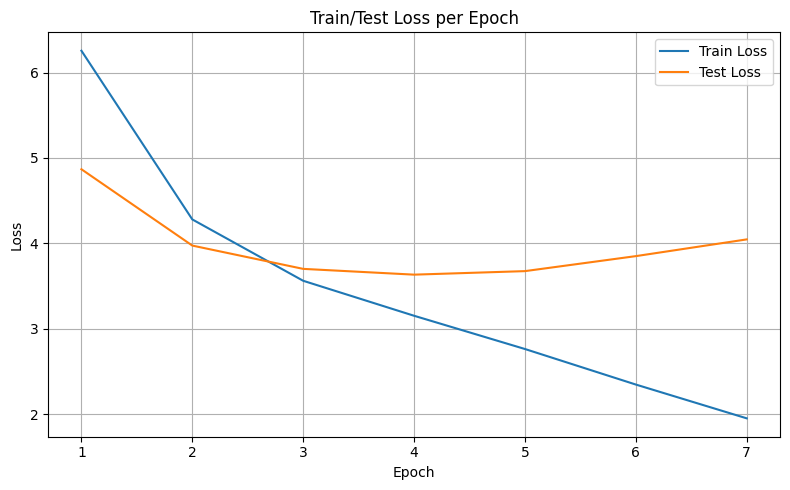

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2408
Epoch 1 Validation Loss: 4.8725


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3030
Epoch 2 Validation Loss: 3.9857


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5688
Epoch 3 Validation Loss: 3.6987


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1403
Epoch 4 Validation Loss: 3.6424


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7413
Epoch 5 Validation Loss: 3.6660


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3161
Epoch 6 Validation Loss: 3.8414


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9330
Epoch 7 Validation Loss: 4.1014
Early stopping triggered at epoch 7


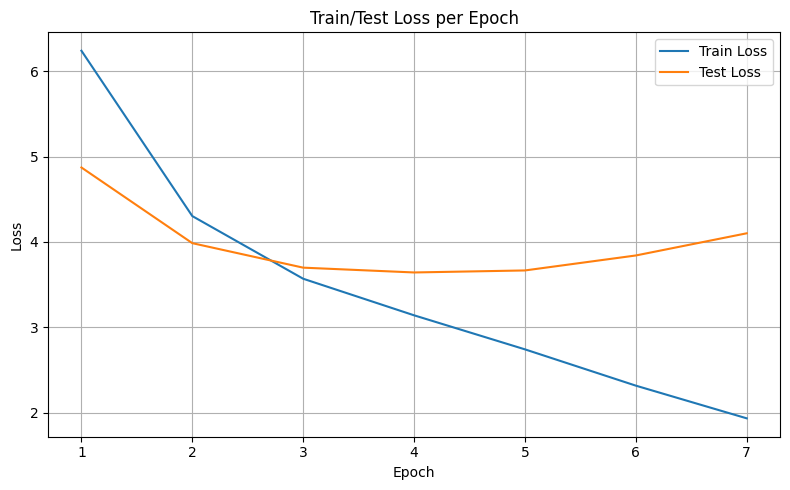

Trial 14/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2708
Epoch 1 Validation Loss: 4.8579


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2904
Epoch 2 Validation Loss: 3.9797


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5849
Epoch 3 Validation Loss: 3.6850


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1662
Epoch 4 Validation Loss: 3.6420


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7737
Epoch 5 Validation Loss: 3.6921


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3564
Epoch 6 Validation Loss: 3.9075


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9625
Epoch 7 Validation Loss: 4.1183
Early stopping triggered at epoch 7


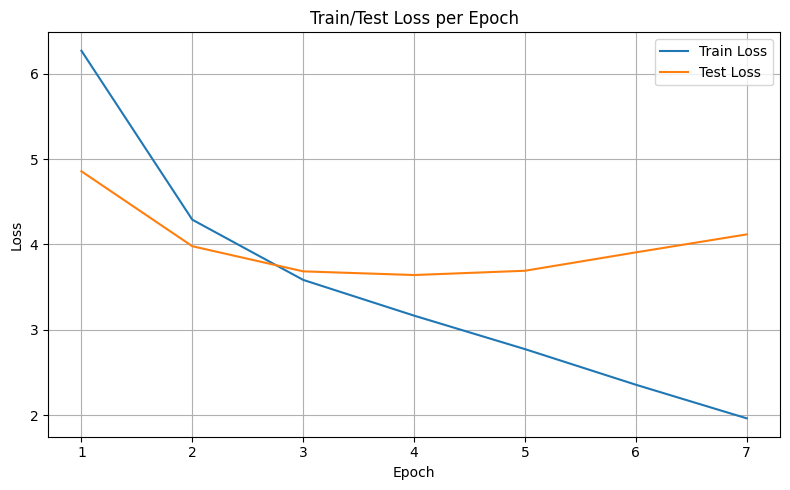

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2347
Epoch 1 Validation Loss: 4.8492


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2664
Epoch 2 Validation Loss: 3.9921


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5852
Epoch 3 Validation Loss: 3.7384


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1909
Epoch 4 Validation Loss: 3.6731


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8057
Epoch 5 Validation Loss: 3.7190


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4080
Epoch 6 Validation Loss: 3.8961


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0114
Epoch 7 Validation Loss: 4.0690
Early stopping triggered at epoch 7


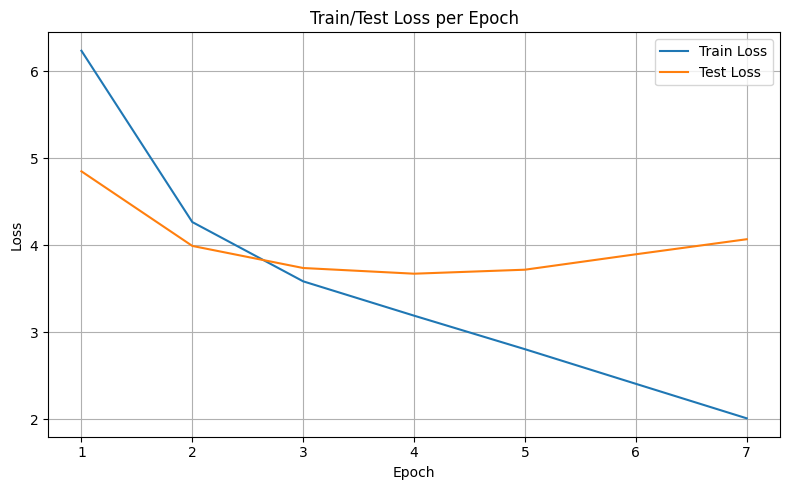

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3504
Epoch 1 Validation Loss: 4.8411


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2734
Epoch 2 Validation Loss: 3.9622


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5597
Epoch 3 Validation Loss: 3.7096


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1567
Epoch 4 Validation Loss: 3.6513


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7762
Epoch 5 Validation Loss: 3.7016


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3691
Epoch 6 Validation Loss: 3.8811


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9900
Epoch 7 Validation Loss: 4.0876
Early stopping triggered at epoch 7


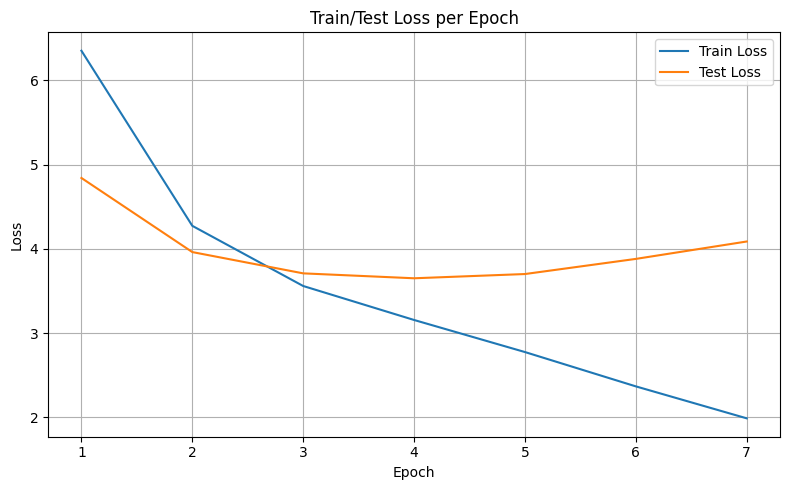

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3105
Epoch 1 Validation Loss: 4.8553


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3082
Epoch 2 Validation Loss: 4.0018


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5796
Epoch 3 Validation Loss: 3.7074


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1348
Epoch 4 Validation Loss: 3.6403


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7274
Epoch 5 Validation Loss: 3.6603


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3095
Epoch 6 Validation Loss: 3.8359


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9232
Epoch 7 Validation Loss: 4.0654
Early stopping triggered at epoch 7


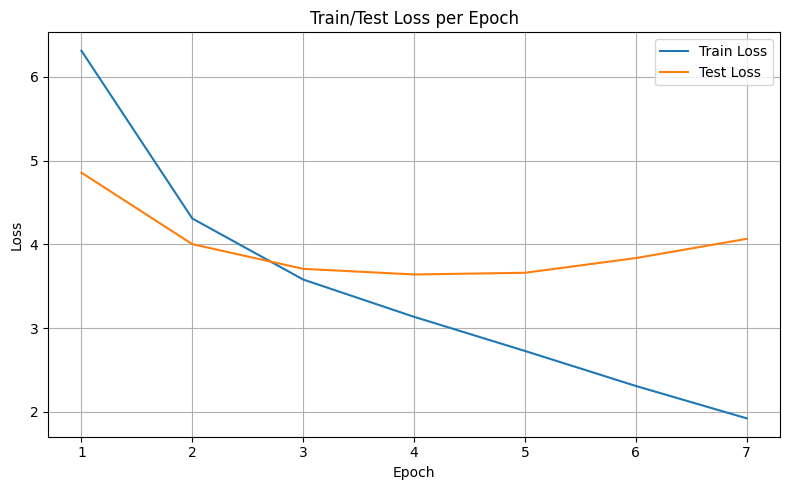

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3289
Epoch 1 Validation Loss: 4.8298


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2723
Epoch 2 Validation Loss: 3.9916


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5716
Epoch 3 Validation Loss: 3.7323


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1693
Epoch 4 Validation Loss: 3.6694


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7821
Epoch 5 Validation Loss: 3.7181


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3671
Epoch 6 Validation Loss: 3.8733


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9721
Epoch 7 Validation Loss: 4.0728
Early stopping triggered at epoch 7


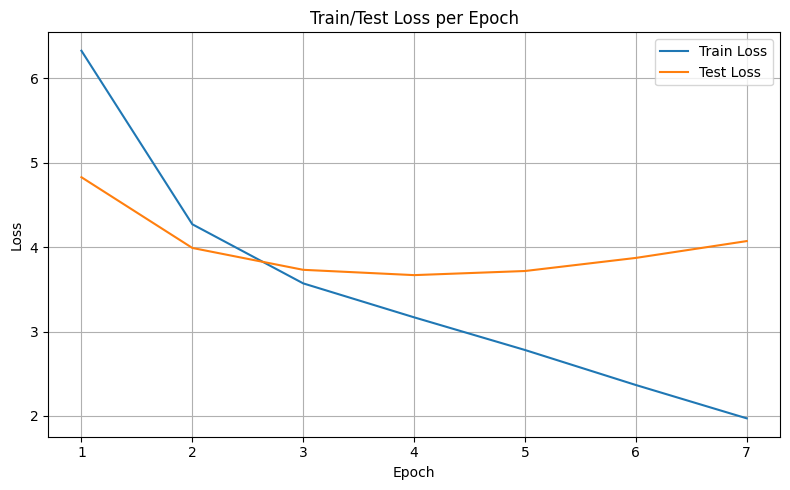

Trial 15/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.3}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3441
Epoch 1 Validation Loss: 4.9056


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3013
Epoch 2 Validation Loss: 3.9934


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5741
Epoch 3 Validation Loss: 3.7047


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1724
Epoch 4 Validation Loss: 3.6803


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7983
Epoch 5 Validation Loss: 3.7063


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3896
Epoch 6 Validation Loss: 3.8953


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9918
Epoch 7 Validation Loss: 4.1488
Early stopping triggered at epoch 7


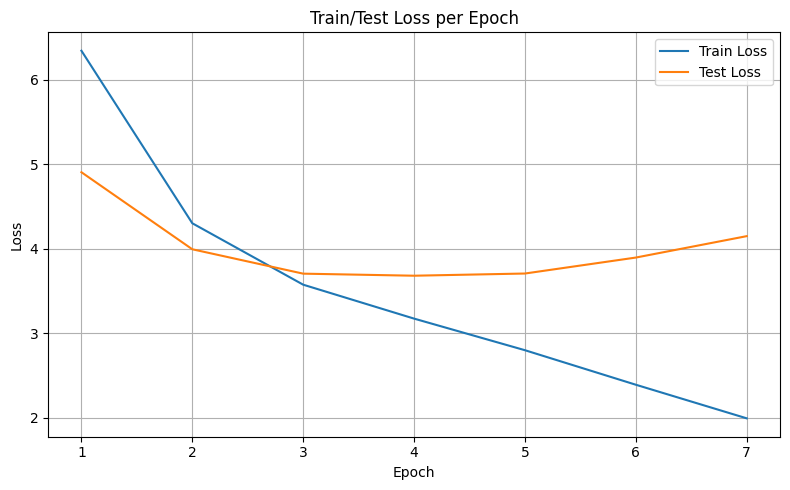

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3539
Epoch 1 Validation Loss: 4.8693


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3004
Epoch 2 Validation Loss: 3.9878


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5753
Epoch 3 Validation Loss: 3.7113


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1631
Epoch 4 Validation Loss: 3.6396


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7838
Epoch 5 Validation Loss: 3.7121


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3725
Epoch 6 Validation Loss: 3.8895


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9762
Epoch 7 Validation Loss: 4.0499
Early stopping triggered at epoch 7


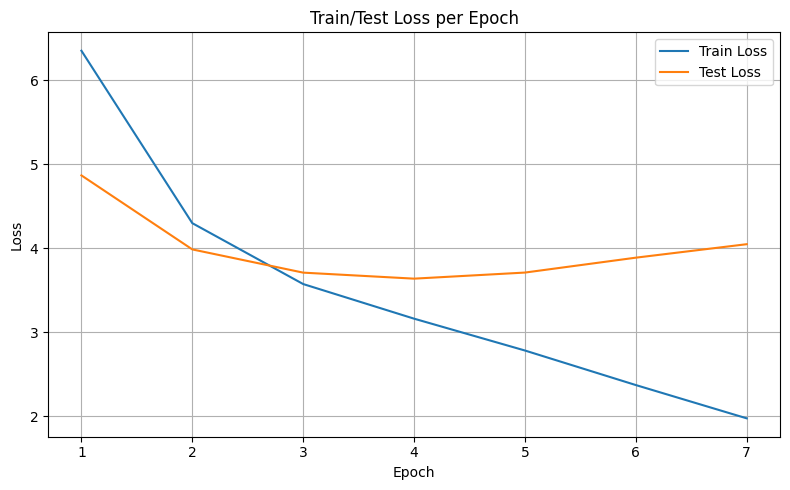

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2252
Epoch 1 Validation Loss: 4.8415


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3028
Epoch 2 Validation Loss: 3.9779


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5772
Epoch 3 Validation Loss: 3.7057


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1699
Epoch 4 Validation Loss: 3.6365


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7723
Epoch 5 Validation Loss: 3.6829


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3658
Epoch 6 Validation Loss: 3.8287


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9748
Epoch 7 Validation Loss: 4.0478
Early stopping triggered at epoch 7


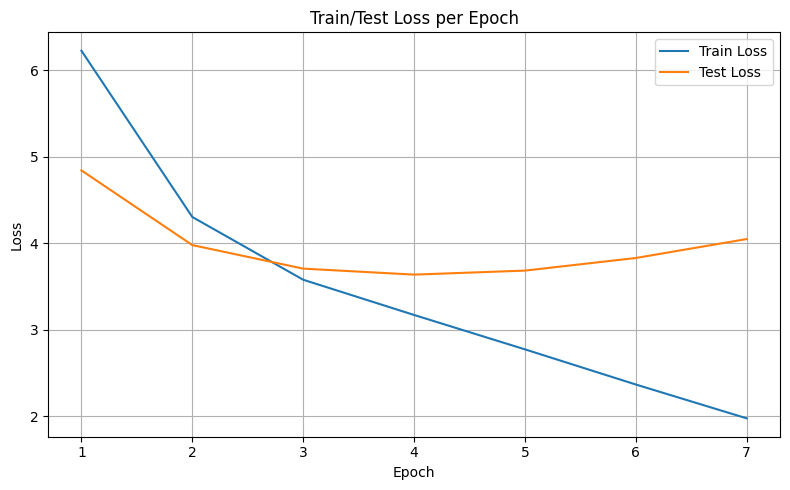

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2599
Epoch 1 Validation Loss: 4.8980


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3109
Epoch 2 Validation Loss: 4.0160


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5871
Epoch 3 Validation Loss: 3.7181


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1614
Epoch 4 Validation Loss: 3.6164


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7655
Epoch 5 Validation Loss: 3.7139


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3526
Epoch 6 Validation Loss: 3.8482


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9549
Epoch 7 Validation Loss: 4.1141
Early stopping triggered at epoch 7


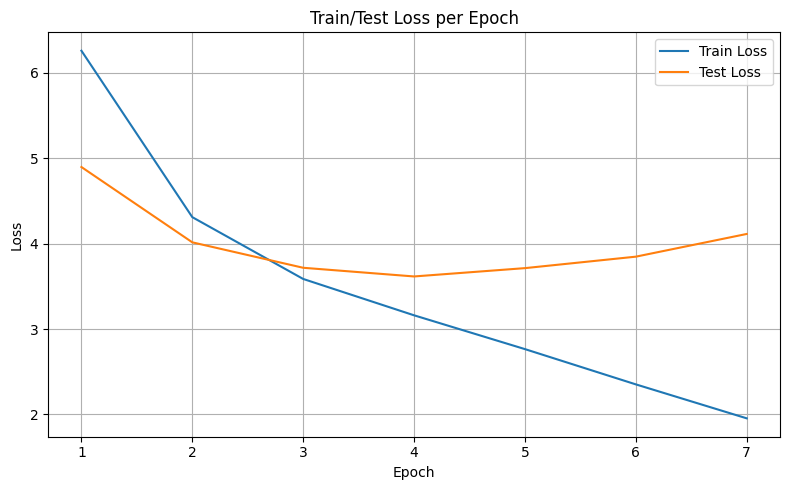

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.3101
Epoch 1 Validation Loss: 4.8596


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2669
Epoch 2 Validation Loss: 3.9787


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5605
Epoch 3 Validation Loss: 3.6843


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1256
Epoch 4 Validation Loss: 3.6379


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7283
Epoch 5 Validation Loss: 3.7246


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3154
Epoch 6 Validation Loss: 3.8719


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9234
Epoch 7 Validation Loss: 4.1756
Early stopping triggered at epoch 7


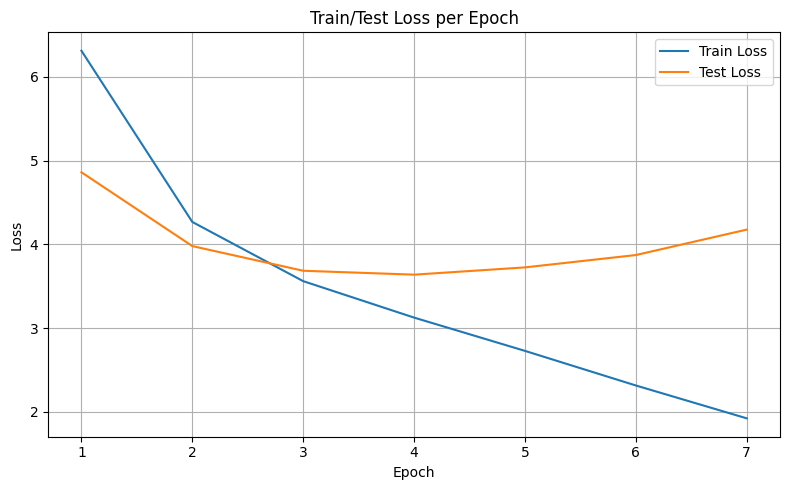

Trial 16/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.1}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2021
Epoch 1 Validation Loss: 4.8297


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2563
Epoch 2 Validation Loss: 3.9853


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5664
Epoch 3 Validation Loss: 3.6933


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1463
Epoch 4 Validation Loss: 3.6382


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7591
Epoch 5 Validation Loss: 3.6601


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3476
Epoch 6 Validation Loss: 3.8301


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9572
Epoch 7 Validation Loss: 4.0782
Early stopping triggered at epoch 7


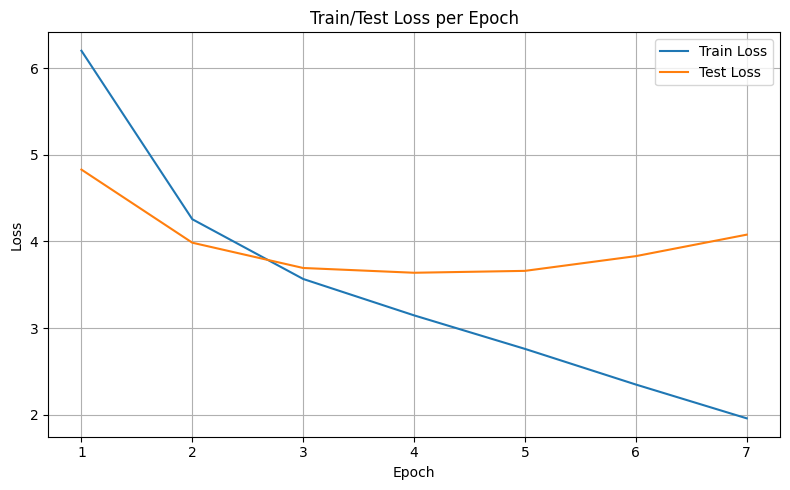

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1825
Epoch 1 Validation Loss: 4.8311


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2421
Epoch 2 Validation Loss: 3.9678


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5331
Epoch 3 Validation Loss: 3.6876


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1382
Epoch 4 Validation Loss: 3.6429


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7576
Epoch 5 Validation Loss: 3.6688


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3599
Epoch 6 Validation Loss: 3.8289


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9516
Epoch 7 Validation Loss: 4.0945
Early stopping triggered at epoch 7


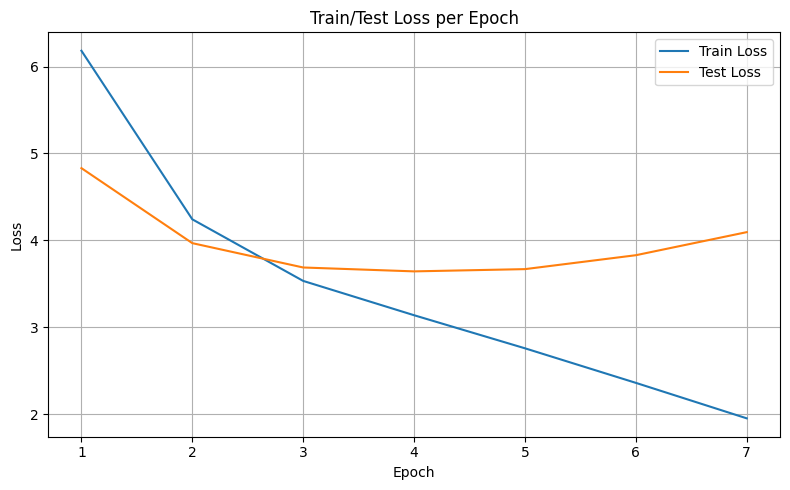

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2123
Epoch 1 Validation Loss: 4.8328


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2783
Epoch 2 Validation Loss: 3.9795


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5517
Epoch 3 Validation Loss: 3.6751


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1255
Epoch 4 Validation Loss: 3.6321


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7238
Epoch 5 Validation Loss: 3.6939


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3140
Epoch 6 Validation Loss: 3.9211


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9285
Epoch 7 Validation Loss: 4.0480
Early stopping triggered at epoch 7


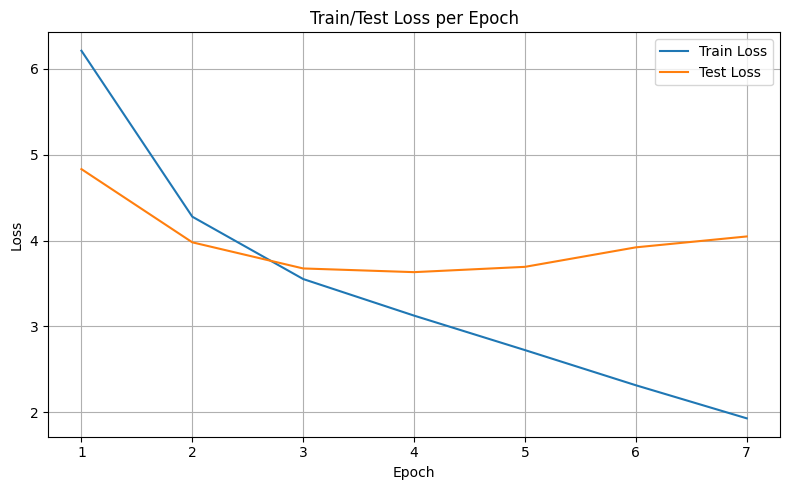

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2547
Epoch 1 Validation Loss: 4.7974


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2183
Epoch 2 Validation Loss: 3.9533


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5538
Epoch 3 Validation Loss: 3.7080


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1612
Epoch 4 Validation Loss: 3.6406


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7793
Epoch 5 Validation Loss: 3.6671


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3598
Epoch 6 Validation Loss: 3.8730


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9582
Epoch 7 Validation Loss: 4.0446
Early stopping triggered at epoch 7


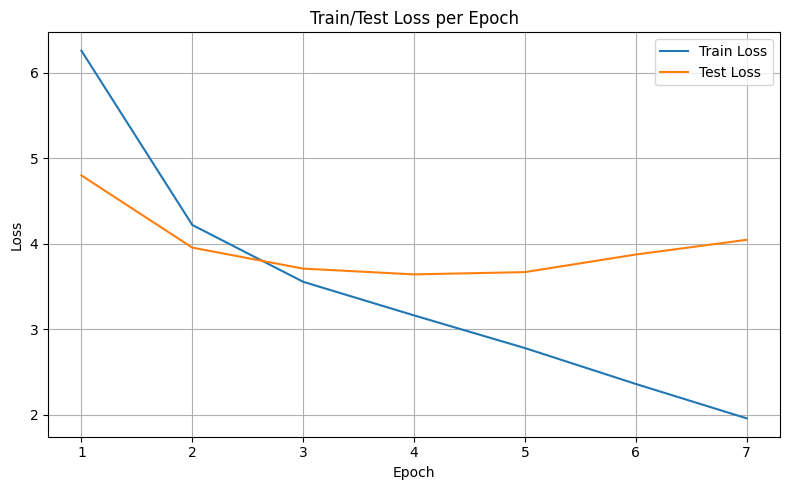

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2357
Epoch 1 Validation Loss: 4.8286


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2335
Epoch 2 Validation Loss: 3.9866


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5505
Epoch 3 Validation Loss: 3.6835


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1455
Epoch 4 Validation Loss: 3.6557


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7621
Epoch 5 Validation Loss: 3.6719


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3530
Epoch 6 Validation Loss: 3.8582


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9595
Epoch 7 Validation Loss: 4.0451
Early stopping triggered at epoch 7


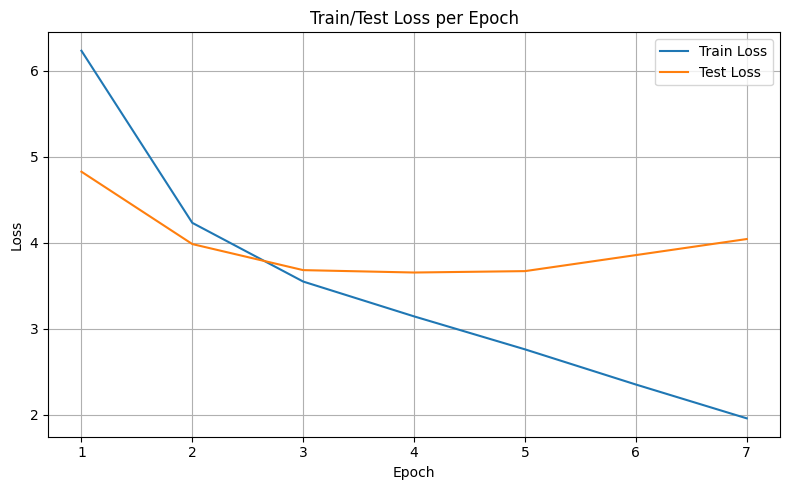

Trial 17/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.2}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2289
Epoch 1 Validation Loss: 4.8134


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2498
Epoch 2 Validation Loss: 3.9673


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5322
Epoch 3 Validation Loss: 3.6722


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1164
Epoch 4 Validation Loss: 3.6044


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7297
Epoch 5 Validation Loss: 3.7064


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3313
Epoch 6 Validation Loss: 3.8496


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9509
Epoch 7 Validation Loss: 4.0535
Early stopping triggered at epoch 7


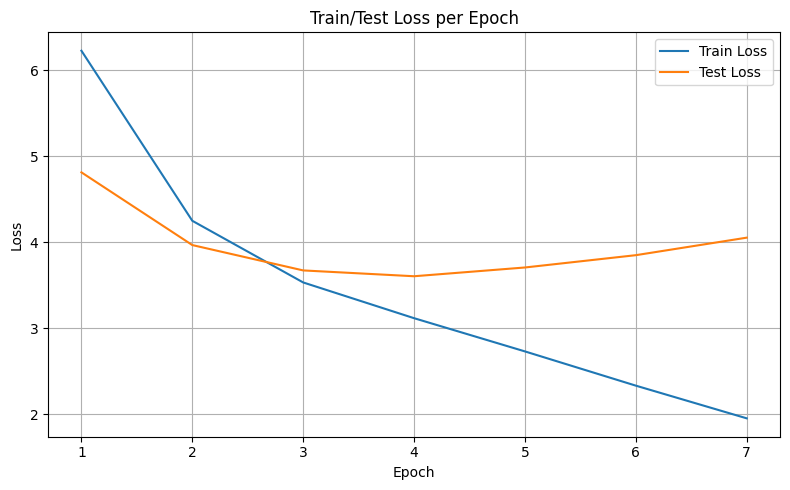

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1656
Epoch 1 Validation Loss: 4.8251


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2876
Epoch 2 Validation Loss: 3.9965


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5565
Epoch 3 Validation Loss: 3.7041


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1169
Epoch 4 Validation Loss: 3.6299


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7253
Epoch 5 Validation Loss: 3.6863


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3164
Epoch 6 Validation Loss: 3.7840


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9288
Epoch 7 Validation Loss: 4.0837
Early stopping triggered at epoch 7


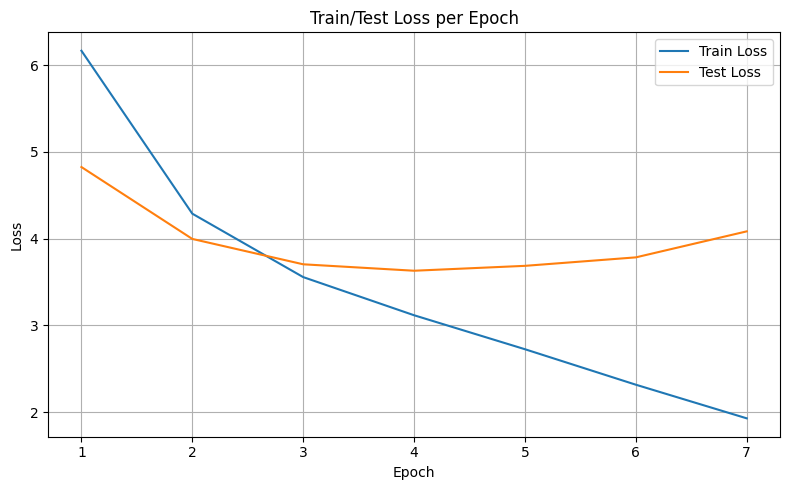

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1373
Epoch 1 Validation Loss: 4.8102


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2456
Epoch 2 Validation Loss: 3.9549


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5289
Epoch 3 Validation Loss: 3.6620


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1052
Epoch 4 Validation Loss: 3.6096


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7149
Epoch 5 Validation Loss: 3.6796


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3047
Epoch 6 Validation Loss: 3.8149


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9095
Epoch 7 Validation Loss: 4.1207
Early stopping triggered at epoch 7


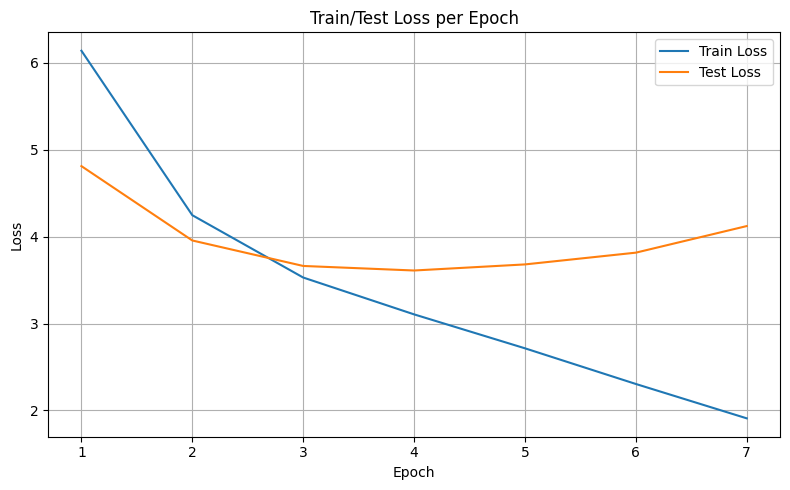

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2537
Epoch 1 Validation Loss: 4.8353


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2554
Epoch 2 Validation Loss: 3.9542


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5281
Epoch 3 Validation Loss: 3.6603


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1027
Epoch 4 Validation Loss: 3.6171


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7061
Epoch 5 Validation Loss: 3.6655


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.2963
Epoch 6 Validation Loss: 3.8562


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9053
Epoch 7 Validation Loss: 4.1467
Early stopping triggered at epoch 7


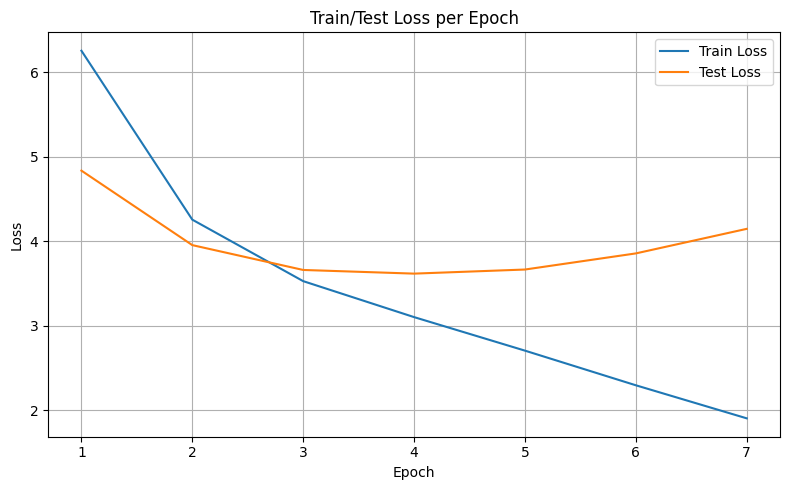

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1774
Epoch 1 Validation Loss: 4.7829


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2409
Epoch 2 Validation Loss: 3.9862


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5576
Epoch 3 Validation Loss: 3.7335


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1637
Epoch 4 Validation Loss: 3.6411


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7892
Epoch 5 Validation Loss: 3.7192


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3820
Epoch 6 Validation Loss: 3.8894


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9938
Epoch 7 Validation Loss: 4.1224
Early stopping triggered at epoch 7


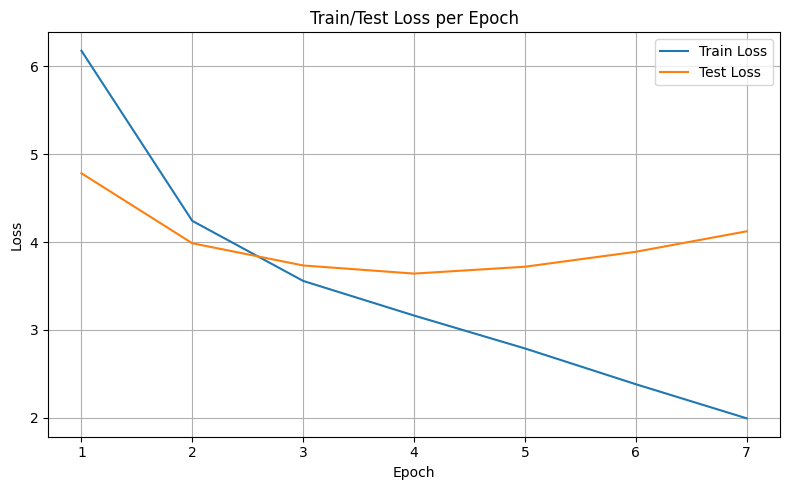

Trial 18/270: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.3}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2419
Epoch 1 Validation Loss: 4.7993


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2133
Epoch 2 Validation Loss: 3.9377


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5340
Epoch 3 Validation Loss: 3.6858


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1491
Epoch 4 Validation Loss: 3.6120


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7819
Epoch 5 Validation Loss: 3.6653


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3802
Epoch 6 Validation Loss: 3.8087


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0011
Epoch 7 Validation Loss: 4.0557
Early stopping triggered at epoch 7


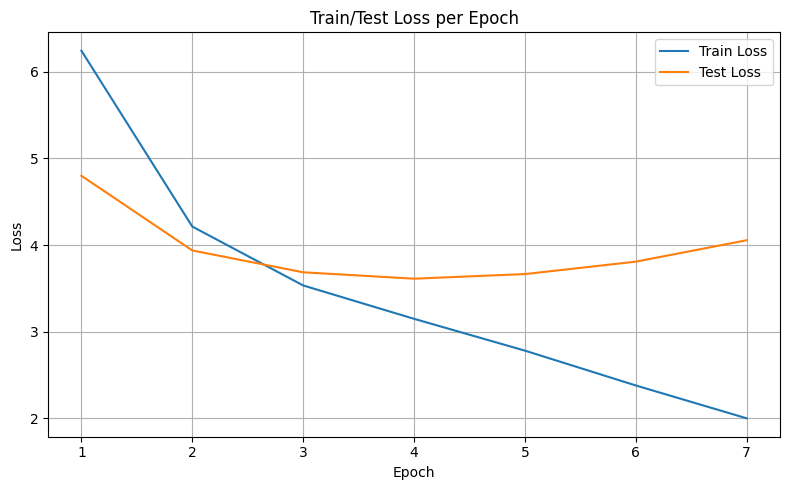

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1376
Epoch 1 Validation Loss: 4.7786


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2515
Epoch 2 Validation Loss: 3.9792


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5382
Epoch 3 Validation Loss: 3.6753


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1187
Epoch 4 Validation Loss: 3.6182


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7257
Epoch 5 Validation Loss: 3.6868


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3208
Epoch 6 Validation Loss: 3.8803


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9467
Epoch 7 Validation Loss: 4.0955
Early stopping triggered at epoch 7


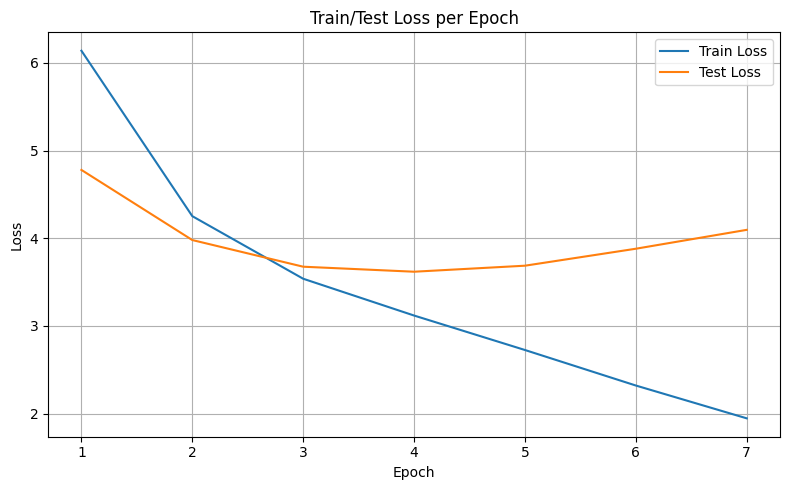

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2227
Epoch 1 Validation Loss: 4.8189


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2551
Epoch 2 Validation Loss: 3.9556


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5505
Epoch 3 Validation Loss: 3.7053


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1451
Epoch 4 Validation Loss: 3.6271


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7528
Epoch 5 Validation Loss: 3.7236


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3479
Epoch 6 Validation Loss: 3.8061


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9573
Epoch 7 Validation Loss: 4.1169
Early stopping triggered at epoch 7


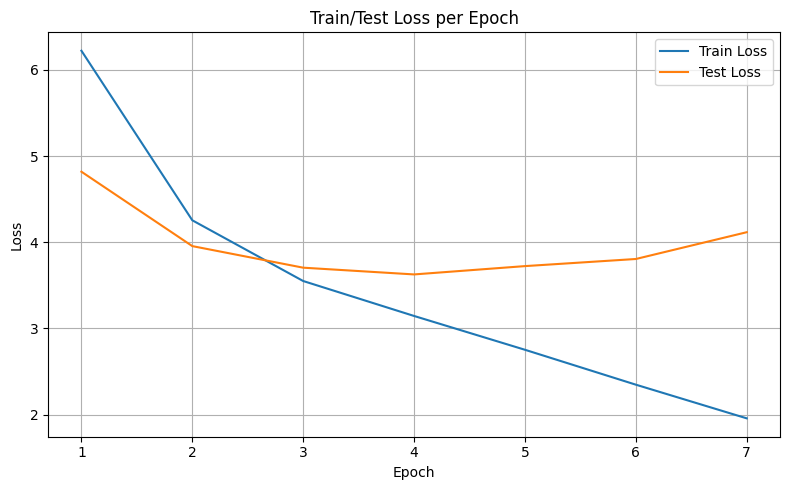

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.2314
Epoch 1 Validation Loss: 4.7834


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2480
Epoch 2 Validation Loss: 3.9767


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5653
Epoch 3 Validation Loss: 3.7233


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1618
Epoch 4 Validation Loss: 3.6250


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7706
Epoch 5 Validation Loss: 3.6789


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3716
Epoch 6 Validation Loss: 3.8221


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9808
Epoch 7 Validation Loss: 4.0693
Early stopping triggered at epoch 7


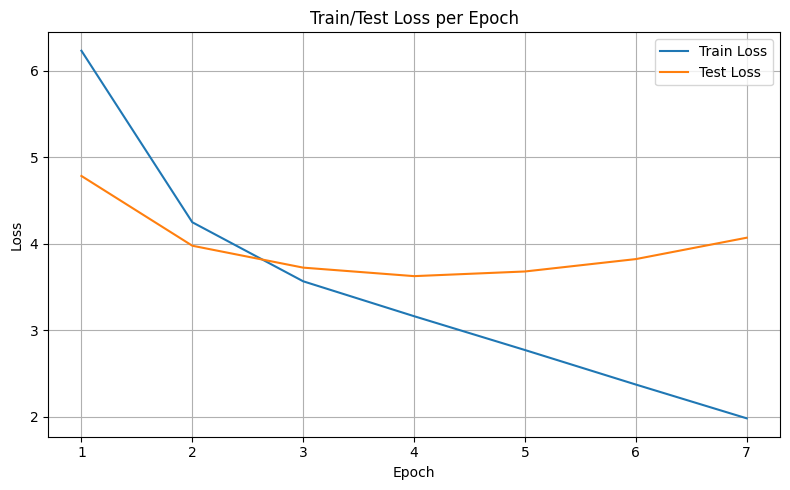

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1581
Epoch 1 Validation Loss: 4.8055


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2277
Epoch 2 Validation Loss: 3.9636


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5621
Epoch 3 Validation Loss: 3.7017


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1499
Epoch 4 Validation Loss: 3.6185


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7654
Epoch 5 Validation Loss: 3.6735


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3675
Epoch 6 Validation Loss: 3.8105


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9779
Epoch 7 Validation Loss: 4.0579
Early stopping triggered at epoch 7


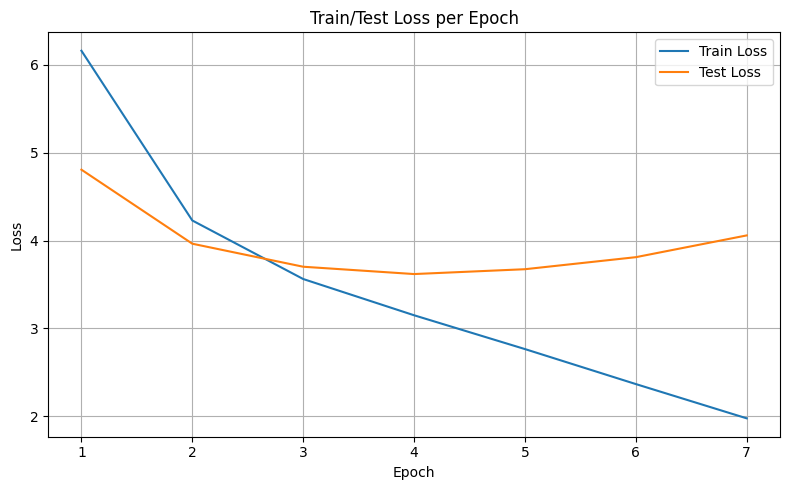

Trial 19/270: {'n_layers': 1, 'd_model': 256, 'n_heads': 4, 'd_ff': 512, 'dropout': 0.1}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0435
Epoch 1 Validation Loss: 4.6432


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.0997
Epoch 2 Validation Loss: 3.9002


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4480
Epoch 3 Validation Loss: 3.6789


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9658
Epoch 4 Validation Loss: 3.6389


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4488
Epoch 5 Validation Loss: 3.7854


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.9254
Epoch 6 Validation Loss: 4.0379


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.5343
Epoch 7 Validation Loss: 4.3270
Early stopping triggered at epoch 7


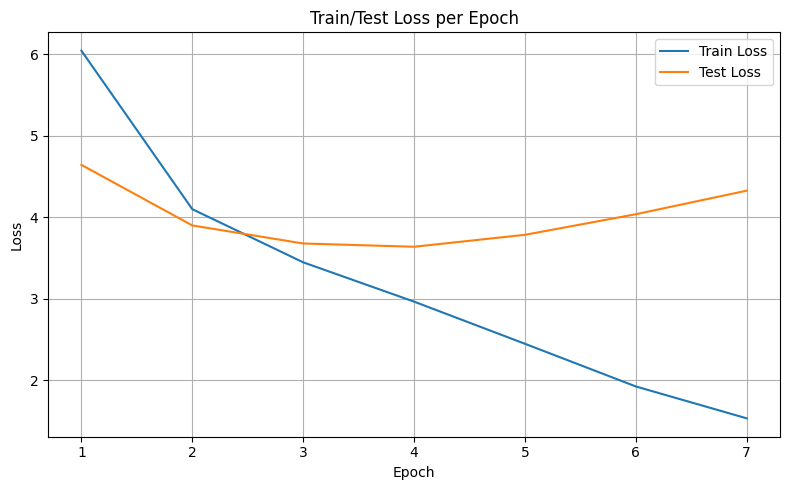

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0348
Epoch 1 Validation Loss: 4.7104


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1378
Epoch 2 Validation Loss: 3.9086


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4513
Epoch 3 Validation Loss: 3.6576


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9623
Epoch 4 Validation Loss: 3.6316


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4350
Epoch 5 Validation Loss: 3.7631


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.9004
Epoch 6 Validation Loss: 4.0662


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.5049
Epoch 7 Validation Loss: 4.3926
Early stopping triggered at epoch 7


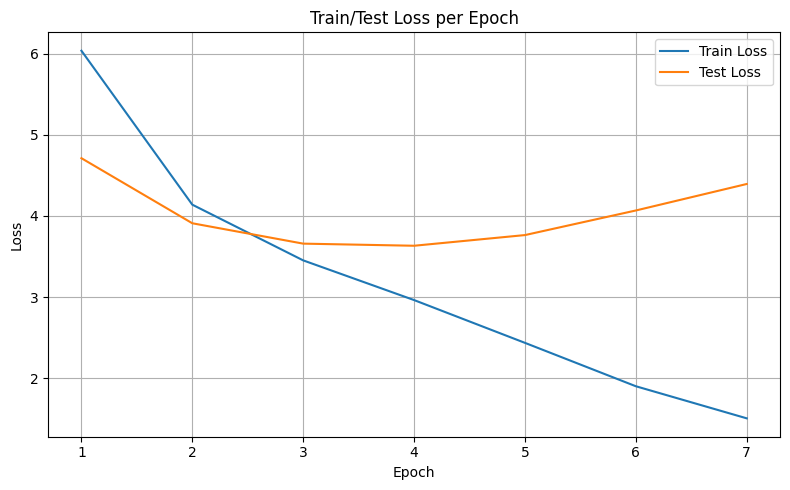

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1198
Epoch 1 Validation Loss: 4.6946


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1484
Epoch 2 Validation Loss: 3.9341


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4672
Epoch 3 Validation Loss: 3.7110


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9607
Epoch 4 Validation Loss: 3.6191


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4242
Epoch 5 Validation Loss: 3.7731


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8913
Epoch 6 Validation Loss: 4.0915


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4843
Epoch 7 Validation Loss: 4.3402
Early stopping triggered at epoch 7


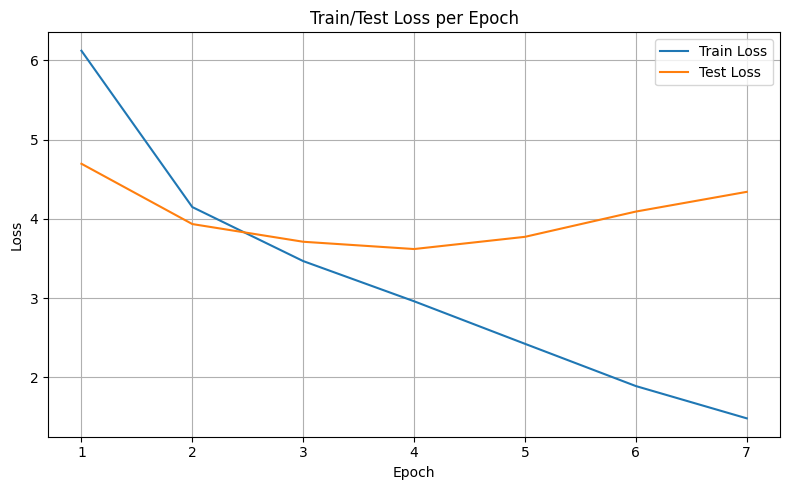

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0243
Epoch 1 Validation Loss: 4.6552


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1169
Epoch 2 Validation Loss: 3.9133


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4497
Epoch 3 Validation Loss: 3.6684


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9569
Epoch 4 Validation Loss: 3.6386


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4200
Epoch 5 Validation Loss: 3.7499


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8858
Epoch 6 Validation Loss: 4.0369


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4925
Epoch 7 Validation Loss: 4.2950
Early stopping triggered at epoch 7


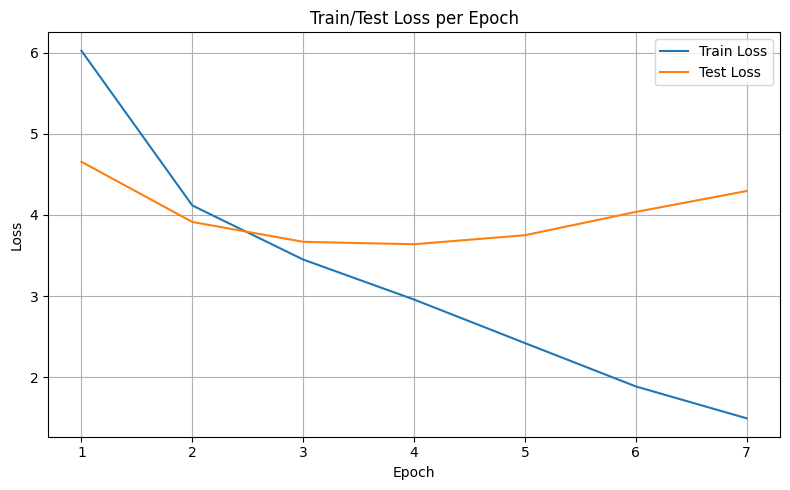

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1017
Epoch 1 Validation Loss: 4.6794


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1247
Epoch 2 Validation Loss: 3.9198


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4487
Epoch 3 Validation Loss: 3.6655


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9484
Epoch 4 Validation Loss: 3.6448


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4101
Epoch 5 Validation Loss: 3.8128


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8746
Epoch 6 Validation Loss: 4.0750


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4867
Epoch 7 Validation Loss: 4.4018
Early stopping triggered at epoch 7


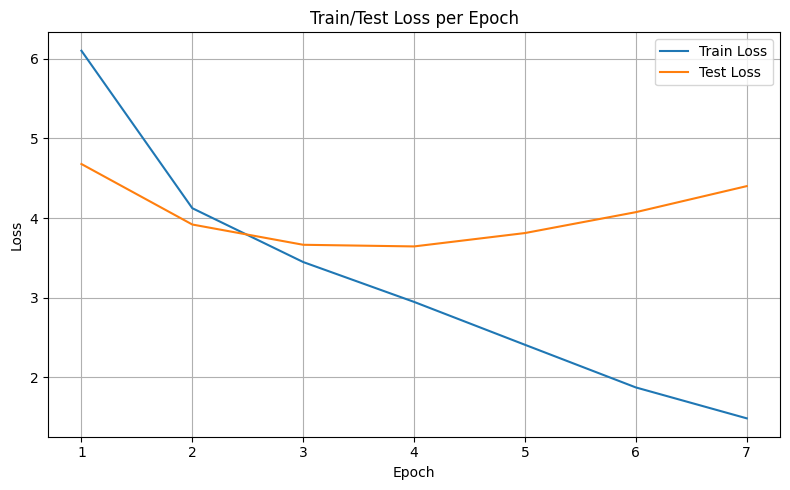

Trial 20/270: {'n_layers': 1, 'd_model': 256, 'n_heads': 4, 'd_ff': 512, 'dropout': 0.2}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1475
Epoch 1 Validation Loss: 4.6923


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1138
Epoch 2 Validation Loss: 3.9085


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4452
Epoch 3 Validation Loss: 3.6654


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9642
Epoch 4 Validation Loss: 3.6537


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4466
Epoch 5 Validation Loss: 3.7571


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.9290
Epoch 6 Validation Loss: 4.0948


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.5281
Epoch 7 Validation Loss: 4.3653
Early stopping triggered at epoch 7


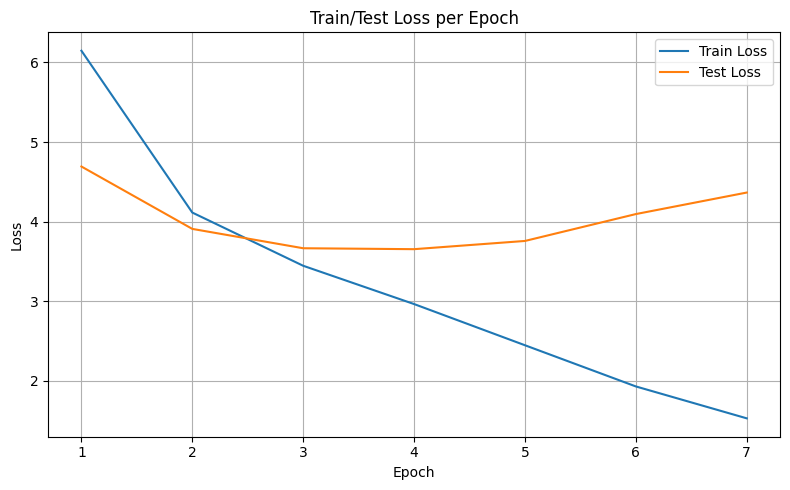

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1413
Epoch 1 Validation Loss: 4.6886


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1197
Epoch 2 Validation Loss: 3.9088


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4430
Epoch 3 Validation Loss: 3.6395


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9373
Epoch 4 Validation Loss: 3.6120


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.3905
Epoch 5 Validation Loss: 3.7658


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8541
Epoch 6 Validation Loss: 4.0624


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4598
Epoch 7 Validation Loss: 4.3368
Early stopping triggered at epoch 7


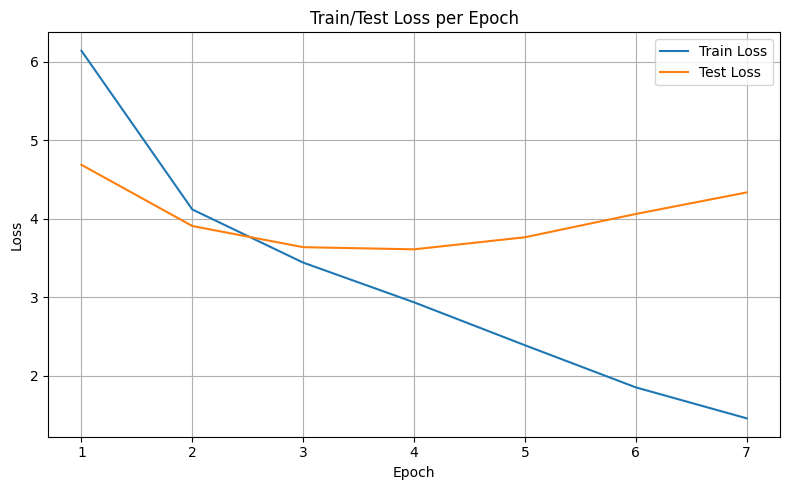

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0573
Epoch 1 Validation Loss: 4.6683


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1234
Epoch 2 Validation Loss: 3.9089


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4649
Epoch 3 Validation Loss: 3.6749


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9753
Epoch 4 Validation Loss: 3.6527


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4372
Epoch 5 Validation Loss: 3.7746


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.9020
Epoch 6 Validation Loss: 4.0255


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4980
Epoch 7 Validation Loss: 4.2657
Early stopping triggered at epoch 7


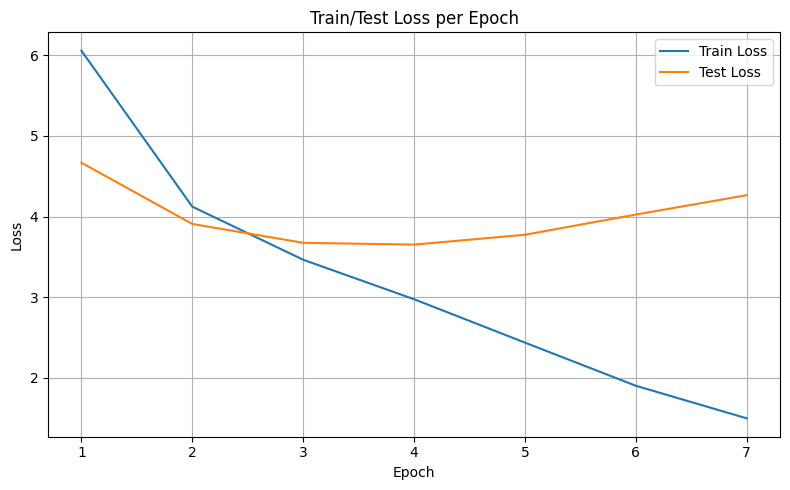

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0688
Epoch 1 Validation Loss: 4.6496


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.0977
Epoch 2 Validation Loss: 3.9068


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4451
Epoch 3 Validation Loss: 3.6638


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9471
Epoch 4 Validation Loss: 3.6793


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4286
Epoch 5 Validation Loss: 3.7894


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8989
Epoch 6 Validation Loss: 4.1262
Early stopping triggered at epoch 6


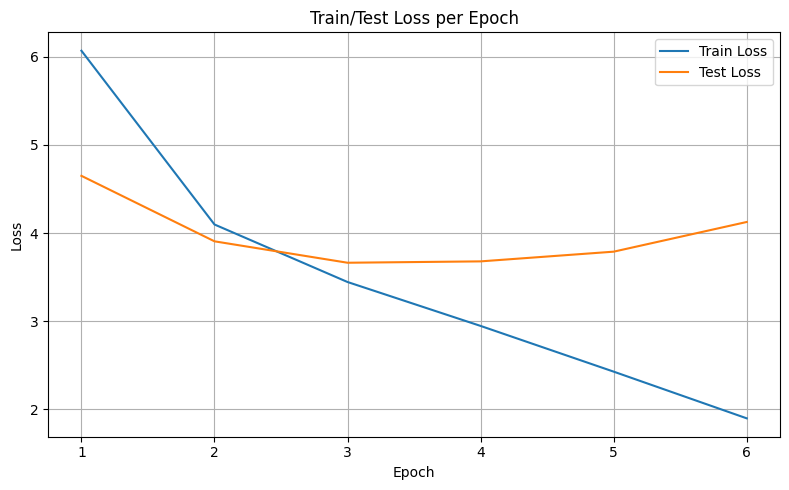

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0721
Epoch 1 Validation Loss: 4.6801


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1359
Epoch 2 Validation Loss: 3.9218


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4599
Epoch 3 Validation Loss: 3.6787


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9575
Epoch 4 Validation Loss: 3.6178


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4120
Epoch 5 Validation Loss: 3.7853


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8840
Epoch 6 Validation Loss: 4.0509


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4724
Epoch 7 Validation Loss: 4.3663
Early stopping triggered at epoch 7


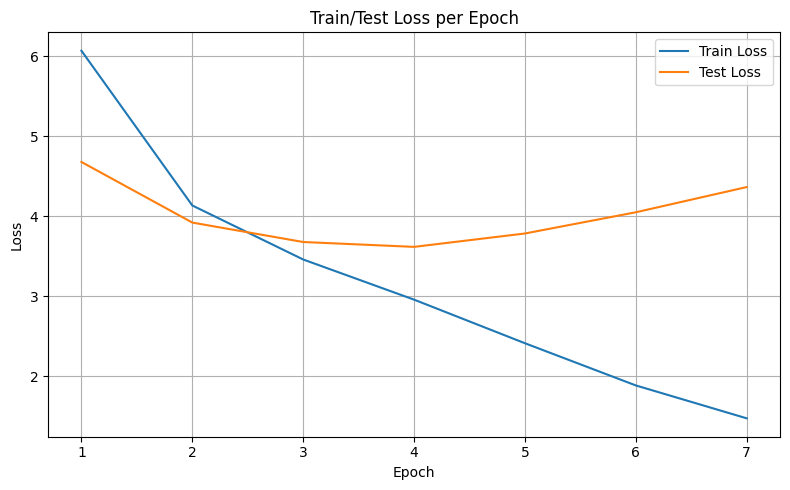

Trial 21/270: {'n_layers': 1, 'd_model': 256, 'n_heads': 4, 'd_ff': 512, 'dropout': 0.3}
Warmup Steps: 100


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1499
Epoch 1 Validation Loss: 4.6482


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1047
Epoch 2 Validation Loss: 3.9019


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4358
Epoch 3 Validation Loss: 3.6467


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9290
Epoch 4 Validation Loss: 3.6451


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.3917
Epoch 5 Validation Loss: 3.7550


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8633
Epoch 6 Validation Loss: 4.0402


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4793
Epoch 7 Validation Loss: 4.3003
Early stopping triggered at epoch 7


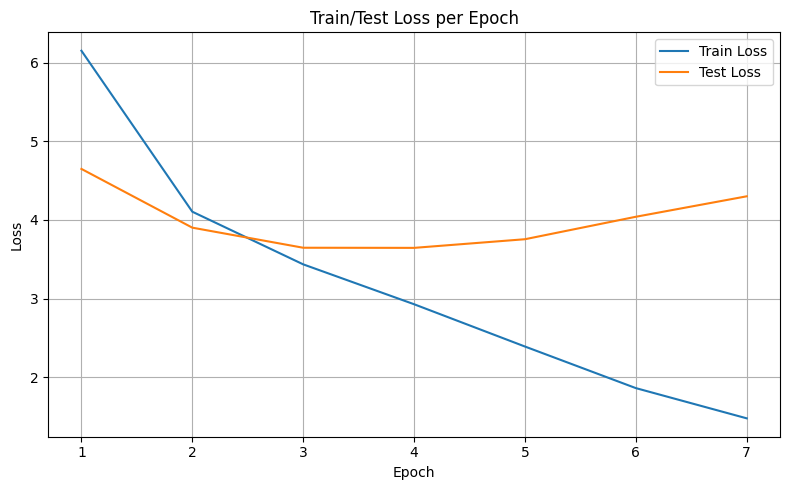

Warmup Steps: 300


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0389
Epoch 1 Validation Loss: 4.6337


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.0741
Epoch 2 Validation Loss: 3.9102


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4435
Epoch 3 Validation Loss: 3.7010


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9755
Epoch 4 Validation Loss: 3.6765


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.4538
Epoch 5 Validation Loss: 3.8343


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.9214
Epoch 6 Validation Loss: 4.0440


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.5263
Epoch 7 Validation Loss: 4.3567
Early stopping triggered at epoch 7


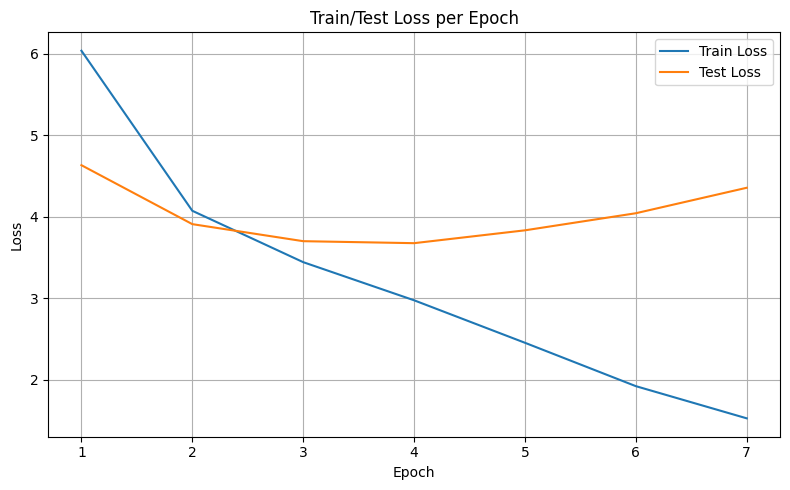

Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1643
Epoch 1 Validation Loss: 4.6702


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1260
Epoch 2 Validation Loss: 3.9096


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4366
Epoch 3 Validation Loss: 3.6713


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9264
Epoch 4 Validation Loss: 3.6078


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.3747
Epoch 5 Validation Loss: 3.7828


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8352
Epoch 6 Validation Loss: 4.0230


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4413
Epoch 7 Validation Loss: 4.3469
Early stopping triggered at epoch 7


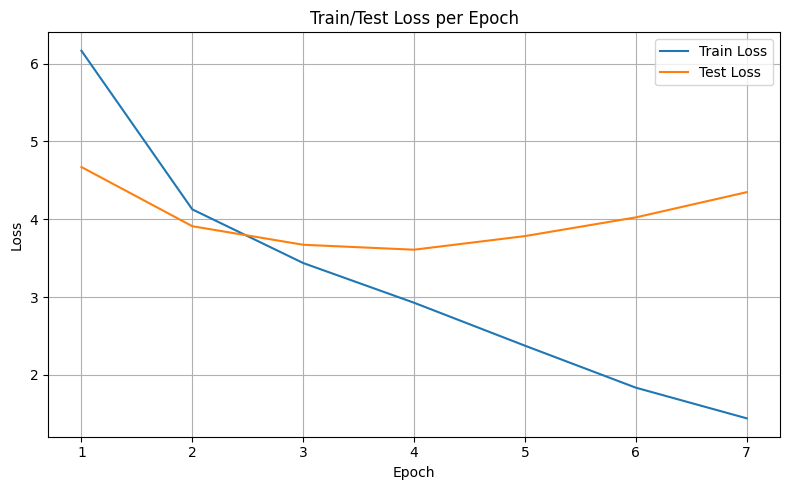

Warmup Steps: 1000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1222
Epoch 1 Validation Loss: 4.6743


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1005
Epoch 2 Validation Loss: 3.9002


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4300
Epoch 3 Validation Loss: 3.6558


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.9333
Epoch 4 Validation Loss: 3.6280


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.3919
Epoch 5 Validation Loss: 3.7793


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8630
Epoch 6 Validation Loss: 4.0556


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.4815
Epoch 7 Validation Loss: 4.3256
Early stopping triggered at epoch 7


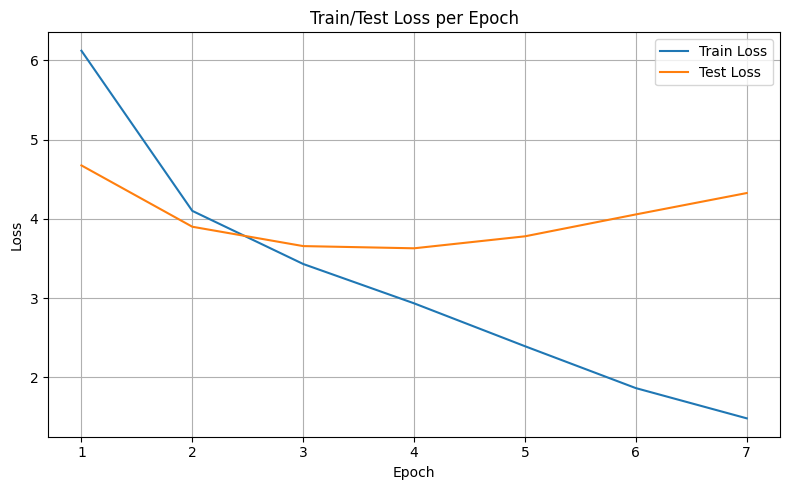

Warmup Steps: 2000


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1048
Epoch 1 Validation Loss: 4.6572


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.1126
Epoch 2 Validation Loss: 3.9090


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.4153
Epoch 3 Validation Loss: 3.6198


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.8798
Epoch 4 Validation Loss: 3.6314


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.3306
Epoch 5 Validation Loss: 3.8019


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.8057


KeyboardInterrupt: 

In [61]:
result=[]
hp_order = ['n_layers', 'd_model', 'n_heads', 'd_ff', 'dropout']
for i, hp_args in enumerate(arg_combinations):
  print(f"Trial {i+1}/{len(arg_combinations)}: {hp_args}")

  full_args = {
      "src_vocab_size": len(tokenizer.word_index) + 1,
      "tgt_vocab_size": len(tokenizer.word_index)+ 1,
      "pos_len": 80,
      "shared_fc": True,
      "shared_emb": True,
      **hp_args
  }

  for warm in [100,300,500,1000,2000]:
    print(f"Warmup Steps: {warm}")
    best_val_loss = tuner(full_args, f"transformer_{i+1}_", warmup_steps=warm, epoch=20)
    hp_tuple = tuple(hp_args[k] for k in hp_order) + (warm, best_val_loss)
    result.append(hp_tuple)
    K.clear_session()

In [62]:
result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])

Best config: (1, 128, 8, 2048, 0.2, 100, np.float64(3.6044225692749023))
Second best config: (1, 256, 4, 512, 0.3, 500, np.float64(3.6078077952067056))
Third best config: (1, 128, 8, 2048, 0.2, 500, np.float64(3.6096461613972983))


In [63]:
result

[(1, 128, 8, 2048, 0.2, 100, np.float64(3.6044225692749023)),
 (1, 256, 4, 512, 0.3, 500, np.float64(3.6078077952067056)),
 (1, 128, 8, 2048, 0.2, 500, np.float64(3.6096461613972983)),
 (1, 128, 8, 2048, 0.3, 100, np.float64(3.6120290756225586)),
 (1, 256, 4, 512, 0.2, 300, np.float64(3.612045923868815)),
 (1, 128, 4, 2048, 0.3, 1000, np.float64(3.612820307413737)),
 (1, 128, 8, 512, 0.2, 2000, np.float64(3.6129252115885415)),
 (1, 128, 4, 512, 0.2, 2000, np.float64(3.6133365631103516)),
 (1, 128, 4, 2048, 0.1, 1000, np.float64(3.6141316095987954)),
 (1, 128, 4, 2048, 0.3, 100, np.float64(3.6161410013834634)),
 (1, 128, 8, 1024, 0.3, 1000, np.float64(3.6164331436157227)),
 (1, 128, 8, 2048, 0.2, 1000, np.float64(3.617093086242676)),
 (1, 256, 4, 512, 0.2, 2000, np.float64(3.6178099314371743)),
 (1, 128, 8, 2048, 0.3, 300, np.float64(3.618189811706543)),
 (1, 128, 8, 2048, 0.3, 2000, np.float64(3.6185220082600913)),
 (1, 256, 4, 512, 0.1, 500, np.float64(3.619053522745768)),
 (1, 128, 4

In [38]:
search_space = {
    "n_layers": [1],
    "d_model": [128, 368],
    "n_heads": [8],
    "d_ff": [512,2048],
    "dropout": [0.2]
}

In [39]:
keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

Trial 1/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 512, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.4889
Epoch 1 Validation Loss: 4.9388


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3249
Epoch 2 Validation Loss: 3.9874


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5804
Epoch 3 Validation Loss: 3.7266


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1845
Epoch 4 Validation Loss: 3.7086


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.8205
Epoch 5 Validation Loss: 3.7267


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.4253
Epoch 6 Validation Loss: 3.9044


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 2.0561
Epoch 7 Validation Loss: 4.1046
Early stopping triggered at epoch 7


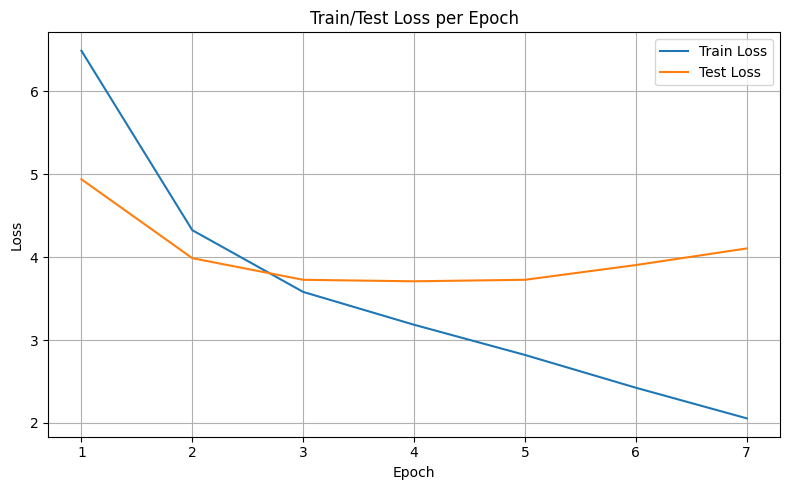

Trial 2/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.4622
Epoch 1 Validation Loss: 4.8662


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2887
Epoch 2 Validation Loss: 3.9962


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5640
Epoch 3 Validation Loss: 3.7225


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1528
Epoch 4 Validation Loss: 3.6706


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7696
Epoch 5 Validation Loss: 3.7104


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3626
Epoch 6 Validation Loss: 3.8672


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9711
Epoch 7 Validation Loss: 4.0630
Early stopping triggered at epoch 7


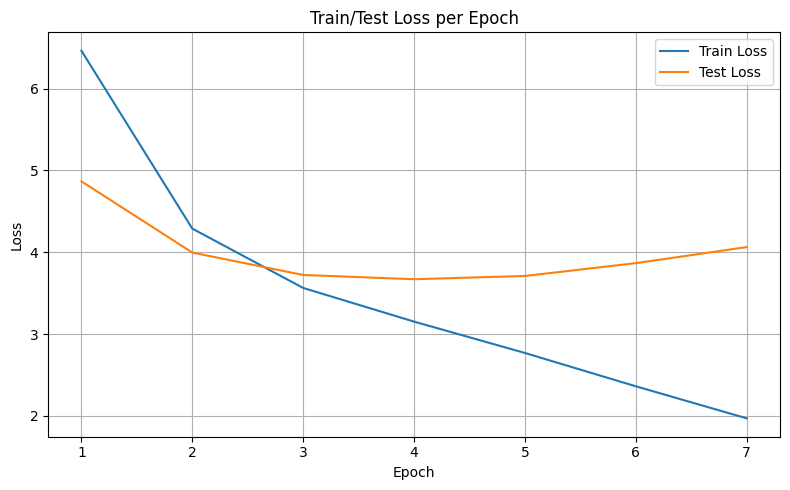

Trial 3/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 512, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1417
Epoch 1 Validation Loss: 4.6129


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.0195
Epoch 2 Validation Loss: 3.8107


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.2944
Epoch 3 Validation Loss: 3.6171


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.7040
Epoch 4 Validation Loss: 3.6292


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.0328
Epoch 5 Validation Loss: 3.8913


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.4539
Epoch 6 Validation Loss: 4.2712
Early stopping triggered at epoch 6


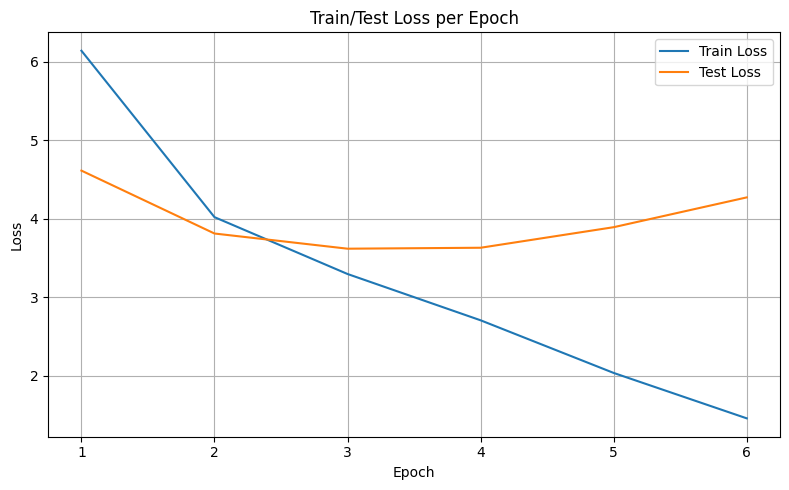

Trial 4/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 2048, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0464
Epoch 1 Validation Loss: 4.5402


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.9632
Epoch 2 Validation Loss: 3.8175


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.2669
Epoch 3 Validation Loss: 3.6402


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.6691
Epoch 4 Validation Loss: 3.6794


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.9949
Epoch 5 Validation Loss: 3.9626


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.4194
Epoch 6 Validation Loss: 4.2669
Early stopping triggered at epoch 6


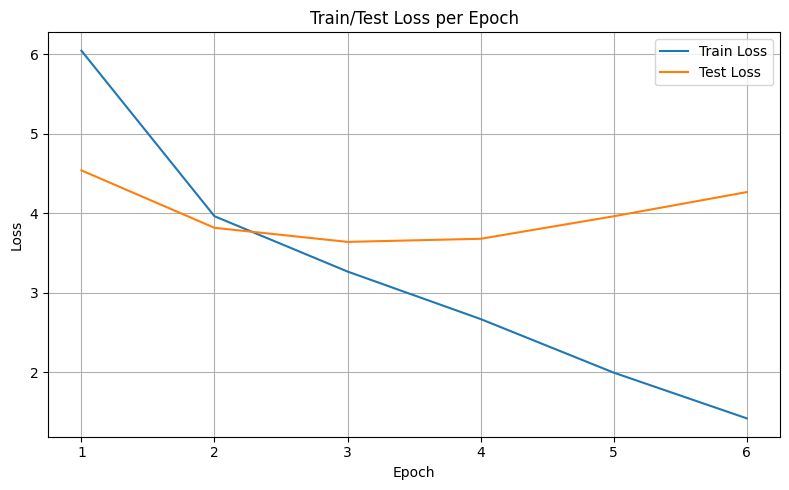

In [40]:
result=[]
hp_order = ['n_layers', 'd_model', 'n_heads', 'd_ff', 'dropout']
for i, hp_args in enumerate(arg_combinations):
  print(f"Trial {i+1}/{len(arg_combinations)}: {hp_args}")

  full_args = {
      "src_vocab_size": len(tokenizer.word_index) + 1,
      "tgt_vocab_size": len(tokenizer.word_index) + 1,
      "pos_len": 80,
      "shared_fc": True,
      "shared_emb": True,
      **hp_args
  }

  for warm in [500]:
    print(f"Warmup Steps: {warm}")
    best_val_loss = tuner(full_args, f"transformer_{i+1}_", warmup_steps=warm, epoch=20)
    hp_tuple = tuple(hp_args[k] for k in hp_order) + (warm, best_val_loss)
    result.append(hp_tuple)
    K.clear_session()

In [41]:
result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])

Best config: (1, 368, 8, 512, 0.2, 500, np.float64(3.6171353658040366))
Second best config: (1, 368, 8, 2048, 0.2, 500, np.float64(3.6402355829874673))
Third best config: (1, 128, 8, 2048, 0.2, 500, np.float64(3.670626640319824))


In [42]:
result

[(1, 368, 8, 512, 0.2, 500, np.float64(3.6171353658040366)),
 (1, 368, 8, 2048, 0.2, 500, np.float64(3.6402355829874673)),
 (1, 128, 8, 2048, 0.2, 500, np.float64(3.670626640319824)),
 (1, 128, 8, 512, 0.2, 500, np.float64(3.7086073557535806))]

Trial 1/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.5056
Epoch 1 Validation Loss: 4.9135


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.3176
Epoch 2 Validation Loss: 4.0429


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.6064
Epoch 3 Validation Loss: 3.7393


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1796
Epoch 4 Validation Loss: 3.6637


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.7786
Epoch 5 Validation Loss: 3.7309


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.3637
Epoch 6 Validation Loss: 3.9043


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.9675
Epoch 7 Validation Loss: 4.1502
Early stopping triggered at epoch 7


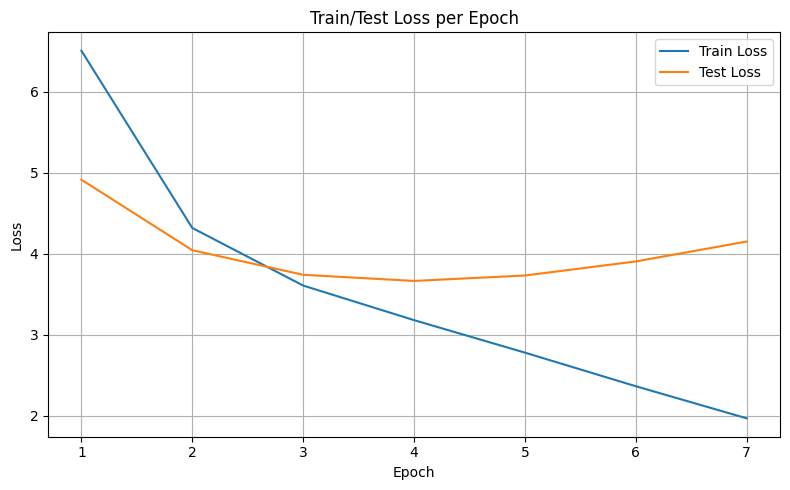

Trial 2/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.1097
Epoch 1 Validation Loss: 4.5963


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.9917
Epoch 2 Validation Loss: 3.8306


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.2925
Epoch 3 Validation Loss: 3.6274


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.6927
Epoch 4 Validation Loss: 3.6780


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.0265
Epoch 5 Validation Loss: 3.9447


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.4565
Epoch 6 Validation Loss: 4.2635
Early stopping triggered at epoch 6


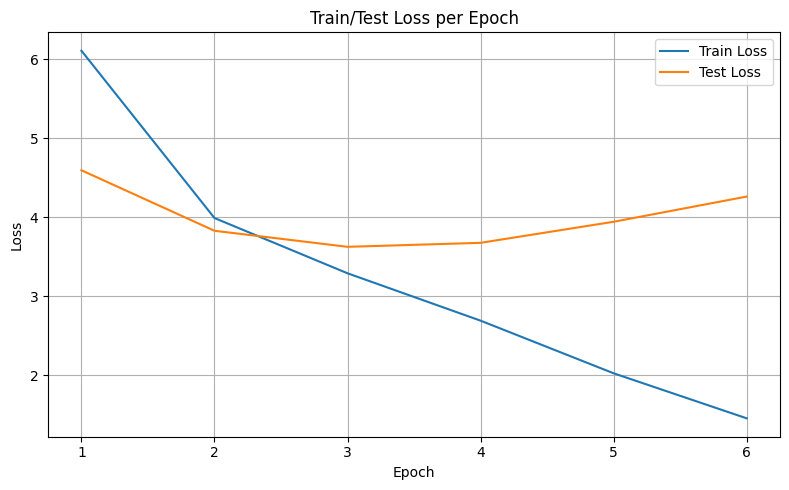

Trial 3/4: {'n_layers': 2, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.4195
Epoch 1 Validation Loss: 4.8306


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 4.2831
Epoch 2 Validation Loss: 4.0315


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.5735
Epoch 3 Validation Loss: 3.7386


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 3.1104
Epoch 4 Validation Loss: 3.6795


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 2.6821
Epoch 5 Validation Loss: 3.7713


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 2.2701
Epoch 6 Validation Loss: 3.9703


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 7 Train Loss: 1.8914
Epoch 7 Validation Loss: 4.1250
Early stopping triggered at epoch 7


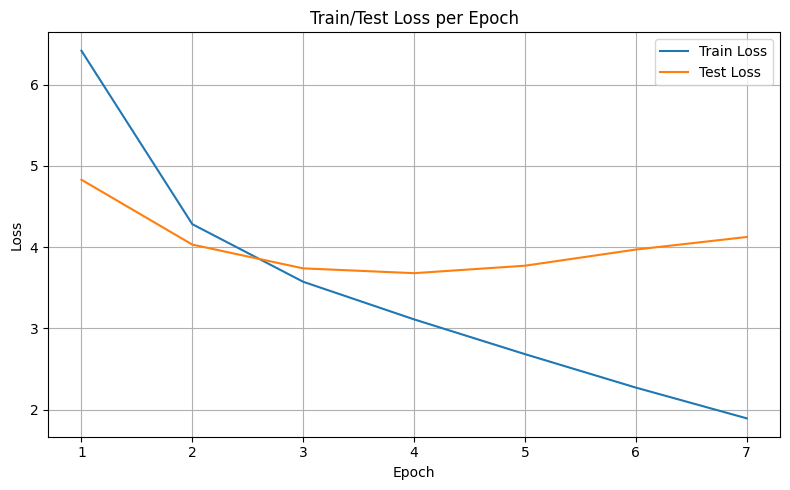

Trial 4/4: {'n_layers': 2, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1 Train Loss: 6.0396
Epoch 1 Validation Loss: 4.5947


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.9842
Epoch 2 Validation Loss: 3.8485


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3 Train Loss: 3.2101
Epoch 3 Validation Loss: 3.7118


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4 Train Loss: 2.5211
Epoch 4 Validation Loss: 3.8441


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5 Train Loss: 1.8342
Epoch 5 Validation Loss: 4.1644


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 6 Train Loss: 1.3882
Epoch 6 Validation Loss: 4.4547
Early stopping triggered at epoch 6


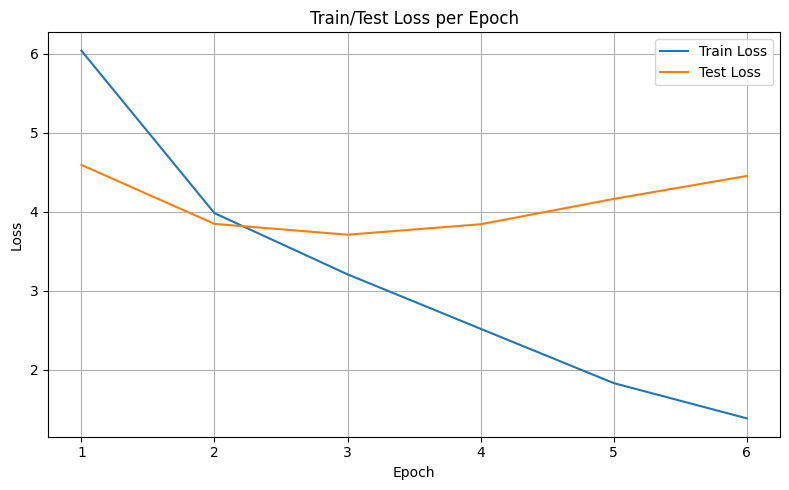

Best config: (1, 368, 8, 1024, 0.2, 500, np.float64(3.6274471282958984))
Second best config: (1, 128, 8, 1024, 0.2, 500, np.float64(3.663685162862142))
Third best config: (2, 128, 8, 1024, 0.2, 500, np.float64(3.679490089416504))


In [43]:
search_space = {
    "n_layers": [1,2],
    "d_model": [128, 368],
    "n_heads": [8],
    "d_ff": [1024],
    "dropout": [0.2]
}

keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

result=[]
hp_order = ['n_layers', 'd_model', 'n_heads', 'd_ff', 'dropout']
for i, hp_args in enumerate(arg_combinations):
  print(f"Trial {i+1}/{len(arg_combinations)}: {hp_args}")

  full_args = {
      "src_vocab_size": len(tokenizer.word_index) + 1,
      "tgt_vocab_size": len(tokenizer.word_index) + 1,
      "pos_len": 80,
      "shared_fc": True,
      "shared_emb": True,
      **hp_args
  }

  for warm in [500]:
    print(f"Warmup Steps: {warm}")
    best_val_loss = tuner(full_args, f"transformer_{i+1}_", warmup_steps=warm, epoch=20)
    hp_tuple = tuple(hp_args[k] for k in hp_order) + (warm, best_val_loss)
    result.append(hp_tuple)
    K.clear_session()

result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])

#3.lexical aug train

In [65]:
tokenizer.word_index

{'.': 1,
 '<sos>': 2,
 '<eos>': 3,
 '이': 4,
 '는': 5,
 '하': 6,
 '은': 7,
 '을': 8,
 '가': 9,
 '거': 10,
 '좋': 11,
 '아': 12,
 '고': 13,
 '보': 14,
 '?': 15,
 '있': 16,
 '어': 17,
 '세요': 18,
 '도': 19,
 '지': 20,
 '게': 21,
 '해': 22,
 '나': 23,
 '사람': 24,
 '에': 25,
 '겠': 26,
 '사랑': 27,
 '예요': 28,
 '였': 29,
 '않': 30,
 '어요': 31,
 '를': 32,
 '수': 33,
 '며': 34,
 '한': 35,
 '같': 36,
 '네요': 37,
 '아요': 38,
 '것': 39,
 '다': 40,
 '면': 41,
 '네': 42,
 '죠': 43,
 '안': 44,
 '는데': 45,
 '말': 46,
 '봐요': 47,
 '마음': 48,
 '친구': 49,
 '의': 50,
 '할': 51,
 '없': 52,
 '싶': 53,
 '생각': 54,
 '되': 55,
 '주': 56,
 '잘': 57,
 '했': 58,
 '어서': 59,
 '남자': 60,
 '내': 61,
 '연락': 62,
 '여자': 63,
 'ㅂ시오': 64,
 '만': 65,
 '너무': 66,
 '으며': 67,
 '더': 68,
 '기': 69,
 '오': 70,
 '이별': 71,
 '나쁘': 72,
 '었': 73,
 '해의': 74,
 '일': 75,
 '시간': 76,
 '들': 77,
 '썸': 78,
 '남': 79,
 '힘들': 80,
 '해요': 81,
 '짝': 82,
 '으로': 83,
 '군요': 84,
 '을까': 85,
 '와': 86,
 '길': 87,
 '한테': 88,
 '던': 89,
 '건': 90,
 '때': 91,
 '많이': 92,
 '많': 93,
 '았': 94,
 '에요': 95,
 '습니까': 96,
 '만나': 

In [122]:
import pickle

with open('word_index.pkl', 'wb') as f:
    pickle.dump(tokenizer.word_index, f)

In [49]:
aug = pd.read_csv('lexical.csv')

In [51]:
len(que_corpus)

7664

In [50]:
import ast

q_aug = [ast.literal_eval(x) for x in aug['Q']]
a_aug = [ast.literal_eval(x) for x in aug['A']]

In [53]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None, filters='')
tokenizer.fit_on_texts(que_corpus+ans_corpus+q_aug+a_aug)

In [54]:
enc_corpus= tokenizer.texts_to_sequences(que_corpus)
dec_corpus = tokenizer.texts_to_sequences(ans_corpus)

enc_corpus = tf.keras.preprocessing.sequence.pad_sequences(enc_corpus, padding='post')
dec_corpus = tf.keras.preprocessing.sequence.pad_sequences(dec_corpus, padding='post')

In [55]:
enc_train, enc_test, dec_train, dec_test = train_test_split(
    enc_corpus,
    dec_corpus,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

In [56]:
aug_enc = tokenizer.texts_to_sequences(q_aug)
aug_dec = tokenizer.texts_to_sequences(a_aug)

aug_enc = tf.keras.preprocessing.sequence.pad_sequences(aug_enc, padding='post', maxlen=enc_train.shape[1])
aug_dec = tf.keras.preprocessing.sequence.pad_sequences(aug_dec, padding='post', maxlen=dec_train.shape[1])

In [57]:
enc_train = np.concatenate((enc_train, aug_enc), axis=0)
dec_train = np.concatenate((dec_train, aug_dec), axis=0)

In [58]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(len(enc_train)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [59]:
from itertools import product

Trial 1/4: {'n_layers': 1, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 1 Train Loss: 4.6213
Epoch 1 Validation Loss: 3.3418
Best model saved at epoch 1


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 2 Train Loss: 2.7539
Epoch 2 Validation Loss: 2.4980
Best model saved at epoch 2


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 3 Train Loss: 1.7904
Epoch 3 Validation Loss: 1.8418
Best model saved at epoch 3


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 4 Train Loss: 1.0702
Epoch 4 Validation Loss: 1.4470
Best model saved at epoch 4


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.7178
Epoch 5 Validation Loss: 1.2404
Best model saved at epoch 5


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.5480
Epoch 6 Validation Loss: 1.1680
Best model saved at epoch 6


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.4513
Epoch 7 Validation Loss: 1.1609
Best model saved at epoch 7


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.3961
Epoch 8 Validation Loss: 1.1647


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.3533
Epoch 9 Validation Loss: 1.1653


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.3206
Epoch 10 Validation Loss: 1.1433
Best model saved at epoch 10


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 11 Train Loss: 0.2981
Epoch 11 Validation Loss: 1.1290
Best model saved at epoch 11


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 12 Train Loss: 0.2791
Epoch 12 Validation Loss: 1.1325


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 13 Train Loss: 0.2604
Epoch 13 Validation Loss: 1.1736


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 14 Train Loss: 0.2486
Epoch 14 Validation Loss: 1.1608
Early stopping triggered at epoch 14


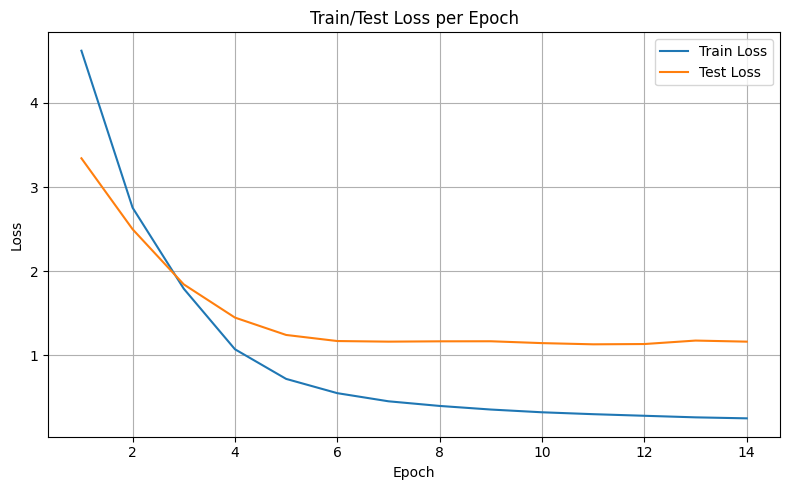

Trial 2/4: {'n_layers': 1, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 1 Train Loss: 4.3301
Epoch 1 Validation Loss: 2.9752
Best model saved at epoch 1


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 2 Train Loss: 2.1323
Epoch 2 Validation Loss: 1.9481
Best model saved at epoch 2


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 3 Train Loss: 1.3923
Epoch 3 Validation Loss: 1.5358
Best model saved at epoch 3


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.8928
Epoch 4 Validation Loss: 1.2901
Best model saved at epoch 4


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.6403
Epoch 5 Validation Loss: 1.1926
Best model saved at epoch 5


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.5118
Epoch 6 Validation Loss: 1.1483
Best model saved at epoch 6


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.4327
Epoch 7 Validation Loss: 1.0837
Best model saved at epoch 7


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.3793
Epoch 8 Validation Loss: 1.0620
Best model saved at epoch 8


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.3423
Epoch 9 Validation Loss: 1.0642


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.3115
Epoch 10 Validation Loss: 1.0784


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 11 Train Loss: 0.2881
Epoch 11 Validation Loss: 1.0908
Early stopping triggered at epoch 11


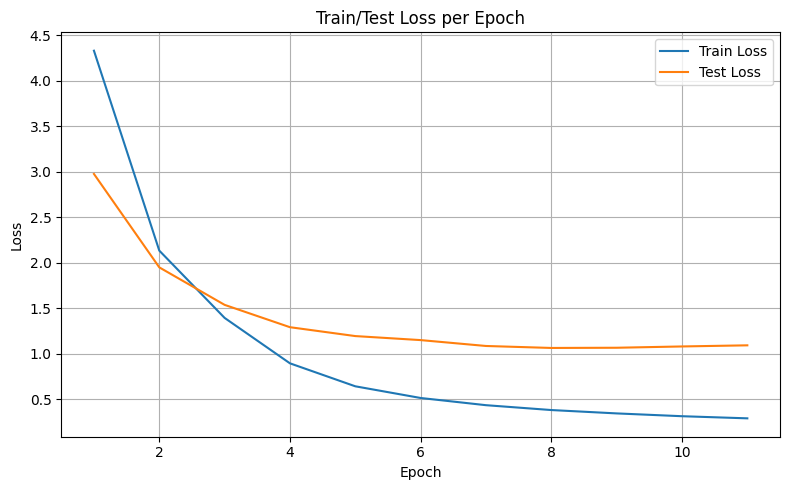

Trial 3/4: {'n_layers': 2, 'd_model': 128, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 1 Train Loss: 4.5486
Epoch 1 Validation Loss: 3.2922
Best model saved at epoch 1


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 2 Train Loss: 2.6724
Epoch 2 Validation Loss: 2.3730
Best model saved at epoch 2


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 3 Train Loss: 1.7545
Epoch 3 Validation Loss: 1.7811
Best model saved at epoch 3


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 4 Train Loss: 1.0512
Epoch 4 Validation Loss: 1.4197
Best model saved at epoch 4


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.7092
Epoch 5 Validation Loss: 1.2718
Best model saved at epoch 5


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.5454
Epoch 6 Validation Loss: 1.2220
Best model saved at epoch 6


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.4558
Epoch 7 Validation Loss: 1.1931
Best model saved at epoch 7


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.3927
Epoch 8 Validation Loss: 1.2047


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.3510
Epoch 9 Validation Loss: 1.1551
Best model saved at epoch 9


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.3200
Epoch 10 Validation Loss: 1.1471
Best model saved at epoch 10


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 11 Train Loss: 0.2948
Epoch 11 Validation Loss: 1.1572


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 12 Train Loss: 0.2744
Epoch 12 Validation Loss: 1.1852


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 13 Train Loss: 0.2580
Epoch 13 Validation Loss: 1.2015
Early stopping triggered at epoch 13


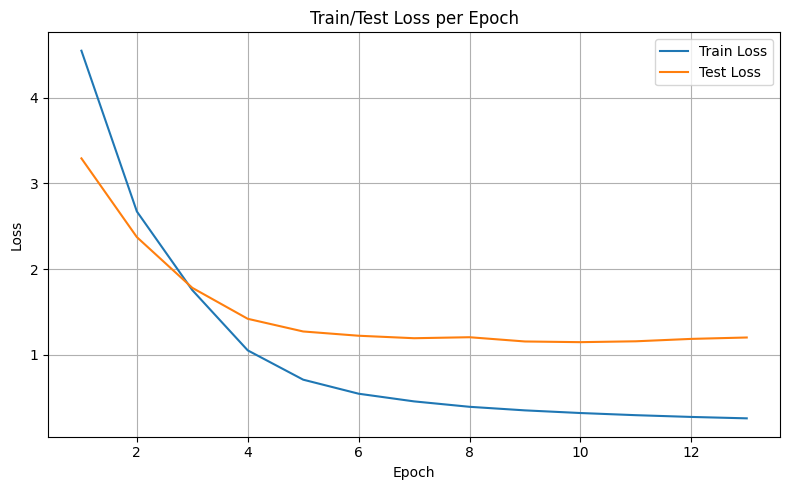

Trial 4/4: {'n_layers': 2, 'd_model': 368, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 1 Train Loss: 4.2526
Epoch 1 Validation Loss: 2.8445
Best model saved at epoch 1


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 2 Train Loss: 2.0860
Epoch 2 Validation Loss: 2.0122
Best model saved at epoch 2


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 3 Train Loss: 1.5269
Epoch 3 Validation Loss: 1.6728
Best model saved at epoch 3


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 4 Train Loss: 1.0054
Epoch 4 Validation Loss: 1.4378
Best model saved at epoch 4


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.7285
Epoch 5 Validation Loss: 1.2634
Best model saved at epoch 5


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.5796
Epoch 6 Validation Loss: 1.2472
Best model saved at epoch 6


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.4935
Epoch 7 Validation Loss: 1.1669
Best model saved at epoch 7


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.4319
Epoch 8 Validation Loss: 1.1669


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.3930
Epoch 9 Validation Loss: 1.1627
Best model saved at epoch 9


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.3568
Epoch 10 Validation Loss: 1.1341
Best model saved at epoch 10


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 11 Train Loss: 0.3295
Epoch 11 Validation Loss: 1.1183
Best model saved at epoch 11


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 12 Train Loss: 0.3076
Epoch 12 Validation Loss: 1.1038
Best model saved at epoch 12


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 13 Train Loss: 0.2860
Epoch 13 Validation Loss: 1.1501


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 14 Train Loss: 0.2696
Epoch 14 Validation Loss: 1.1234


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 15 Train Loss: 0.2546
Epoch 15 Validation Loss: 1.1067
Early stopping triggered at epoch 15


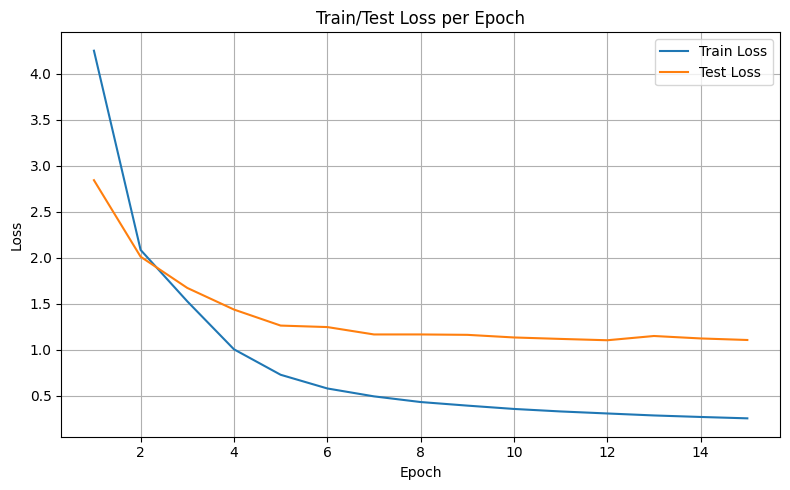

Best config: (1, 368, 8, 1024, 0.2, 500, np.float64(1.061966896057129))
Second best config: (2, 368, 8, 1024, 0.2, 500, np.float64(1.1038482189178467))
Third best config: (1, 128, 8, 1024, 0.2, 500, np.float64(1.1290327707926433))
(2, 128, 8, 1024, 0.2, 500, np.float64(1.1470534801483154))


In [123]:
search_space = {
    "n_layers": [1,2],
    "d_model": [128, 368],
    "n_heads": [8],
    "d_ff": [1024],
    "dropout": [0.2]
}

keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

result=[]
hp_order = ['n_layers', 'd_model', 'n_heads', 'd_ff', 'dropout']
for i, hp_args in enumerate(arg_combinations):
  print(f"Trial {i+1}/{len(arg_combinations)}: {hp_args}")

  full_args = {
      "src_vocab_size": len(tokenizer.word_index) + 1,
      "tgt_vocab_size": len(tokenizer.word_index) + 1,
      "pos_len": 80,
      "shared_fc": True,
      "shared_emb": True,
      **hp_args
  }

  for warm in [500]:
    print(f"Warmup Steps: {warm}")
    best_val_loss = tuner(full_args, f"transformer_{i+1}_", save=True, warmup_steps=warm, epoch=20)
    hp_tuple = tuple(hp_args[k] for k in hp_order) + (warm, best_val_loss)
    result.append(hp_tuple)
    K.clear_session()

result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])
print(result[3])

#4.사전임베딩

In [60]:
embedding_matrix = np.load('embedding_matrix.npy')

In [71]:
print(type(embedding_matrix))
print(embedding_matrix.dtype)
print(embedding_matrix.shape)

<class 'numpy.ndarray'>
float64
(6909, 200)


In [72]:
embedding_matrix = embedding_matrix.astype(np.float32)

In [81]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1],weights=[embedding_matrix],trainable=True)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
          self.fc.build((None, d_model))
          kernel = tf.transpose(self.dec_emb.weights[0]).numpy()
          bias = np.zeros((kernel.shape[1],), dtype=np.float32)
          self.fc.set_weights([kernel, bias])

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
search_space = {
    "n_layers": [1,2],
    "d_model": [200],
    "n_heads": [8],
    "d_ff": [1024],
    "dropout": [0.2]
}

keys, values = zip(*search_space.items())
arg_combinations = [dict(zip(keys, v)) for v in product(*values)]

result=[]
hp_order = ['n_layers', 'd_model', 'n_heads', 'd_ff', 'dropout']
for i, hp_args in enumerate(arg_combinations):
  print(f"Trial {i+1}/{len(arg_combinations)}: {hp_args}")

  full_args = {
      "src_vocab_size": len(tokenizer.word_index) + 1,
      "tgt_vocab_size": len(tokenizer.word_index) + 1,
      "pos_len": 80,
      "shared_fc": True,
      "shared_emb": True,
      **hp_args
  }

  for warm in [500]:
    print(f"Warmup Steps: {warm}")
    best_val_loss = tuner(full_args, f"transembed_{i+1}_", save=True, warmup_steps=warm, epoch=20)
    hp_tuple = tuple(hp_args[k] for k in hp_order) + (warm, best_val_loss)
    result.append(hp_tuple)
    K.clear_session()

result.sort(key=lambda x: x[6])
print("Best config:", result[0])
print("Second best config:", result[1])
print("Third best config:", result[2])
print(result[3])

Trial 1/2: {'n_layers': 1, 'd_model': 200, 'n_heads': 8, 'd_ff': 1024, 'dropout': 0.2}
Warmup Steps: 500


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 1 Train Loss: 24.6884
Epoch 1 Validation Loss: 5.0841
Best model saved at epoch 1


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 2 Train Loss: 3.8592
Epoch 2 Validation Loss: 3.4184
Best model saved at epoch 2


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 3 Train Loss: 2.5809
Epoch 3 Validation Loss: 2.4648
Best model saved at epoch 3


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 4 Train Loss: 1.5274
Epoch 4 Validation Loss: 1.8587
Best model saved at epoch 4


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.9728
Epoch 5 Validation Loss: 1.6414
Best model saved at epoch 5


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.7060
Epoch 6 Validation Loss: 1.4843
Best model saved at epoch 6


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.5680
Epoch 7 Validation Loss: 1.4315
Best model saved at epoch 7


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.4846
Epoch 8 Validation Loss: 1.3883
Best model saved at epoch 8


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.4307
Epoch 9 Validation Loss: 1.3940


  0%|          | 0/429 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.3896
Epoch 10 Validation Loss: 1.3935


  0%|          | 0/429 [00:00<?, ?it/s]

#5.평가

In [25]:
!pip install nltk

In [26]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [37]:
def beam_search(model, input_seq, tokenizer, start_token='<sos>', end_token='<eos>', max_len=36, beam_width=5, alpha=1.5):
  start = tokenizer.word_index[start_token]
  end = tokenizer.word_index[end_token]

  input_ids = np.array(input_seq)[None, :]
  sequences = [[ [start], 0.0 ]]

  for _ in range(max_len):
    all_candidates = []

    for seq, score in sequences:
      if seq[-1] == end:
        all_candidates.append([seq, score])
        continue

      tgt_input = np.array(seq)[None, :]
      enc_mask, dec_enc_mask, dec_mask = generate_masks(input_ids, tgt_input)
      pred, enc_attns, dec_attns, dec_enc_attns = model(input_ids, tgt_input, enc_mask, dec_enc_mask, dec_mask)

      probs = tf.nn.softmax(pred[0, -1]).numpy()  # (vocab_size,)

      top_k = np.argsort(probs)[-beam_width:][::-1]

      for token_id in top_k:
        candidate = seq + [token_id]
        log_p = np.log(probs[token_id] + 1e-10)
        new_score = score + log_p
        all_candidates.append([candidate, new_score])

    ordered = sorted(all_candidates, key=lambda tup: length_norm(tup[1], len(tup[0]), alpha), reverse=True)
    sequences = ordered[:beam_width]

    if all(seq[-1] == end for seq, _ in sequences):
      break

  best_seq = sequences[0][0]
  best_score = sequences[0][1]

  seq_length = len(best_seq) - 2
  if seq_length > 0:
      perplexity = np.exp(-best_score / seq_length)
  else:
      perplexity = float('inf')
  return tokenizer.sequences_to_texts([best_seq[1:-1]])

def length_norm(log_prob, length, alpha=0.7):
  norm = (5 + length) ** alpha / (5 + 1) ** alpha
  return log_prob / norm

In [28]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

In [29]:
!pip install rouge

In [30]:
from rouge import Rouge

def compute_rouge(pred,ref):
  rouge = Rouge()

  scores = rouge.get_scores(pred, ref)

  return scores[0]["rouge-1"]["f"],  scores[0]["rouge-2"]["f"], scores[0]["rouge-l"]["f"]

In [31]:
def scoring(answer):
  total_bleu = 0
  total_rouge1 = 0
  total_rouge2 = 0
  total_rougeL = 0
  n = len(answer)

  for pred, ref in answer:
    bleu = calculate_bleu(ref.split(), pred.split())
    rouge1, rouge2, rougeL = compute_rouge([pred], [ref])

    total_bleu += bleu
    total_rouge1 += rouge1
    total_rouge2 += rouge2
    total_rougeL += rougeL

  avg_bleu = total_bleu / n
  avg_rouge1 = total_rouge1 / n
  avg_rouge2 = total_rouge2 / n
  avg_rougeL = total_rougeL / n

  print(f"Average BLEU     : {avg_bleu:.4f}")
  print(f"Average ROUGE-1  : {avg_rouge1:.4f}")
  print(f"Average ROUGE-2  : {avg_rouge2:.4f}")
  print(f"Average ROUGE-L  : {avg_rougeL:.4f}")

  return {"bleu": avg_bleu,"rouge1": avg_rouge1,"rouge2": avg_rouge2,"rougeL": avg_rougeL}

In [11]:
transformer_args1 = {
    "n_layers": 1,
    "d_model": 128,
    "n_heads": 8,
    "d_ff": 1024,
    "src_vocab_size": len(tokenizer.word_index) + 1,
    "tgt_vocab_size": len(tokenizer.word_index) + 1,
    "pos_len": 80,
    "dropout": 0.2,
    "shared_fc": True,
    "shared_emb": True
}

transformer_args2 = {
    "n_layers": 1,
    "d_model": 368,
    "n_heads": 8,
    "d_ff": 1024,
    "src_vocab_size": len(tokenizer.word_index) + 1,
    "tgt_vocab_size": len(tokenizer.word_index) + 1,
    "pos_len": 80,
    "dropout": 0.2,
    "shared_fc": True,
    "shared_emb": True
}

transformer_args3 = {
    "n_layers": 2,
    "d_model": 128,
    "n_heads": 8,
    "d_ff": 1024,
    "src_vocab_size": len(tokenizer.word_index) + 1,
    "tgt_vocab_size": len(tokenizer.word_index) + 1,
    "pos_len": 80,
    "dropout": 0.2,
    "shared_fc": True,
    "shared_emb": True
}

transformer_args4= {
    "n_layers": 2,
    "d_model": 368,
    "n_heads": 8,
    "d_ff": 1024,
    "src_vocab_size": len(tokenizer.word_index) + 1,
    "tgt_vocab_size": len(tokenizer.word_index) + 1,
    "pos_len": 80,
    "dropout": 0.2,
    "shared_fc": True,
    "shared_emb": True
}

In [67]:
model1=Transformer(**transformer_args1)
src= enc_test[0][None,:]
tgt_in = dec_test[0][:-1][None,:]

enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

predictions, enc_attns, dec_attns, dec_enc_attns = model1(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
model1.load_weights('transformer_1_best_model.weights.h5')

In [32]:
df= pd.read_csv('valid.csv')

In [40]:
enc_train.shape[1], dec_train.shape[1]

(27, 36)

In [50]:
a=beam_search(model1,enc_test[1],tokenizer)

In [51]:
a

['이제 부터 안 하 면 돼요 .']

In [38]:
def evaluate(model, src, tgt=None, tokenizer=tokenizer):
  src=preprocess(src)
  if tgt is None:
    tgt = "응답"
  tgt=preprocess(tgt)
  src_tensor=tokenizer.texts_to_sequences([src])
  src_tensor=tf.keras.preprocessing.sequence.pad_sequences(src_tensor, padding='post', maxlen=27)
  pred=beam_search(model,src_tensor[0],tokenizer)
  return [pred[0], " ".join(tgt)]

In [48]:
aa= evaluate(model1,df['Q'][0], df["A"][0])

In [49]:
aa

['대화 로 풀 어 보 세요 .', '대화 로 풀 어 보 세요 .']

In [88]:
beam_answers1=[]
for i in range(len(df)):
  answer = evaluate(model1,df['Q'][i], df["A"][i])
  beam_answers1.append(answer)

ex1 = scoring(beam_answers1)

Average BLEU     : 0.6975
Average ROUGE-1  : 0.7604
Average ROUGE-2  : 0.7153
Average ROUGE-L  : 0.7593


In [68]:
model2=Transformer(**transformer_args2)
src= enc_test[0][None,:]
tgt_in = dec_test[0][:-1][None,:]

enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

predictions, enc_attns, dec_attns, dec_enc_attns = model2(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
model2.load_weights('transformer_2_best_model.weights.h5')

In [90]:
beam_answers2=[]
for i in range(len(df)):
  answer = evaluate(model2,df['Q'][i], df["A"][i])
  beam_answers2.append(answer)

ex2 = scoring(beam_answers2)

Average BLEU     : 0.6148
Average ROUGE-1  : 0.7072
Average ROUGE-2  : 0.6412
Average ROUGE-L  : 0.7057


In [69]:
model3=Transformer(**transformer_args3)
src= enc_test[0][None,:]
tgt_in = dec_test[0][:-1][None,:]

enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

predictions, enc_attns, dec_attns, dec_enc_attns = model3(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
model3.load_weights('transformer_3_best_model.weights.h5')

In [92]:
beam_answers3=[]
for i in range(len(df)):
  answer = evaluate(model3,df['Q'][i], df["A"][i])
  beam_answers3.append(answer)

ex3 = scoring(beam_answers3)

Average BLEU     : 0.6477
Average ROUGE-1  : 0.7339
Average ROUGE-2  : 0.6710
Average ROUGE-L  : 0.7324


In [44]:
model4=Transformer(**transformer_args4)
src= enc_test[0][None,:]
tgt_in = dec_test[0][:-1][None,:]

enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

predictions, enc_attns, dec_attns, dec_enc_attns = model4(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
model4.load_weights('transformer_4_best_model.weights.h5')

In [45]:
beam_answers4=[]
for i in range(len(df)):
  answer = evaluate(model4,df['Q'][i], df["A"][i])
  beam_answers4.append(answer)

ex4 = scoring(beam_answers4)

Average BLEU     : 0.7197
Average ROUGE-1  : 0.7772
Average ROUGE-2  : 0.7342
Average ROUGE-L  : 0.7767


In [36]:
beam_answers5=[]
for i in range(len(df)):
  answer = evaluate(model5,df['Q'][i], df["A"][i])
  beam_answers5.append(answer)

ex5 = scoring(beam_answers5)

AttributeError: 'numpy.float32' object has no attribute 'split'

In [40]:
sentence_pairs = [pair for pair, _ in beam_answers5]

In [42]:
ex5 = scoring(sentence_pairs)

Average BLEU     : 0.0462
Average ROUGE-1  : 0.1366
Average ROUGE-2  : 0.0422
Average ROUGE-L  : 0.1291


In [44]:
ex1 = {
    "bleu": 0.6975,
    "rouge1": 0.7604,
    "rouge2": 0.7153,
    "rougeL": 0.7593
}

ex2 = {
    "bleu": 0.6148,
    "rouge1": 0.7072,
    "rouge2": 0.6412,
    "rougeL": 0.7057
}

ex3 = {
    "bleu": 0.6477,
    "rouge1": 0.7339,
    "rouge2": 0.6710,
    "rougeL": 0.7324
}

ex4 = {
    "bleu": 0.7197,
    "rouge1": 0.7772,
    "rouge2": 0.7342,
    "rougeL": 0.7767
}

ex5 = {
    "bleu": 0.0462,
    "rouge1": 0.1366,
    "rouge2": 0.0422,
    "rougeL": 0.1291
}

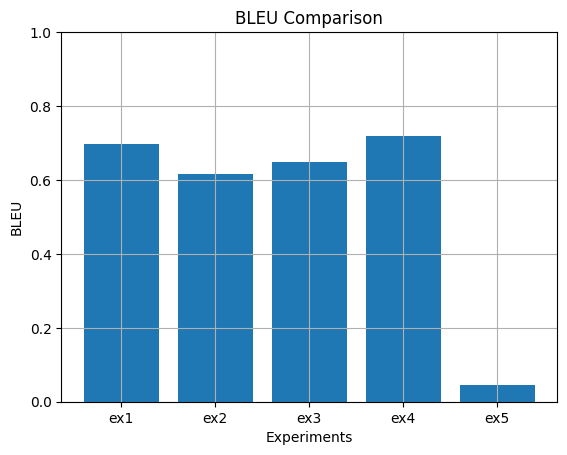

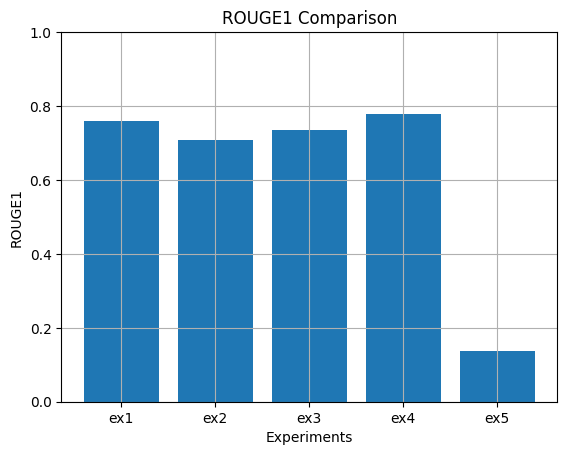

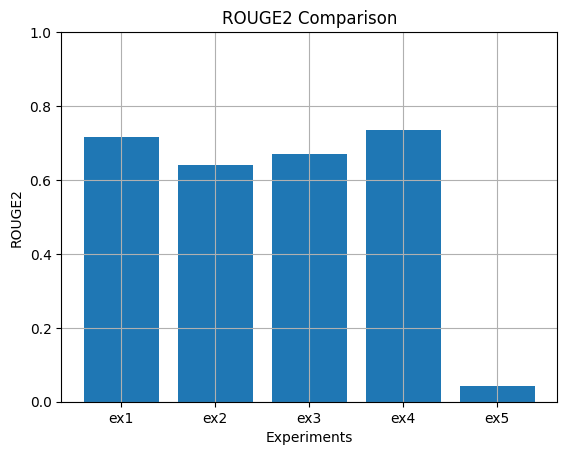

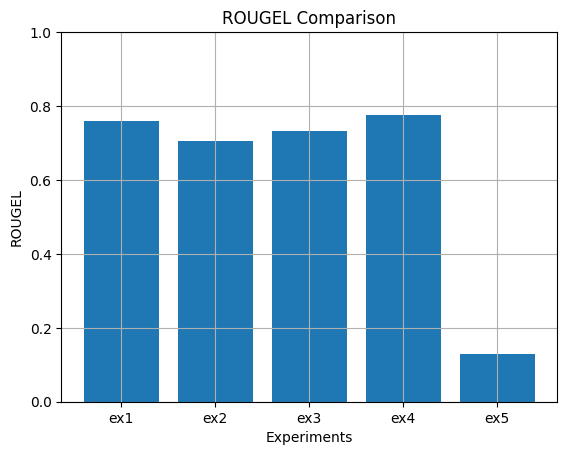

In [48]:
experiments = ['ex1', 'ex2', 'ex3', 'ex4', 'ex5']
metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL']
scores = {
    'bleu':   [ex1['bleu'], ex2['bleu'], ex3['bleu'], ex4['bleu'], ex5['bleu']],
    'rouge1': [ex1['rouge1'], ex2['rouge1'], ex3['rouge1'], ex4['rouge1'], ex5['rouge1']],
    'rouge2': [ex1['rouge2'], ex2['rouge2'], ex3['rouge2'], ex4['rouge2'], ex5['rouge2']],
    'rougeL': [ex1['rougeL'], ex2['rougeL'], ex3['rougeL'], ex4['rougeL'], ex5['rougeL']]
}

for metric in metrics:
    plt.figure()
    plt.bar(experiments, scores[metric])
    plt.title(f'{metric.upper()} Comparison')
    plt.ylabel(metric.upper())
    plt.xlabel('Experiments')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

metric : rogue, sentence_bleu score
perplexity는 exp(cross_entropy)라 제외

774개 valid data내 평균, bleu4 weight (0.25,0.25,0.25,0.25) corpus bleu가 아닌 sentence blue 사용


In [46]:
Q1='지루하다, 놀러가고 싶어.'
Q2='오늘 일찍 일어났더니 피곤하다.'
Q3= '간만에 여자친구랑 데이트 하기로 했어.'
Q4= '집에 있는다는 소리야.'

In [77]:
print(evaluate(model1,Q1, None))
print(evaluate(model2,Q1, None))
print(evaluate(model3,Q1, None))
print(evaluate(model4,Q1, None))

(['바쁘 게 해 보 세요 .', '응답'], np.float32(1.6015776))
(['저 도 궁금하 으며 겠 어요 .', '응답'], np.float32(1.4265732))
(['저 도 배우 면 좋 죠 .', '응답'], np.float32(1.5448112))
(['당신 은 매력 은 네요 .', '응답'], np.float32(1.6321014))


In [78]:
print(evaluate(model1,Q2, None))
print(evaluate(model2,Q2, None))
print(evaluate(model3,Q2, None))
print(evaluate(model4,Q2, None))

(['짝사랑 인지 생각 해 보 세요 .', '응답'], np.float32(1.7514379))
(['고민 하 지 말 고 내려놓 길 바랄게요 .', '응답'], np.float32(1.5650932))
(['힘드 시 면 안 하 는 게 도움 이 그냥 맘 편할 거 예요 .', '응답'], np.float32(1.584318))
(['아닐 거 예요 .', '응답'], np.float32(1.6167173))


In [79]:
print(evaluate(model1,Q3, None))
print(evaluate(model2,Q3, None))
print(evaluate(model3,Q3, None))
print(evaluate(model4,Q3, None))

(['분위기 있 는 순간 은 군요 .', '응답'], np.float32(1.7995653))
(['고생 많 았 어요 .', '응답'], np.float32(1.6337286))
(['후회 하 지 않 길 바라 요 .', '응답'], np.float32(1.5189766))
(['그러 는 편 이 나 을 거 예요 .', '응답'], np.float32(1.4908601))


In [80]:
print(evaluate(model1,Q4, None))
print(evaluate(model2,Q4, None))
print(evaluate(model3,Q4, None))
print(evaluate(model4,Q4, None))

(['사랑 이 피곤 한가 봐요 .', '응답'], np.float32(1.7309943))
(['저 도 긴장 해 주 세요 .', '응답'], np.float32(1.8746898))
(['세상 걱정 되 지 않 을까요 .', '응답'], np.float32(1.9953686))
(['긍정 적 인 변화 이 길 바랍니다 .', '응답'], np.float32(1.7933534))


In [47]:
print(evaluate(model5,Q1, None))
print(evaluate(model5,Q2, None))
print(evaluate(model5,Q3, None))
print(evaluate(model5,Q4, None))

['저 는 마음 이 필요 한 것 같 아요 .', '응답']
['이별 이 었 나 봐요 .', '응답']
['마음 의 준비 하 는 것 도 좋 을 거 같 아요 .', '응답']
['저 는 마음 이 좋 을 거 예요 .', '응답']


model1(layer1개 d_model 128) 과 model4(layer 2개 d_model 368)이 성능이 좋았고 후자가 점수 상 더 높았으나 생성결과는 model1이 더 좋을 때도 있었음.

valid data 기준이기 때문에 공정한 평가는 아님

데이터 20000개를 맞추려고 명사만 대체하기보다는 동사 어미도 같이 lexial substituion을 적용했는데 그 결과 증강 데이터 내에도 문법적 오류가 있었고 실제 생성데이터에서도 작은 문법적 오류들이 관찰됨.

증강 시 대화의 주제 범위는 전혀 바뀌지 않기 때문에 제한된 주제 내에서 응답의 유창성이 올라갈 것이라 기대하였다.
하지만 그 이상으로 증강 전은 학습이 잘 되지 않았고 증강 후 학습이 상대적으로 잘 이루어졌다.

실제 생성 대화도 그렇고 증강 후 성능 변화는 극명하다.

가장 큰 성능 기대점은 노이즈 추가라고 생각한다.
프로젝트 요구사항에 맞춰 중복을 제거하였는데 증강에서는 기존 Q에 A를 lexial substitution하거나 기존 A고정에 Q를 증강하는 식으로 진행하였기에 같은 Q에 다른 A도 생기고 반대도 발생하였다.

이 결과 모델은 같은 Q에 다른 A를 학습하게 되고 더 중요하고 공통된 패턴을 학습하라고 유도하는 효과가 있는 것으로 판단된다.

데이터 개수를 맞추기 위해 cosine similiarity threshold를 0.63 정도로 낮게 주고 사용했는데 더 높게 정제한다면 문법적 오류도 더 줄어들 것으로 기대된다.



실제 정성평가를 진행했을 때 잘 나오지 않은 주제나 input 문장이 짧은 경우 힘들어 하는 경향을 보였다.

input문장이 짧을 경우 뉘앙스를 파악하기 힘들어하는 것 같다. 상대적으로 정보가 부족하기 때문이다.

썸인것같아. 라는 질문에 잘 답변하지 못했고 썸이라는 단어가 학습된 임베딩 공간내에 제대로 위치하고 있는지도 궁금하다.

chatbot이 open domain에서 잘 작동하기 위해서는 그 광범위한 주제를 학습시킬 데이터가 우선적으로 필요한데 데이터 7600(중복제거)로 그 다양성을 가질 것이라 기대되지 않는다.

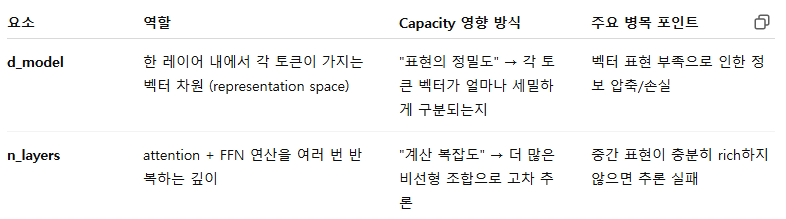

흥미로운 점은 layer1개 일때는 d_model이 128이 좋고 layer2개 일때는 d_modeldl 368일때 좋았다는 점.

파라미터 수의 극단 지점들이 각각 좋았는데 추측해보면 다음과 같다.
1. model1은 파라미터 수가 적어서 과적합 위험이 적었다.
2. layer수를 늘린다는 것은 더 깊은 고차원 정보를 뽑겠다는 것이고 문제는 d_model, 즉 각 토큰이 가질 수 있는 정보 capacity, 또는 embedding 공간 내의 표현력이 제한되면 더 깊게 추출한 정보를 제대로 담을수도 없고 다음 레이어로 rich한 정보가 충분히 전달되지도 않는다.
3. 즉, layer수를 늘렸을 때 d_model이 충분하지 못하면 각 다음 layer는 충분한 정보를 전달 받지도 못하고 추출한 정보를 온전히 임베딩 공간내에 표현할 수도 없다.
4. 따라서, model1은 상대적으로 얕은 추론인 경우 작은 데이터셋에서 과적합을 피하기에는 model2보다 좋았던 것으로 보이며
5. model4는 model3의 d_model로는 깊은 추론을 하기에는 충분한 임베딩 공간내 표현용량이 없는 것으로 보인다.
6. n_layer : 함수의 표현능력 / d_model embedding 공간의 표현용량 , (d_ff 제외했을때, d_ff의 비선형성)

또 흥미로운 점은 model2보다는 model3가 비교적 좋았다는 점이다. 여러번 실험을 해봐야 정확하겠지만 d_model이 커서 표현공간이 충분하지만 추론이 깊지 못한 것보다 표현공간이 부족하더라도 추론을 더 하는 것이 이번 task에는 더 적합했던 것으로 추측되지만 더 많은 실험이 필요하다.



사전 임베딩은 vocab size 6900개 중 2800개 임베딩을 채웠고 fasttext기반이 더 대체할 수 있지만 most silmilar 찍어봤을 때 적절해 보이지 않아서 9년전 사전 임베딩 사용

말뭉치 구한 후 mecab 기반으로 word2vec 학습시키고 사용하면 더 보완된 사전 임베딩을 얻을 수 있을 거라고 판단됨.

시간 문제로 실험은 못함.